## Concatenate datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

base_dir = '/mnt/shared/datasets/game-traces/csv'
processed_data_dir = '/mnt/shared/datasets/game-traces/processed_data'

os.makedirs(processed_data_dir, exist_ok=True)
print(f"Processed data will be saved to: {processed_data_dir}")

# List all CSV files in the directory
all_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.csv')]

print(f"Found {len(all_files)} CSV files.")
for f in all_files:
    print(f)

Processed data will be saved to: /mnt/shared/datasets/game-traces/processed_data
Found 25 CSV files.
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-04-29_20-27-07_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-05-06_15-30-39_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-04-29_08-11-09_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-04-28_10-23-52_cleaned.csv
/mnt/shared/datasets/game-traces/csv/overwatch_60m_2025-04-28_08-14-36_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-04-28_14-29-06_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-05-04_20-43-58_cleaned.csv
/mnt/shared/datasets/game-traces/csv/marvel_rivals_60m_2025-05-06_15-32-52_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-05-05_13-56-12_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-05-05_07-37-26_cleaned.csv
/mnt/shared/datasets/game-traces/csv/deadlock_60m_2025-05-01_07-11-16_cle

In [2]:
from collections import defaultdict

game_files = defaultdict(list)

for filepath in all_files:
    filename = os.path.basename(filepath)
    # Extract a recognizable game name from the filename
    if filename.startswith('cyberpunk_2077'):
        game_name = 'Cyberpunk 2077'
    elif filename.startswith('cyberpunk_loading'):
        game_name = 'Cyberpunk 2077 (Loading/Reloading)' # Keep separate for specific scenario analysis
    elif filename.startswith('deadlock_60m'):
        game_name = 'Deadlock'
    elif filename.startswith('hogwarts_legacy'):
        game_name = 'Hogwarts Legacy'
    elif filename.startswith('marvel_rivals'):
        game_name = 'Marvel Rivals'
    elif filename.startswith('overwatch_60m'):
        game_name = 'Overwatch'
    elif filename.startswith('the_finals'):
        game_name = 'The Finals'
    elif filename.startswith('the_last_of_us_part_i'):
        game_name = 'The Last of Us Part I'

    game_files[game_name].append(filepath)

print("\nGrouped files by game:")
for game, files in game_files.items():
    print(f"- {game}: {len(files)} files")
    


Grouped files by game:
- Deadlock: 14 files
- Overwatch: 1 files
- Marvel Rivals: 1 files
- The Finals: 1 files
- Hogwarts Legacy: 4 files
- Cyberpunk 2077: 2 files
- The Last of Us Part I: 1 files
- Cyberpunk 2077 (Loading/Reloading): 1 files


In [ ]:
import re
# Dictionaries to store grouped files based on their categorization

# --- Dictionaries to store grouped files based on their categorization ---
# 1. For games where multiple files should be chronologically concatenated
#    (e.g., Cyberpunk, Hogwarts - often _1, _2 suffixes or scenario names)
combine_by_game_title = defaultdict(list)

# 2. For games where files should be grouped by game prefix AND date,
#    then chronologically concatenated (e.g., Deadlock, Marvel Rivals - explicit YYYY-MM-DD in filename)
combine_by_game_and_date = defaultdict(list)

# 3. For unique single-file sessions that don't fit other patterns (e.g., The Last of Us)
single_file_sessions = defaultdict(list)


for filepath in all_files:
    filename = os.path.basename(filepath)

    # --- Pattern A: Files to be combined chronologically under a broader game title ---
    # These typically lack explicit date/time stamps that define separate sessions,
    # and often have numbered suffixes or generic scenario descriptions.
    if filename.startswith('cyberpunk_2077') or filename.startswith('cyberpunk_loading'):
        combine_by_game_title['Cyberpunk 2077'].append(filepath)
    elif filename.startswith('hogwarts_legacy'):
        combine_by_game_title['Hogwarts Legacy'].append(filepath)
    # ----------------------------------------------------------------------------------

    # Pattern B: Group by game prefix AND date (explicit date in filename)
    # Using regex to extract the base game name and the date part
    # This regex looks for:
    #   - A game prefix ending with _60m (like deadlock_60m, marvel_rivals_60m, overwatch_60m)
    #   - OR 'the_finals_30m'
    #   - Followed by a date (YYYY-MM-DD)
    #   - Followed by a time (HH-MM-SS)
    date_pattern_match = re.match(r'([a-zA-Z_]+_60m|the_finals_30m)_(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})_cleaned\.csv', filename)
    if date_pattern_match:
        game_prefix = date_pattern_match.group(1) # e.g., 'deadlock_60m', 'marvel_rivals_60m'
        date = date_pattern_match.group(2)         # e.g., '2025-05-01'
        session_key = f"{game_prefix}_{date}" # Combine game prefix and date for a unique session key
        combine_by_game_and_date[session_key].append(filepath)

    # Pattern C: Single unique files that don't fit other patterns
    # These will be analyzed as their own distinct session.
    elif filename.startswith('the_last_of_us_part_i'):
        session_name = filename.replace('_cleaned.csv', '')
        single_file_sessions[session_name].append(filepath) # This will always be a list of 1

    else:
        if not (filename.startswith('cyberpunk_2077') or filename.startswith('cyberpunk_loading') or filename.startswith('hogwarts_legacy')):
            # Catch any files that don't fit the defined patterns
            print(f"Warning: File '{filename}' not categorized. It will be skipped for EDA.")

# --- Print the grouped files for verification ---
print("\nFiles to be combined by game title (e.g., Cyberpunk, Hogwarts - chronologically sorted):")
for game, files in combine_by_game_title.items():
    print(f"- {game}: {len(files)} files")

print("\nFiles to be combined by game AND date (e.g., Deadlock_60m_2025-05-01 - chronologically sorted per day):")
for session_key, files in combine_by_game_and_date.items():
    print(f"- {session_key}: {len(files)} files")

print("\nSingle unique files to be analyzed individually:")
for session_name, files in single_file_sessions.items():
    print(f"- {session_name}: {len(files)} file(s)")


In [ ]:
# 1. Process files to be combined by main game title (Pattern A)
for game_name, files in combine_by_game_title.items():
    print(f"\nProcessing combined game data for {game_name} with {len(files)} file(s)...")
    if not files:
        print(f"No files found for {game_name}. Skipping.")
        continue

    dfs_to_concat = []
    for f in files:
        try:
            temp_df = pd.read_csv(f)
            if 'Start Time' in temp_df.columns and not temp_df.empty:
                # Store DataFrame along with its minimum Start Time for chronological sorting
                dfs_to_concat.append({'df': temp_df, 'start_time': temp_df['Start Time'].min(), 'filename': os.path.basename(f)})
                print(f"  Loaded: {os.path.basename(f)} (Earliest Start Time: {temp_df['Start Time'].min()})")
            else:
                print(f"  Warning: '{os.path.basename(f)}' is empty or missing 'Start Time' column. Skipping.")
        except Exception as e:
            print(f"  Error loading {os.path.basename(f)}: {e}")
            continue

    if not dfs_to_concat:
        print(f"No dataframes successfully loaded for {game_name}. Skipping EDA.")
        continue

    # Sort DataFrames by their earliest Start Time before concatenation
    dfs_to_concat.sort(key=lambda x: x['start_time'])
    sorted_dfs = [item['df'] for item in dfs_to_concat]

    game_df = pd.concat(sorted_dfs, ignore_index=True)
    print(f"Concatenated {len(sorted_dfs)} files chronologically for {game_name} into a single DataFrame with {len(game_df)} rows.")

    # perform_eda(game_df, game_name)

    # Save the processed DataFrame
    output_filename = f"{game_name.replace(' ', '_').lower()}_combined.parquet"
    output_filepath = os.path.join(processed_data_dir, output_filename)
    game_df.to_parquet(output_filepath, index=False)
    print(f"Saved processed data for {game_name} to {output_filepath}")


# 2. Process files to be combined by game AND date (Pattern B)
for session_key, files in combine_by_game_and_date.items():
    print(f"\nProcessing daily session for {session_key} with {len(files)} file(s)...")
    if not files:
        print(f"No files found for {session_key}. Skipping.")
        continue

    dfs_to_concat = []
    for f in files:
        try:
            temp_df = pd.read_csv(f)
            if 'Start Time' in temp_df.columns and not temp_df.empty:
                dfs_to_concat.append({'df': temp_df, 'start_time': temp_df['Start Time'].min(), 'filename': os.path.basename(f)})
                print(f"  Loaded: {os.path.basename(f)} (Earliest Start Time: {temp_df['Start Time'].min()})")
            else:
                print(f"  Warning: '{os.path.basename(f)}' is empty or missing 'Start Time' column. Skipping.")
        except Exception as e:
            print(f"  Error loading {os.path.basename(f)}: {e}")
            continue

    if not dfs_to_concat:
        print(f"No dataframes successfully loaded for {session_key}. Skipping EDA.")
        continue

    # Sort DataFrames by their earliest Start Time before concatenation for the day
    dfs_to_concat.sort(key=lambda x: x['start_time'])
    sorted_dfs = [item['df'] for item in dfs_to_concat]

    session_df = pd.concat(sorted_dfs, ignore_index=True)
    print(f"Concatenated {len(sorted_dfs)} files chronologically for {session_key} into a single DataFrame with {len(session_df)} rows.")

    # perform_eda(session_df, session_key)

    # Save the processed DataFrame
    output_filename = f"{session_key}_combined.parquet"
    output_filepath = os.path.join(processed_data_dir, output_filename)
    session_df.to_parquet(output_filepath, index=False)
    print(f"Saved processed data for {session_key} to {output_filepath}")


# 3. Process single unique files (Pattern C)
for session_name, files in single_file_sessions.items():
    # As per definition, 'files' list for these will always contain exactly one filepath
    filepath = files[0]
    print(f"\nProcessing individual session: {session_name}...")
    try:
        session_df = pd.read_csv(filepath)
        print(f"  Loaded: {os.path.basename(filepath)}")
        # perform_eda(session_df, session_name)
        # Save the processed DataFrame (no concatenation needed for single files)
        output_filename = f"{session_name}.parquet"
        output_filepath = os.path.join(processed_data_dir, output_filename)
        session_df.to_parquet(output_filepath, index=False)
        print(f"Saved processed data for {session_name} to {output_filepath}")
    except Exception as e:
        print(f"  Error loading and processing {os.path.basename(filepath)}: {e}")
        continue

If works fine, the concatenated datasets should be in `/mnt/shared/datasets/game-traces/processed_data`

However, I decided to combine all the deadlock datasets together and run a EDA on them

In [1]:
import pandas as pd
import os

dataset_path = '/mnt/shared/datasets/game-traces/processed_data/'
output_path = '/home/appliedai/jessica/gaming_tryouts/'

files = [
    "deadlock_60m_2025-04-27_combined.parquet",
    "deadlock_60m_2025-04-28_combined.parquet", "deadlock_60m_2025-04-29_combined.parquet",
    "deadlock_60m_2025-05-01_combined.parquet", "deadlock_60m_2025-05-02_combined.parquet",
    "deadlock_60m_2025-05-03_combined.parquet", "deadlock_60m_2025-05-04_combined.parquet",
    "deadlock_60m_2025-05-05_combined.parquet", "deadlock_60m_2025-05-06_combined.parquet"
]

# List to hold individual DataFrames
dataframes = []

# Read each Parquet file and append to list
for file in files:
    file_path = os.path.join(dataset_path, file)
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        dataframes.append(df)
    else:
        print(f"Warning: File not found - {file_path}")

# Combine all DataFrames
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Save to current path with a meaningful name
    output_file = os.path.join(dataset_path, 'combined_deadlock.parquet')
    combined_df.to_parquet(output_file, index=False)
    print(f"Combined dataset saved to: {output_file}")
else:
    print("No files were loaded to combine.")


Combined dataset saved to: /mnt/shared/datasets/game-traces/processed_data/combined_deadlock.parquet


In [4]:
dataset_path = '/mnt/shared/datasets/game-traces/processed_data/'
output_path = '/home/appliedai/jessica/gaming_tryouts/'

files = [
    "cyberpunk_2077_combined.parquet", "deadlock_60m_2025-04-27_combined.parquet",
    "deadlock_60m_2025-04-28_combined.parquet", "deadlock_60m_2025-04-29_combined.parquet",
    "deadlock_60m_2025-05-01_combined.parquet", "deadlock_60m_2025-05-02_combined.parquet",
    "deadlock_60m_2025-05-03_combined.parquet", "deadlock_60m_2025-05-04_combined.parquet",
    "deadlock_60m_2025-05-05_combined.parquet", "deadlock_60m_2025-05-06_combined.parquet",
    "hogwarts_legacy_combined.parquet", "marvel_rivals_60m_2025-05-06_combined.parquet",
    "overwatch_60m_2025-04-28_combined.parquet", "the_finals_30m_2025-05-01_combined.parquet",
    "the_last_of_us_part_i.parquet", "combined_deadlock.parquet"
]

In [5]:
# Store schema info
schemas = {}

for file in files:
    df = pd.read_parquet(dataset_path+file)
    schemas[file] = [(col, str(df[col].dtype)) for col in df.columns]

# Compare schemas
reference_schema = schemas[files[0]]

for file, schema in schemas.items():
    if schema != reference_schema:
        print(f"❌ Schema mismatch in: {file}")
        print(f"  Expected: {reference_schema}")
        print(f"  Found:    {schema}\n")
    else:
        print(f"✅ Schema match: {file}")

✅ Schema match: cyberpunk_2077_combined.parquet
✅ Schema match: deadlock_60m_2025-04-27_combined.parquet
✅ Schema match: deadlock_60m_2025-04-28_combined.parquet
✅ Schema match: deadlock_60m_2025-04-29_combined.parquet
✅ Schema match: deadlock_60m_2025-05-01_combined.parquet
✅ Schema match: deadlock_60m_2025-05-02_combined.parquet
✅ Schema match: deadlock_60m_2025-05-03_combined.parquet
✅ Schema match: deadlock_60m_2025-05-04_combined.parquet
✅ Schema match: deadlock_60m_2025-05-05_combined.parquet
✅ Schema match: deadlock_60m_2025-05-06_combined.parquet
✅ Schema match: hogwarts_legacy_combined.parquet
✅ Schema match: marvel_rivals_60m_2025-05-06_combined.parquet
✅ Schema match: overwatch_60m_2025-04-28_combined.parquet
✅ Schema match: the_finals_30m_2025-05-01_combined.parquet
✅ Schema match: the_last_of_us_part_i.parquet
✅ Schema match: combined_deadlock.parquet


Now we know that all dataset schema matches, we can develop a EDA function to run on all of them

## EDA

In [1]:
import pandas as pd
import numpy as np


processed_data_dir = '/mnt/shared/datasets/game-traces/processed_data/'
# dir_name = "cyberpunk_2077_combined.parquet"
dir_name = "the_last_of_us_part_i.parquet"
dir =  f"{processed_data_dir}/{dir_name}"
df = pd.read_parquet(dir)
print(f"Loaded DataFrame with {len(df)} rows and {len(df.columns)} columns.")

Loaded DataFrame with 147824 rows and 16 columns.


In [3]:
disk1_rows = df[df['Disk'] == 1]

# Print the filenames
print(disk1_rows['Filename'].to_list())


[' D:\\SteamLibrary\\steamapps\\common\\dota 2 beta\\game\\dota_addons\\last_hit_trainer', ' D:\\SteamLibrary\\steamapps\\common\\dota 2 beta\\game\\dota_addons\\last_hit_trainer\\resource']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281026 entries, 0 to 281025
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   IO Type              281026 non-null  object
 1   Start Time           281026 non-null  int64 
 2   End Time             281026 non-null  int64 
 3   IO Time              281026 non-null  int64 
 4   Disk SrvT            281026 non-null  int64 
 5   IO Size              281026 non-null  object
 6   Byte Offset          281026 non-null  object
 7   Pri                  281026 non-null  int64 
 8   QD/I                 281026 non-null  int64 
 9   QD/C                 281026 non-null  int64 
 10  IBCB                 281026 non-null  int64 
 11  IBCA                 281026 non-null  int64 
 12  IACB                 281026 non-null  int64 
 13  Process Name ( PID)  281026 non-null  object
 14  Disk                 281026 non-null  int64 
 15  Filename             281026 non-nu

In [4]:
df['IO Type'] = df['IO Type'].str.strip().str.lower().str.capitalize()
df['IO Type'].value_counts()

IO Type
Diskread     280455
Diskwrite       571
Name: count, dtype: int64

In [5]:
df['Disk'].value_counts()

Disk
2    170389
1     93056
0     17581
Name: count, dtype: int64

In [6]:
df['Byte Offset'] = df['Byte Offset'].apply(lambda x: int(x, 16))
df['Byte Offset']

0           8861646848
1          10806468608
2         227556761600
3         486428094464
4          18013474816
              ...     
281021    136595845120
281022    177383497728
281023    177383563264
281024    192068927488
281025    222600474624
Name: Byte Offset, Length: 281026, dtype: int64

In [7]:
df['IO Size'] = df['IO Size'].apply(lambda x: int(x, 16))
df['IO Size']

0            4096
1           65024
2            1024
3            4096
4           10752
           ...   
281021    2031616
281022       4096
281023       4096
281024       4096
281025       4096
Name: IO Size, Length: 281026, dtype: int64

In [8]:
df[['Process Name', 'PID']] = df['Process Name ( PID)'].str.extract(r'(.+)\s*\(\s*(\d+)\)')


In [9]:
df['PID'] = pd.to_numeric(df['PID'], errors='coerce')

In [10]:
df['Duration_s'] = df['IO Time'] / 1_000_000_000 # Convert nanoseconds to seconds
df['Duration_s']

0         7.500000e-08
1         1.530000e-07
2         1.130000e-07
3         8.300000e-08
4         1.160000e-07
              ...     
281021    2.465000e-06
281022    4.300000e-08
281023    7.600000e-08
281024    2.960000e-07
281025    3.200000e-08
Name: Duration_s, Length: 281026, dtype: float64

In [11]:
df['Throughput_MB_s'] = (df['IO Size'] / (1024 * 1024)) / (df['Duration_s'])
df['Throughput_MB_s']

0          52083.333333
1         405305.351307
2           8642.146018
3          47063.253012
4          88395.743534
              ...      
281021    786004.056795
281022     90843.023256
281023     51398.026316
281024     13196.790541
281025    122070.312500
Name: Throughput_MB_s, Length: 281026, dtype: float64

In [12]:
df['Throughput_GB_s'] = (df['IO Size'] / (1024**3)) / df['Duration_s']
df['Throughput_GB_s']

0          50.862630
1         395.806007
2           8.439596
3          45.960208
4          86.323968
             ...    
281021    767.582087
281022     88.713890
281023     50.193385
281024     12.887491
281025    119.209290
Name: Throughput_GB_s, Length: 281026, dtype: float64

In [13]:
df.loc[(df['Duration_s'] == 0) | (df['Throughput_MB_s'] == np.inf), 'Throughput_MB_s'] = 0

In [14]:
df.loc[(df['Duration_s'] == 0) | (df['Throughput_MB_s'] == np.inf), 'Throughput_MB_s'] 

Series([], Name: Throughput_MB_s, dtype: float64)

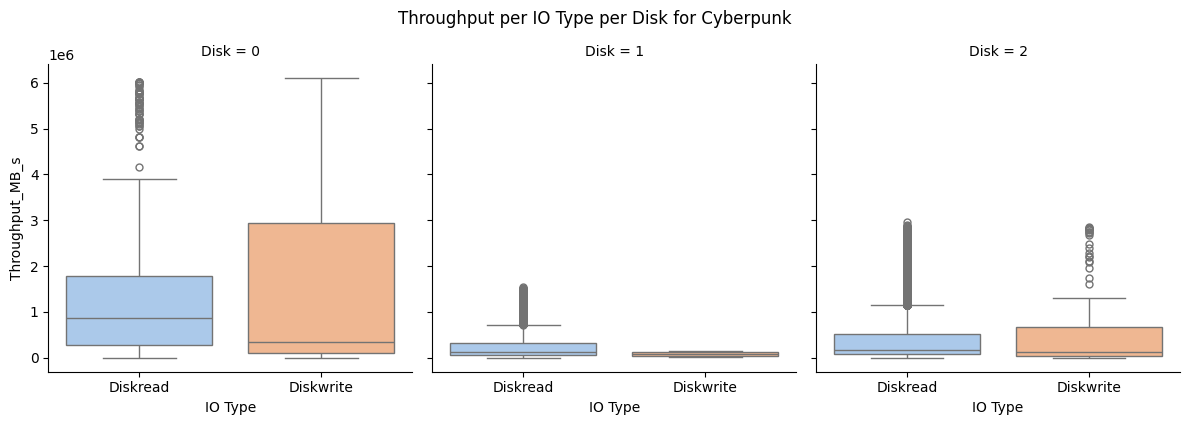

In [16]:
# IO Time per IO Type per Disk
g = sns.catplot(
    x='IO Type', y='Throughput_MB_s', col='Disk',
    data=df, kind='box', col_wrap=3,
    hue='IO Type', legend=False,
    palette='pastel', height=4, aspect=1
)
g.fig.suptitle(f'Throughput per IO Type per Disk for Cyberpunk', y=1.05)
plt.show()
plt.close()

In [ ]:
# Convert nanoseconds to seconds (global duration)
total_duration_sec = (df['End Time'].max() - df['Start Time'].min()) / 1e9

# Group by disk and count IOs
iops_per_disk = df.groupby('Disk').size() / total_duration_sec

# Group by process and count IOs
iops_per_process = df.groupby('Process Name').size() / total_duration_sec

# Group by IO type and count IOs
iops_per_io_type = df.groupby('IO Type').size() / total_duration_sec

# Group by disk and calculate average throughput
avg_mb_throughput_per_disk = df.groupby('Disk')['Throughput_MB_s'].mean()

# Group by process and calculate average throughput
avg_mb_throughput_per_process = df.groupby('Process Name')['Throughput_MB_s'].mean()

# Group by IO type and calculate average throughput
avg_mb_throughput_per_io_type = df.groupby('IO Type')['Throughput_MB_s'].mean()


print("DataFrame after adding IOPS and throughput columns:")
print(f"Total duration of the session: {total_duration_sec:.2f} seconds")
print("\nIOPS per disk:")
print(iops_per_disk)
print("\nIOPS per process:")
print(iops_per_process)
print("\nIOPS per IO type:")
print(iops_per_io_type)
print("\nAverage throughput per disk (GB/s):")
print(avg_mb_throughput_per_disk)
print("\nAverage throughput per process (GB/s):")
print(avg_mb_throughput_per_process)
print("\nAverage throughput per IO type (GB/s):")
print(avg_mb_throughput_per_io_type)

In [ ]:
iops_per_process.sort_values(ascending=False)

In [ ]:
disk_util = df.groupby('Disk')['Disk SrvT'].sum() / df.groupby('Disk')['IO Time'].sum()
print("\nDisk Utilization (Disk SrvT / IO Time):")
print(disk_util)

In [ ]:
# Per-File Access 	Which files are most read/written
perfile_access = df.groupby('Filename').size().sort_values(ascending=False)
perfile_access.head(10)

In [ ]:
df['Log IO Size'] = np.log1p(df['IO Size'])
df['Log IO Time'] = np.log1p(df['IO Time'])
df['Log Disk SrvT'] = np.log1p(df['Disk SrvT'])
df['Log Duration_s'] = np.log1p(df['Duration_s']) 
df['Log Throughput_MB_s'] = np.log1p(df['Throughput_MB_s'])
df['Log QD/C'] = np.log1p(df['QD/C'])

In [ ]:
df.info()

In [ ]:
cols = ['IO Time', 'Disk SrvT', 'IO Size', 'Byte Offset', 'QD/I', 'QD/C', 
        'IBCB', 'IBCA', 'IACB', 'Duration_s', 'Throughput_MB_s', 'Throughput_GB_s']

df[cols].describe()

In [ ]:
print(df.isnull().sum())

In [ ]:
df.head(10)

In [3]:
dataset_path = '/mnt/shared/datasets/game-traces/processed_data/'
output_path = '/home/appliedai/jessica/gaming_tryouts/'

files = [
    "cyberpunk_2077_combined.parquet", "deadlock_60m_2025-04-27_combined.parquet",
    "deadlock_60m_2025-04-28_combined.parquet", "deadlock_60m_2025-04-29_combined.parquet",
    "deadlock_60m_2025-05-01_combined.parquet", "deadlock_60m_2025-05-02_combined.parquet",
    "deadlock_60m_2025-05-03_combined.parquet", "deadlock_60m_2025-05-04_combined.parquet",
    "deadlock_60m_2025-05-05_combined.parquet", "deadlock_60m_2025-05-06_combined.parquet",
    "hogwarts_legacy_combined.parquet", "marvel_rivals_60m_2025-05-06_combined.parquet",
    "overwatch_60m_2025-04-28_combined.parquet", "the_finals_30m_2025-05-01_combined.parquet",
    "the_last_of_us_part_i.parquet"
]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# One variable at a time — example: Disk Service Time
plt.figure(figsize=(8, 4))
sns.boxplot(x=df["Disk SrvT"])
plt.title("Boxplot with IQR Outliers: Disk SrvT")
plt.xlabel("Disk Service Time (ns)")
plt.show()


In [7]:
def data_processiing(df):
    df['IO Type'] = df['IO Type'].str.strip().str.lower().str.capitalize()

    # Convert hexadecimal columns to integers
    df['IO Size'] = df['IO Size'].apply(lambda x: int(x, 16))
    df['Byte Offset'] = df['Byte Offset'].apply(lambda x: int(x, 16))

    # Extract Process Name and PID
    df[['Process Name', 'PID']] = df['Process Name ( PID)'].str.extract(r'(.+)\s*\(\s*(\d+)\)')
    df['PID'] = pd.to_numeric(df['PID'], errors='coerce')

    # --- Feature Engineering ---
    # f.write("Performing feature engineering...\n")
    df['Duration_s'] = df['IO Time'] / 1_000_000_000  # Convert nanoseconds to seconds
    df['Throughput_MB_s'] = (df['IO Size'] / (1024 * 1024)) / (df['Duration_s'])
    df['Throughput_GB_s'] = (df['IO Size'] / (1024**3)) / df['Duration_s']
    df.loc[(df['Duration_s'] == 0) | (df['Throughput_MB_s'] == np.inf), 'Throughput_MB_s'] = 0
    df.loc[(df['Duration_s'] == 0) | (df['Throughput_GB_s'] == np.inf), 'Throughput_GB_s'] = 0

    return df


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def univariate_analysis(df):
    # Set style for consistent visuals
    sns.set_style("whitegrid")

    # --- Numerical Univariate Analysis ---

    # Histograms / KDEs
    numerical_cols = ['IO Time', 'Disk SrvT', 'IO Size', 'Duration_s', 'Throughput_MB_s', 'Throughput_GB_s']
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Histograms and KDEs of Numerical Variables', fontsize=16)
    for ax, col in zip(axes.flatten(), numerical_cols):
        sns.histplot(data=df, x=col, bins=50, kde=True, ax=ax)
        ax.set_title(f'{col} Distribution')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Boxplots for Outliers
    outlier_cols = ['Throughput_MB_s', 'IO Size', 'Disk SrvT']
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Boxplots to Identify Outliers', fontsize=16)
    for ax, col in zip(axes, outlier_cols):
        sns.boxplot(data=df, y=col, ax=ax)
        ax.set_title(f'Outliers in {col}')
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()

    # Distribution Fit for IO Time (Log-Normal)
    io_time_log = np.log1p(df['IO Time'])  # log1p to handle zeros
    params = stats.lognorm.fit(io_time_log, floc=0)
    x = np.linspace(io_time_log.min(), io_time_log.max(), 100)
    pdf = stats.lognorm.pdf(x, *params)
    plt.figure(figsize=(8, 6))
    plt.hist(io_time_log, bins=50, density=True, alpha=0.5, label='Histogram')
    plt.plot(x, pdf, 'r-', lw=2, label='Log-Normal Fit')
    plt.title('Log-Normal Distribution Fit for IO Time')
    plt.xlabel('Log(IO Time + 1)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    print(f"Log-Normal Fit Parameters for IO Time: {params}")

    # --- Categorical Univariate Analysis ---

    # Value Counts
    categorical_cols = ['IO Type', 'Disk', 'Filename', 'Process Name']
    for col in categorical_cols:
        if col == "Filename":
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts().head(10))
        else:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())

    # Pie Charts for Categorical Variables in 2x2 subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Pie Charts of Categorical Variables', fontsize=16)
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        plot_data = df.copy()

        # Truncate long filenames for display
        if col == 'Filename':
            plot_data['Filename'] = plot_data['Filename'].str.slice(0, 15) + '...'

        pie_data = plot_data[col].value_counts()
        axes[i].pie(
            pie_data, 
            labels=pie_data.index, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=sns.color_palette("Pastel1")
        )
        axes[i].set_title(f'{col}', fontsize=12)
        axes[i].axis('equal')  # Equal aspect ratio ensures the pie chart is circular

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # g = sns.catplot(
    #     x='IO Type', y='IO Time', col='Disk',
    #     data=df, kind='box', col_wrap=3,
    #     palette='pastel', height=4, aspect=1
    # )
    # g.fig.suptitle(f'IO Time per IO Type per Disk for {session_name}', y=1.05)
    # plt.show()
    
    # # Bar Plots for Frequency
    # fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    # fig.suptitle('Bar Plots of Categorical Variables', fontsize=16)
    # axes = axes.flatten()
    # for ax, col in zip(axes, categorical_cols):
 
    #     plot_data = df.copy()

    #     # Truncate filename strings for display
    #     if col == 'Filename':
    #         plot_data['Filename'] = plot_data['Filename'].str.slice(0, 15) + '...'

    #     sns.countplot(data=plot_data, x=col, ax=ax, order=plot_data[col].value_counts().index)
    #     ax.set_title(f'Frequency of {col}')
    #     ax.set_xlabel(col)
    #     ax.set_ylabel('Count')
    #     plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.show()
    


Performing univariate analysis for cyberpunk_2077_combined.parquet...
Loaded DataFrame with 281026 rows and 16 columns.


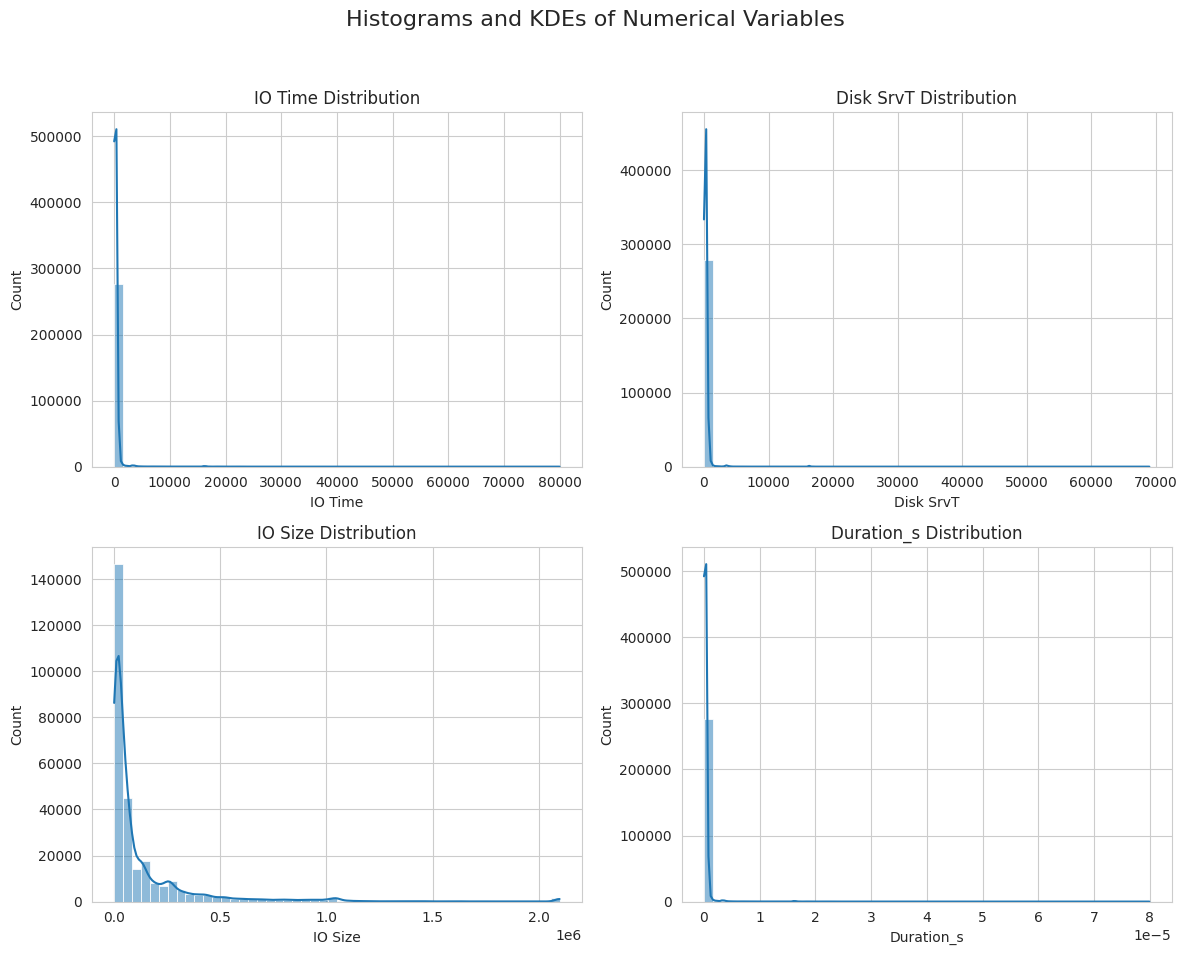

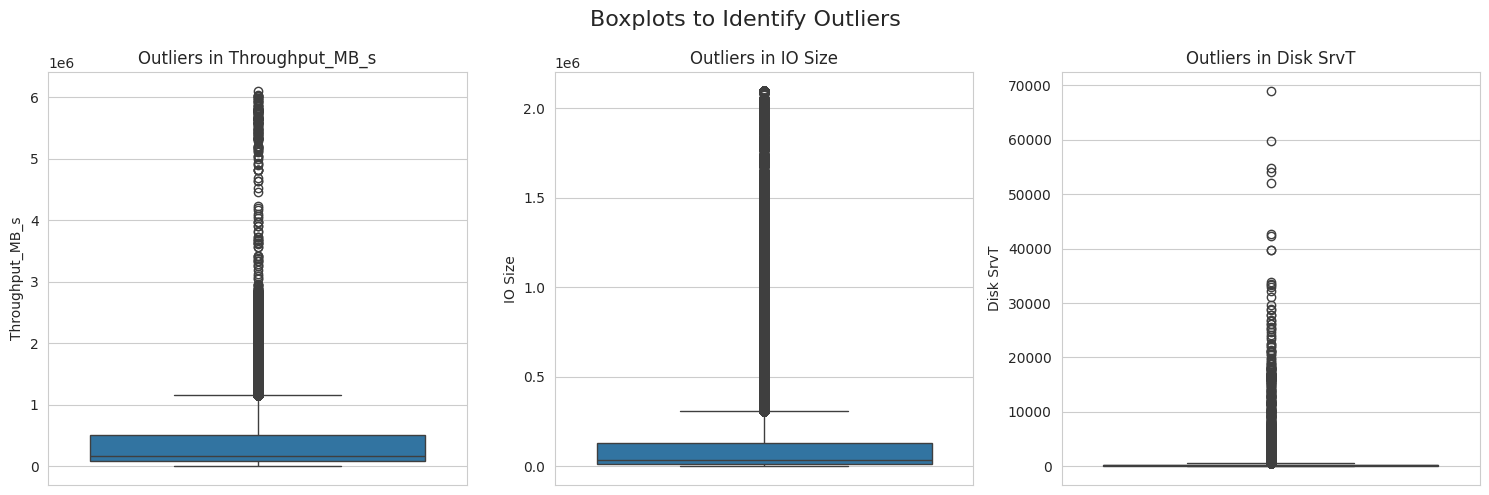

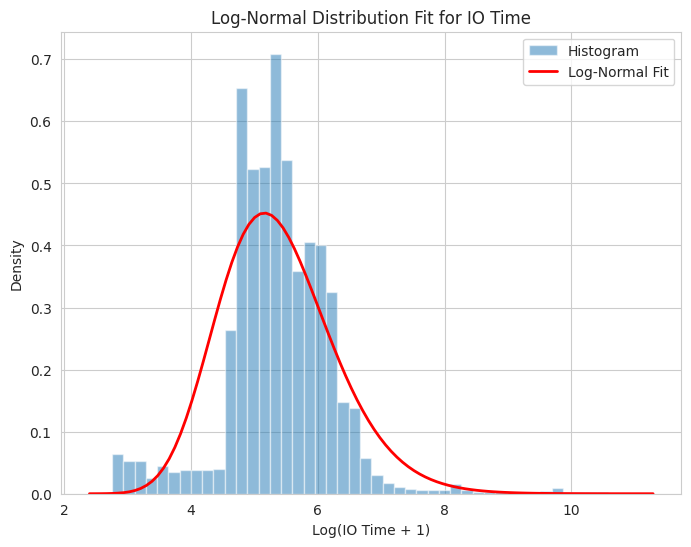

Log-Normal Fit Parameters for IO Time: (np.float64(0.16860455985438333), 0, np.float64(5.3057823948015335))

Value Counts for IO Type:
IO Type
Diskread     280455
Diskwrite       571
Name: count, dtype: int64

Value Counts for Disk:
Disk
2    170389
1     93056
0     17581
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Program Files (x86)\Steam\steamapps\common\Cyberpunk 2077\archive\pc\content\basegame_3_nightcity.archive     70937
C:\Program Files (x86)\Steam\steamapps\common\Cyberpunk 2077\archive\pc\content\basegame_4_appearance.archive    60987
D:\SteamLibrary\steamapps\common\Cyberpunk 2077\archive\pc\Content\basegame_3_nightcity.archive                  20169
D:\SteamLibrary\steamapps\Common\Cyberpunk 2077\archive\pc\content\basegame_3_nightcity.archive                  16358
D:\SteamLibrary\steamapps\common\Cyberpunk 2077\archive\pc\Content\basegame_4_appearance.archive                 11166
D:\SteamLibrary\steamapps\Common\Cyberpunk 2077\archive\pc\content\b

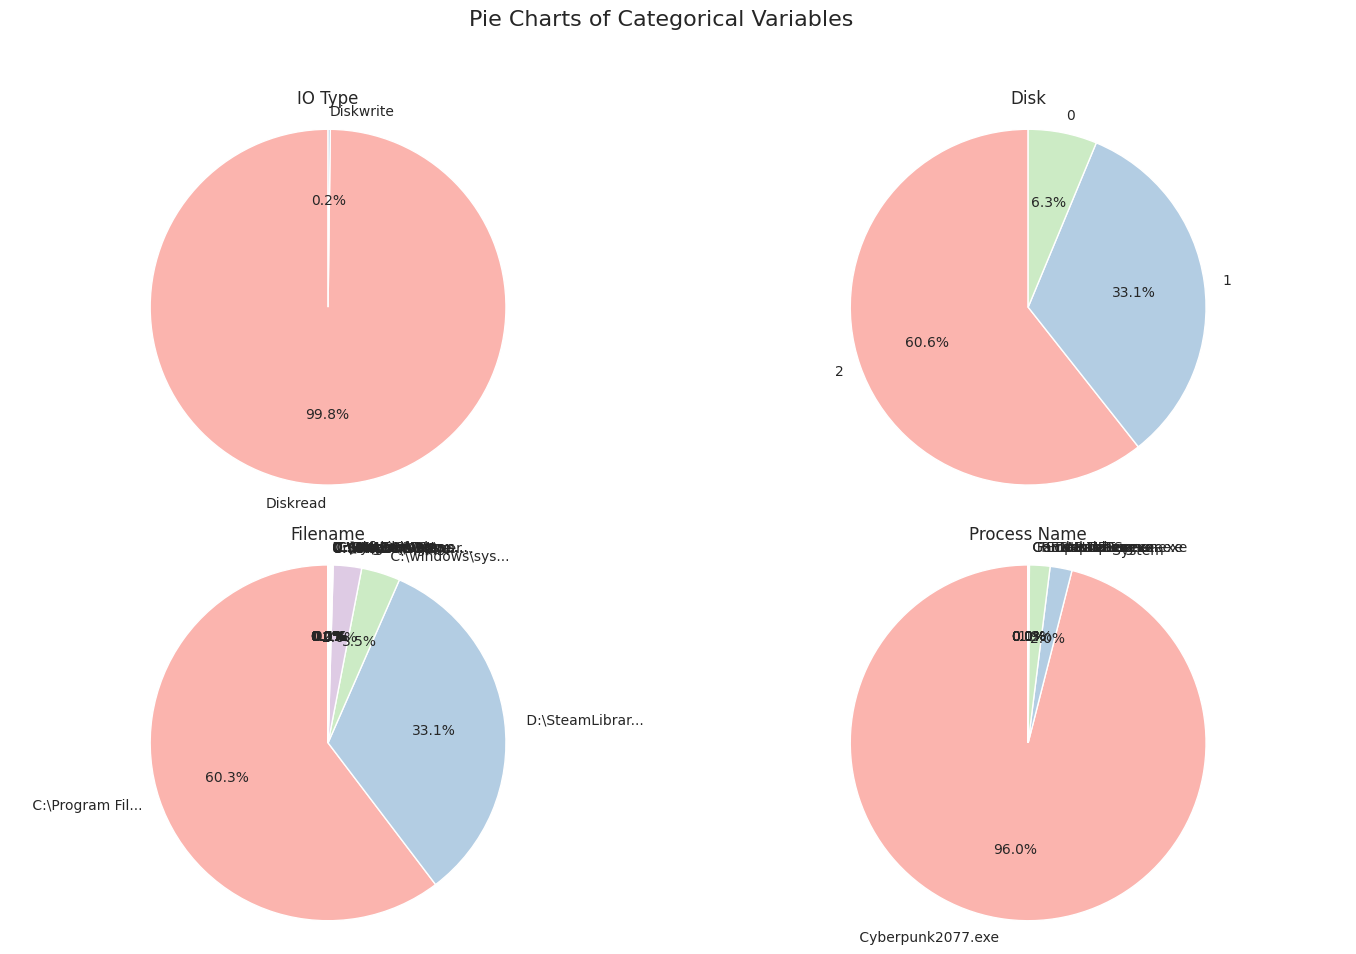


Performing univariate analysis for deadlock_60m_2025-04-27_combined.parquet...
Loaded DataFrame with 459 rows and 16 columns.


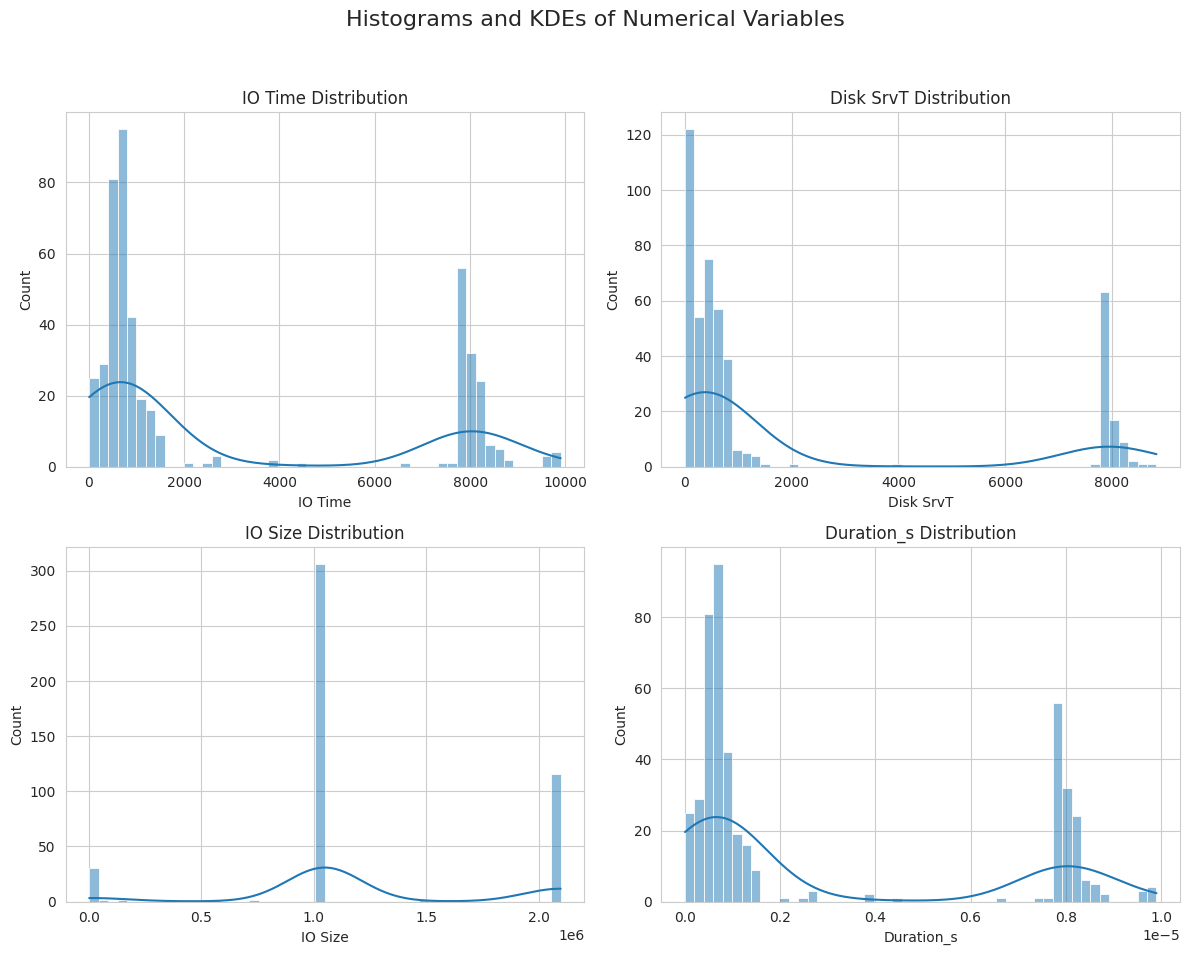

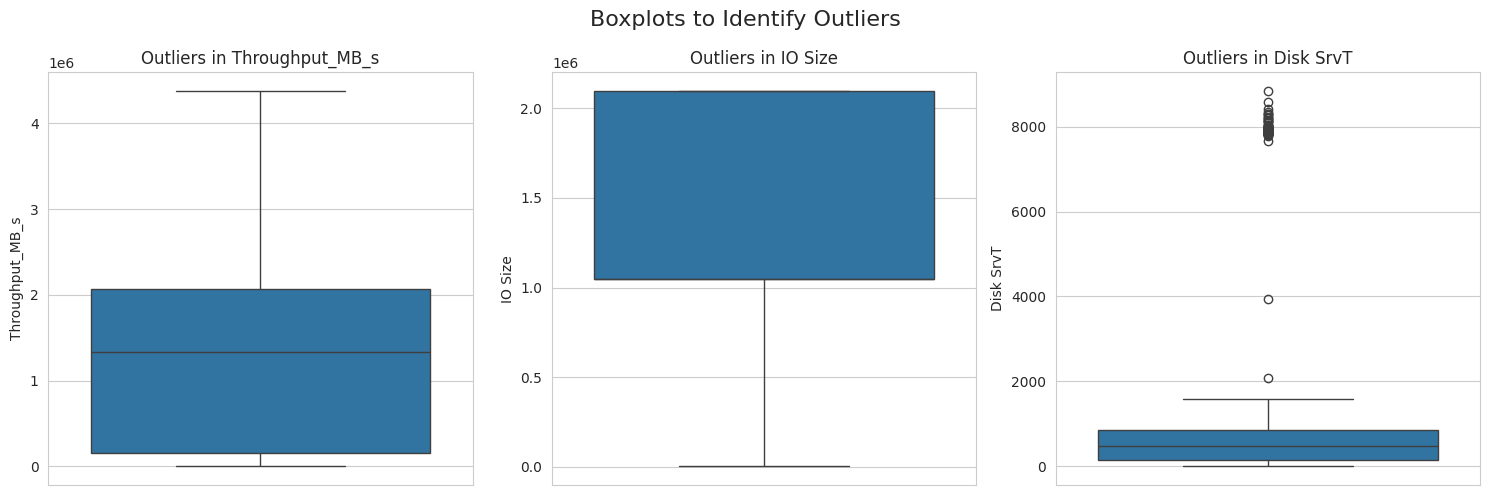

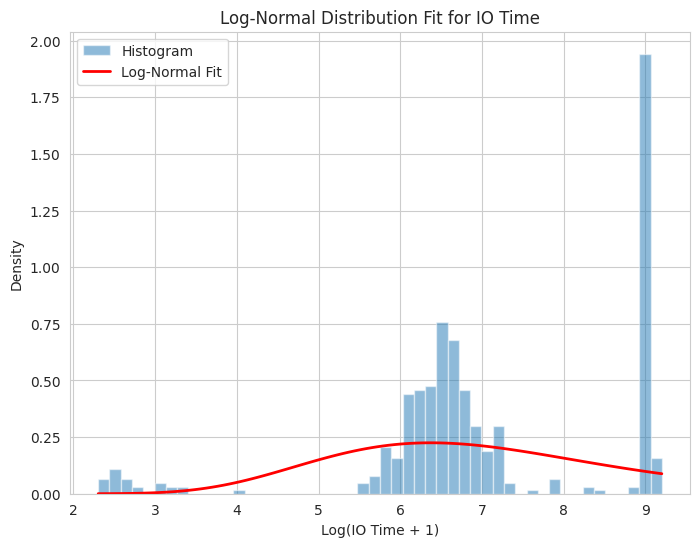

Log-Normal Fit Parameters for IO Time: (np.float64(0.2686178069661499), 0, np.float64(6.848806225632622))

Value Counts for IO Type:
IO Type
Diskread     432
Diskwrite     27
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    459
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_026.vpk    44
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_163.vpk    20
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_041.vpk    19
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_058.vpk    19
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_079.vpk    15
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_001.vpk    15
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_073.vpk    13
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_117.vpk 

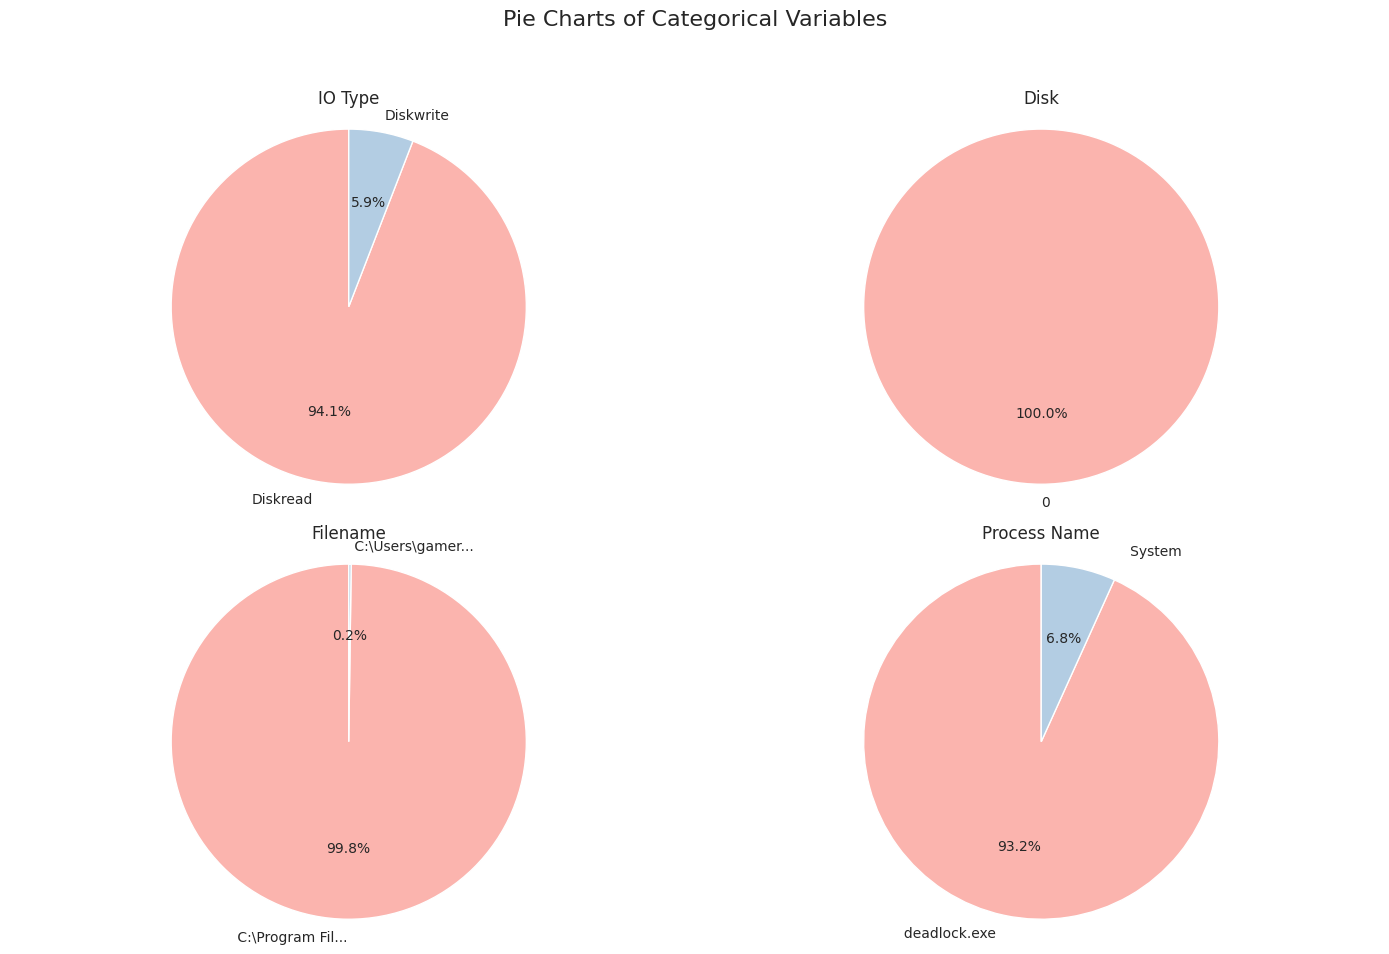


Performing univariate analysis for deadlock_60m_2025-04-28_combined.parquet...
Loaded DataFrame with 11682 rows and 16 columns.


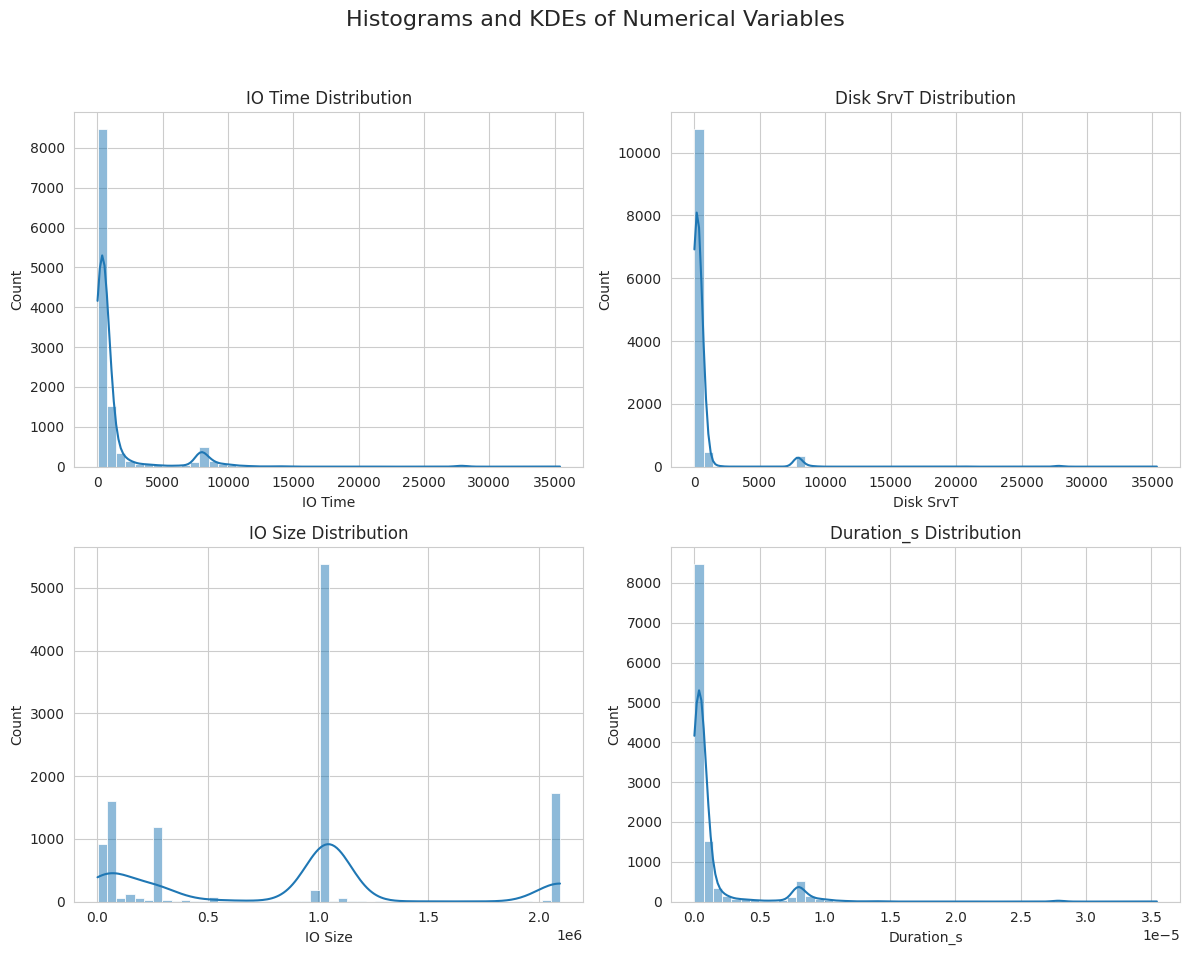

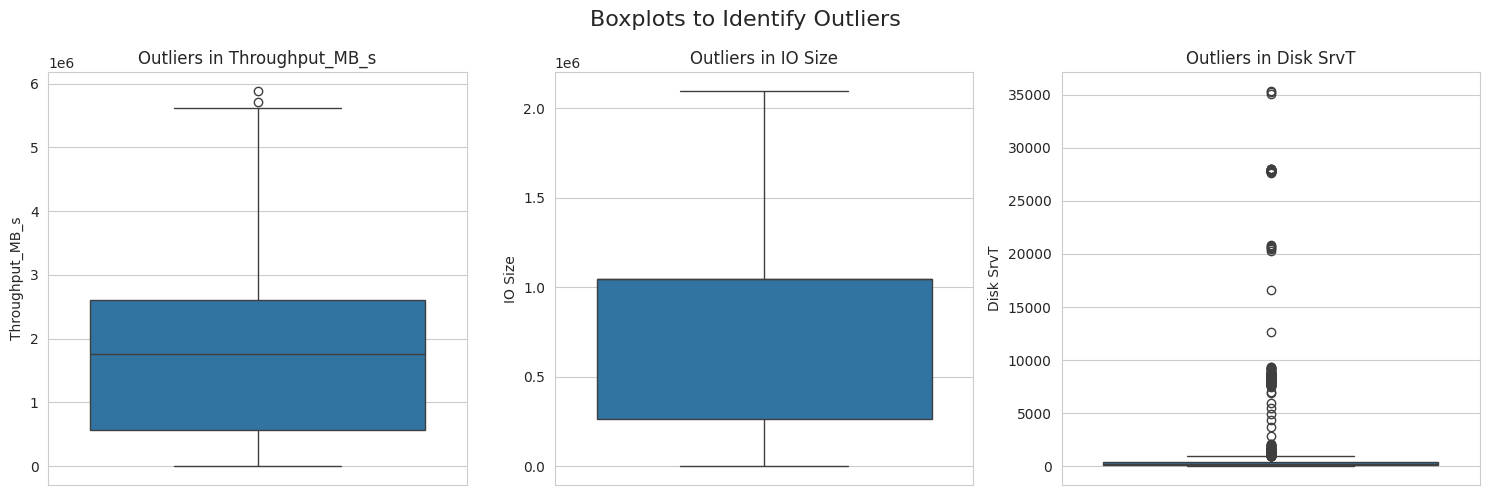

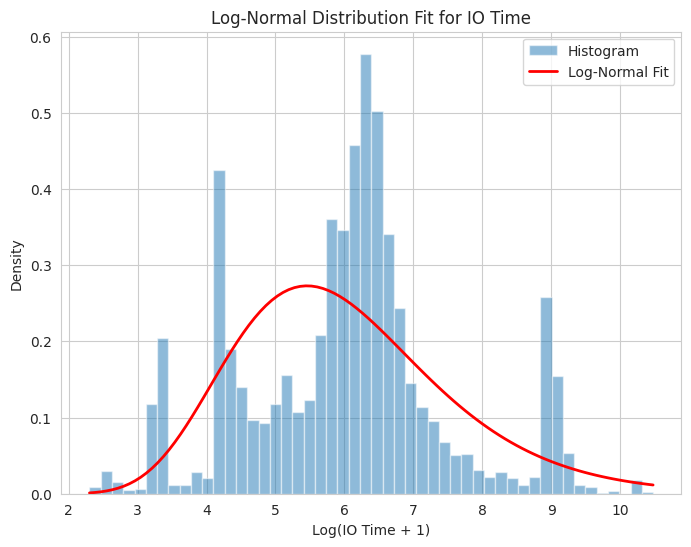

Log-Normal Fit Parameters for IO Time: (np.float64(0.25901627007991873), 0, np.float64(5.835978772116633))

Value Counts for IO Type:
IO Type
Diskread     10447
Diskwrite     1235
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    11682
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\fa7ba91cd12b854d.nvph                               1053
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\maps\dl_midtown.vpk          553
C:\Users\gamer\AppData\Local\Temp\Tmp9110.tmp                                                    271
C:\Users\gamer\AppData\Local\Temp\Tmp3A72.tmp                                                    271
C:\Users\gamer\AppData\Local\Temp\Tmp37AD.tmp                                                    159
C:\Users\gamer\AppData\Local\Temp\Tmp8E4B.tmp                                                    159
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\bin\win64\v8.dll         

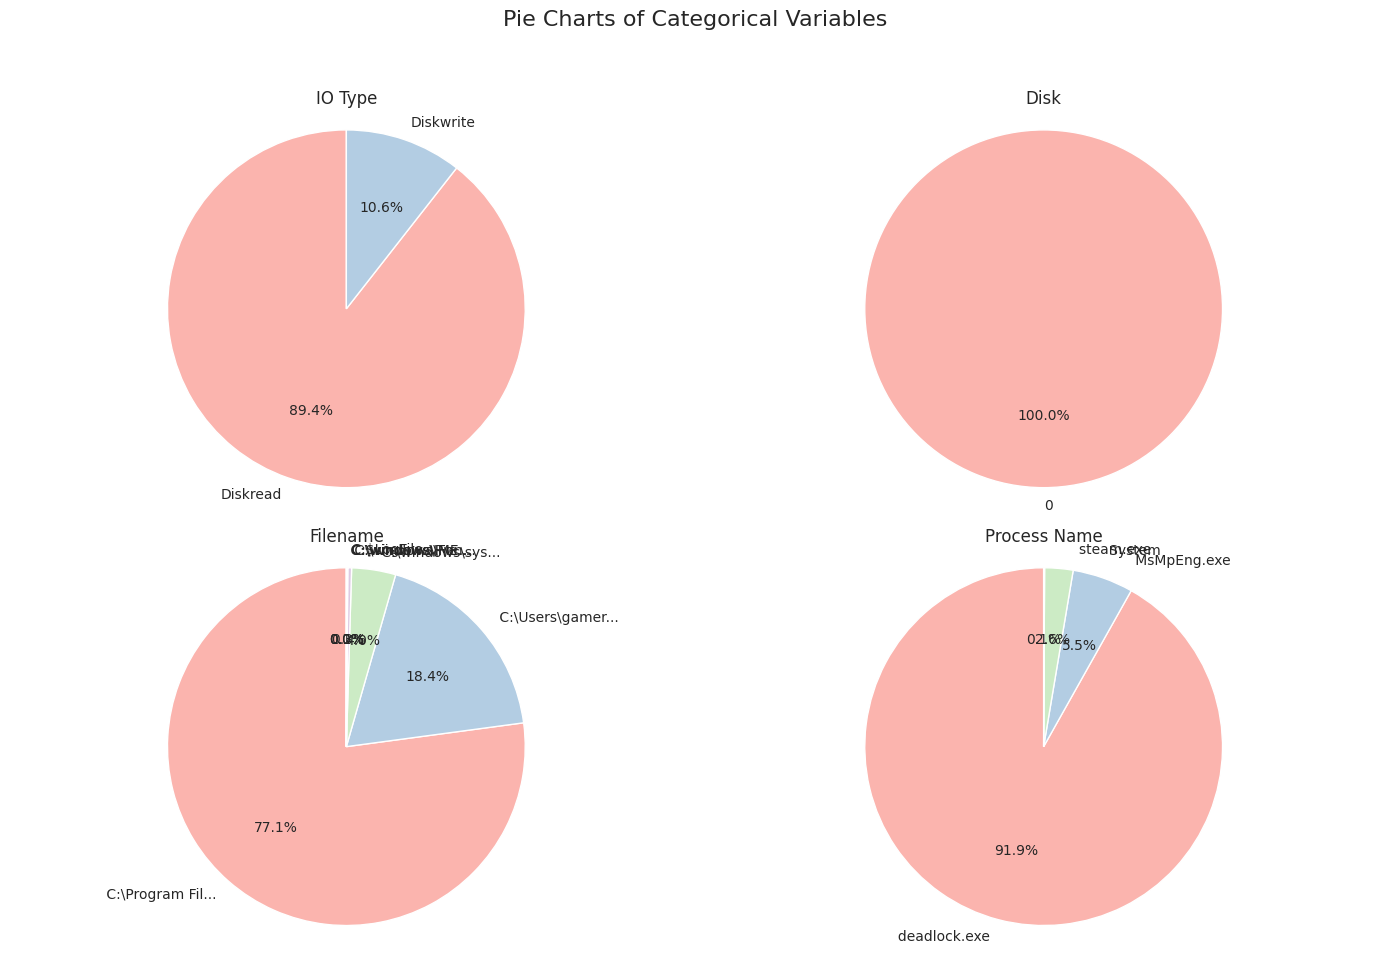


Performing univariate analysis for deadlock_60m_2025-04-29_combined.parquet...
Loaded DataFrame with 14345 rows and 16 columns.


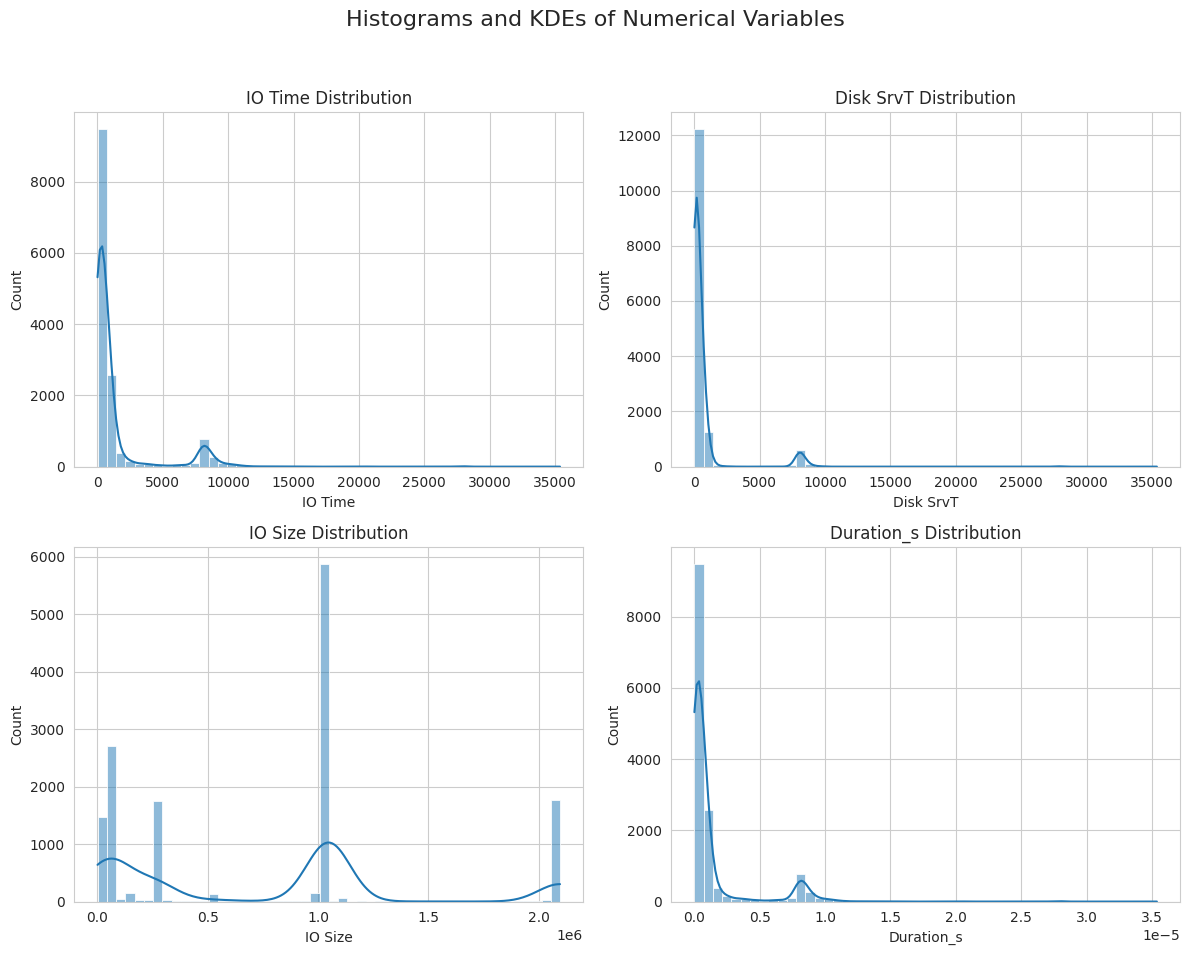

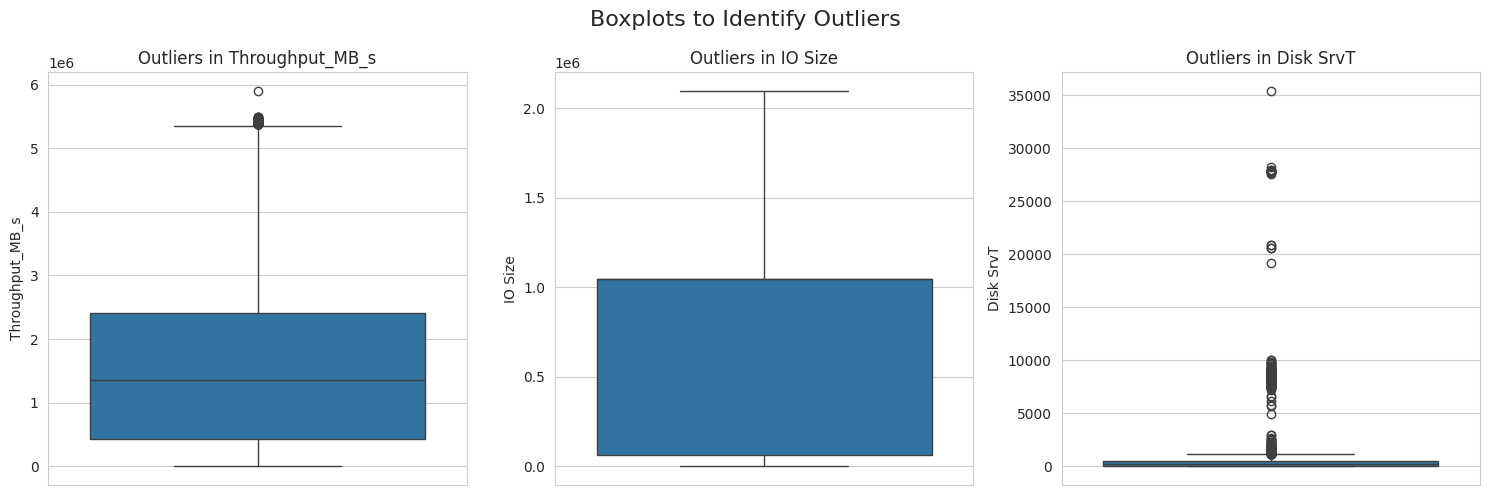

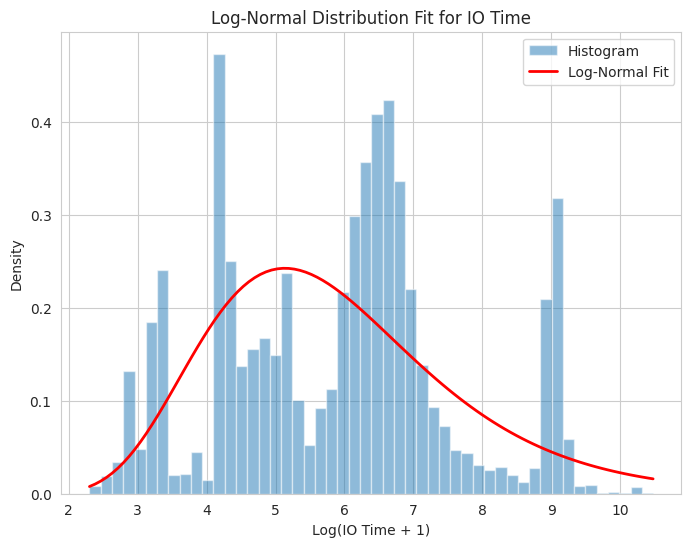

Log-Normal Fit Parameters for IO Time: (np.float64(0.30555374236168364), 0, np.float64(5.638925015275999))

Value Counts for IO Type:
IO Type
Diskread     12465
Diskwrite     1880
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    14345
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\fa7ba91cd12b854d.nvph                          1832
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\maps\dl_midtown.vpk     568
C:\Users\gamer\AppData\Local\Temp\Tmp24E.tmp                                                271
C:\Users\gamer\AppData\Local\Temp\Tmp61CA.tmp                                               271
C:\Users\gamer\AppData\Local\Temp\Tmp853F.tmp                                               271
C:\windows\system32\setupapi.dll                                                            247
C:\Users\gamer\AppData\Local\Temp\TmpFF89.tmp                                               159
C:\Users\gamer\AppD

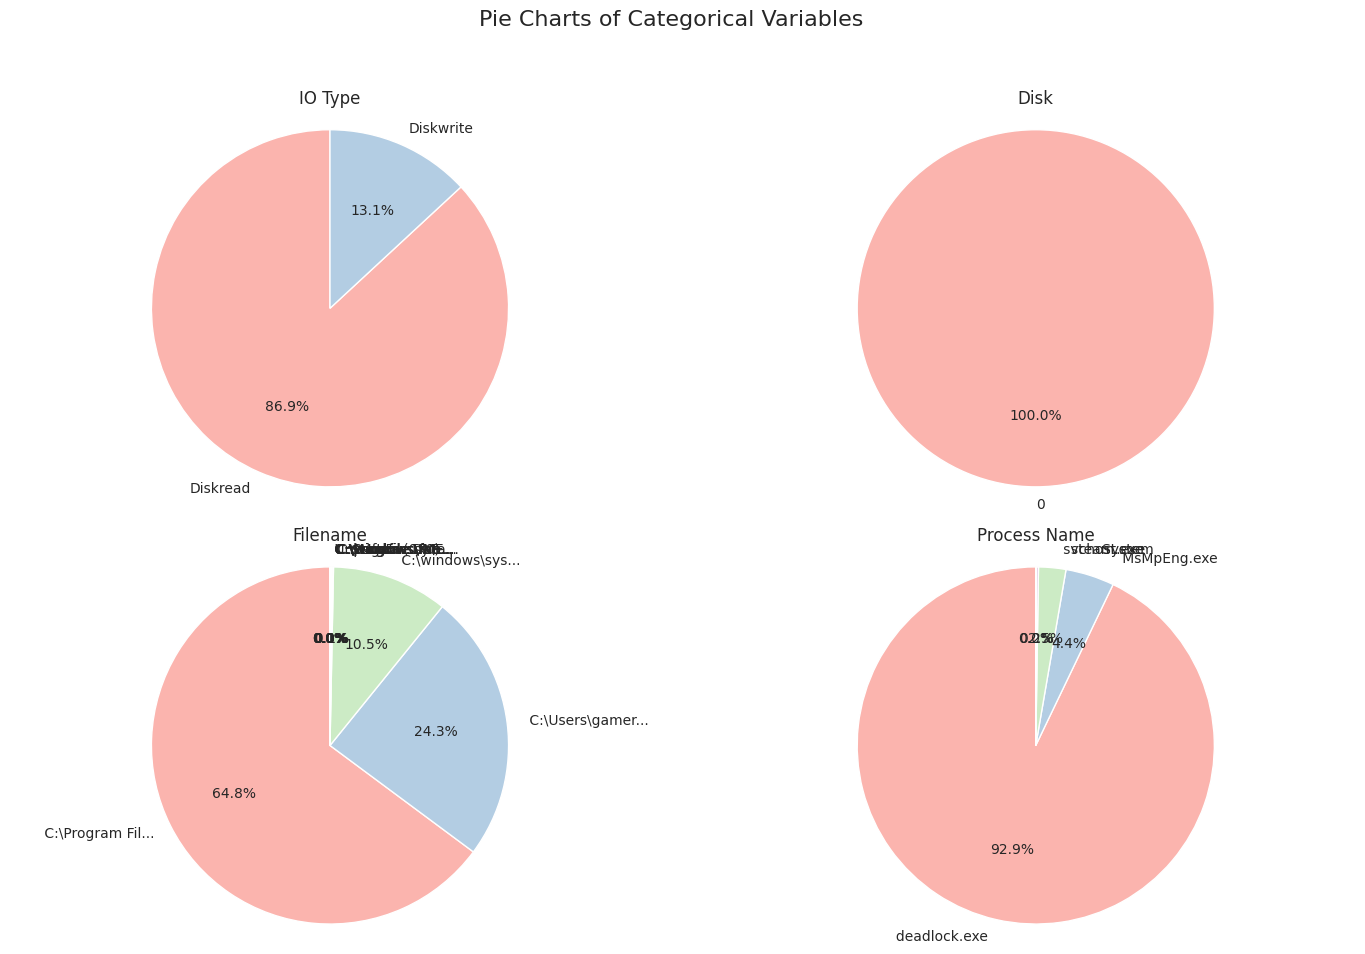


Performing univariate analysis for deadlock_60m_2025-05-01_combined.parquet...
Loaded DataFrame with 1119 rows and 16 columns.


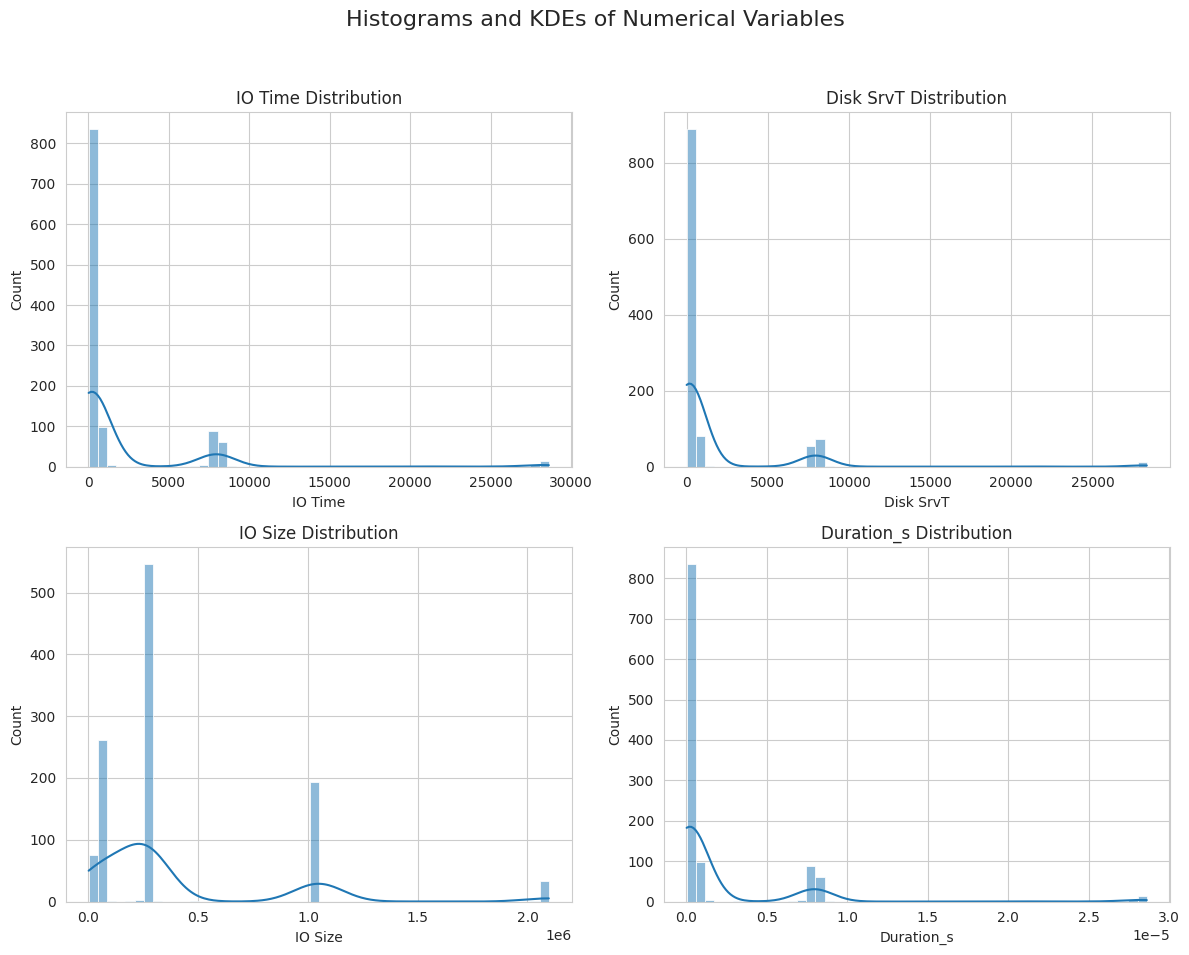

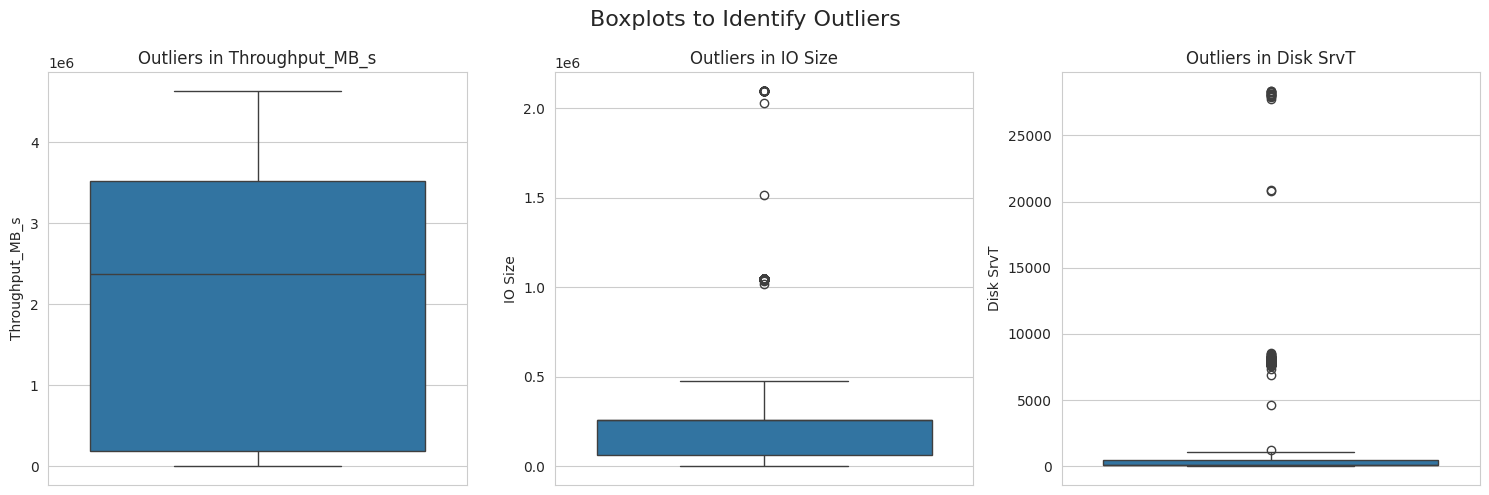

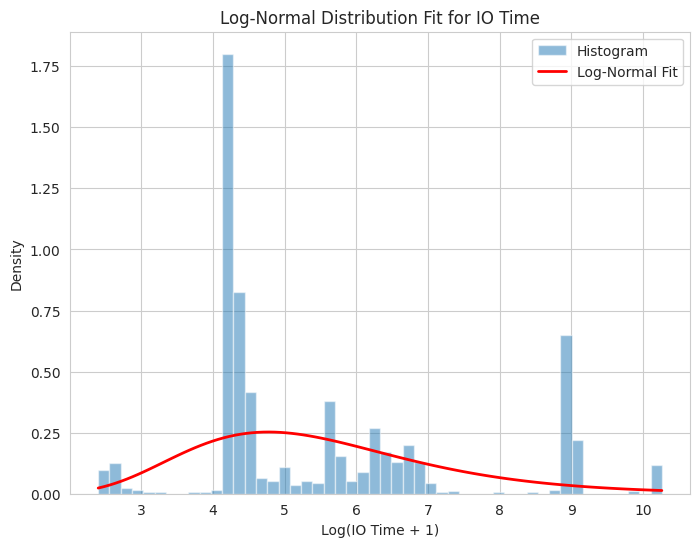

Log-Normal Fit Parameters for IO Time: (np.float64(0.3149478583206451), 0, np.float64(5.269776474375519))

Value Counts for IO Type:
IO Type
Diskwrite    603
Diskread     516
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    1119
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\Temp\Tmp927F.tmp                                        271
C:\Users\gamer\AppData\Local\Temp\Tmp8FBA.tmp                                        159
C:\Users\gamer\AppData\Local\Temp\Tmp9136.tmp                                         68
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\fa7ba91cd12b854d.nvph                     66
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_026.vpk     53
C:\Users\gamer\AppData\Local\Temp\Tmp9529.tmp                                         52
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_060.vpk     15
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_

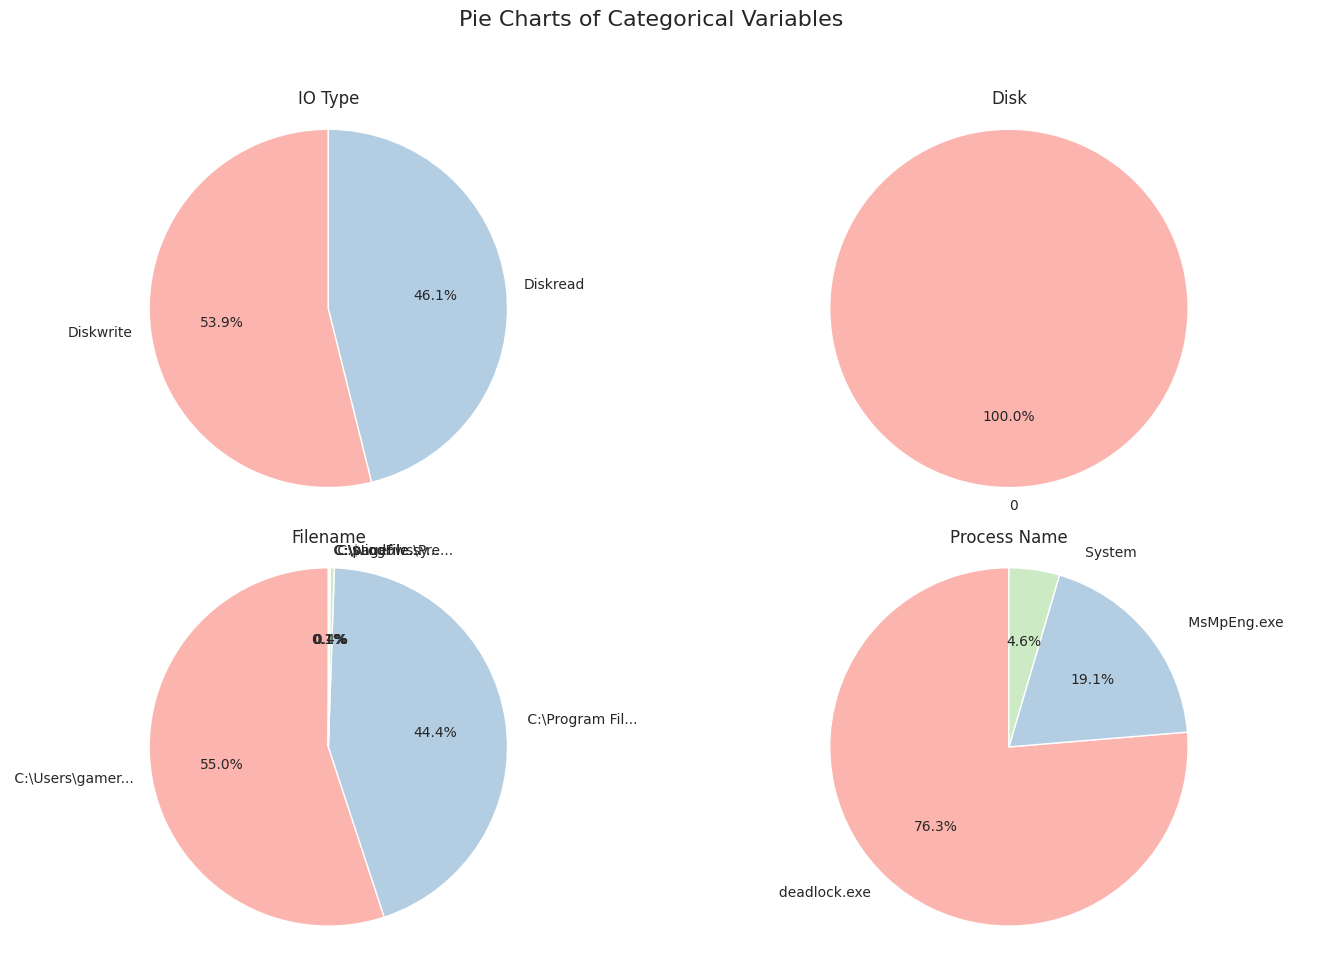


Performing univariate analysis for deadlock_60m_2025-05-02_combined.parquet...
Loaded DataFrame with 1211 rows and 16 columns.


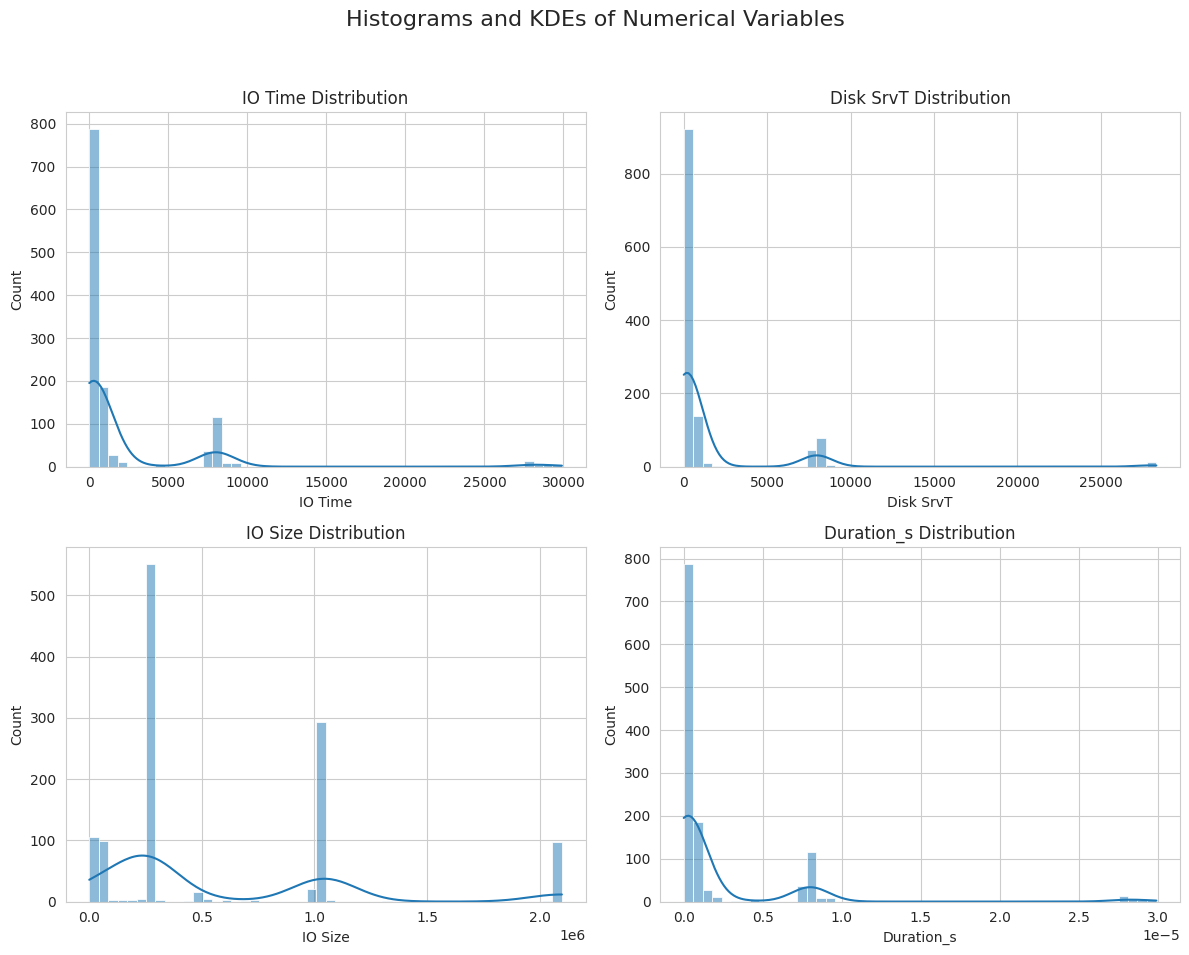

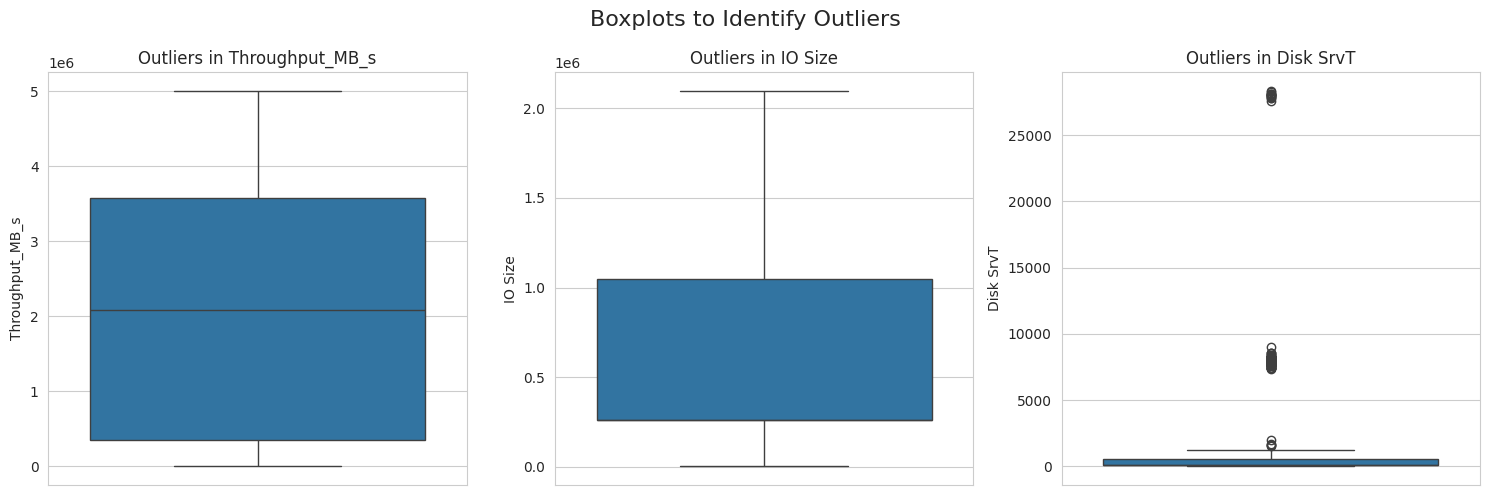

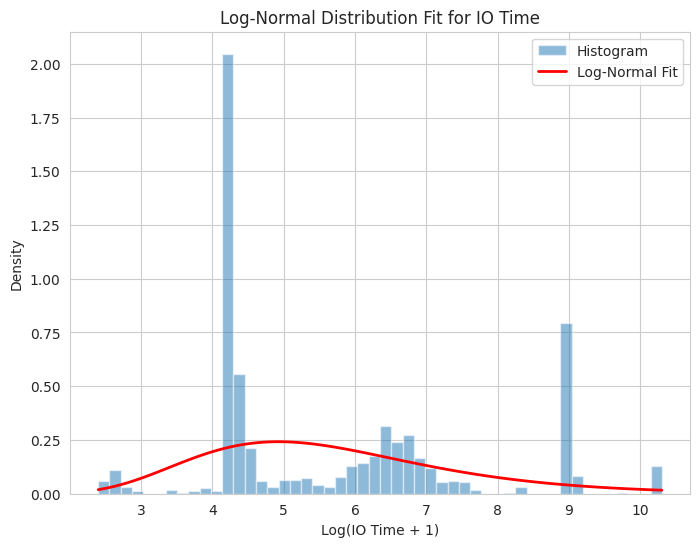

Log-Normal Fit Parameters for IO Time: (np.float64(0.31828536184325734), 0, np.float64(5.4494408189381245))

Value Counts for IO Type:
IO Type
Diskwrite    615
Diskread     596
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    1211
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\Temp\Tmp9D98.tmp                                                     271
C:\Users\gamer\AppData\Local\Temp\Tmp9A27.tmp                                                     159
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\maps\new_player_basics.vpk     82
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\fa7ba91cd12b854d.nvph                                  72
C:\Users\gamer\AppData\Local\Temp\Tmp9C30.tmp                                                      68
C:\Users\gamer\AppData\Local\Temp\TmpA10D.tmp                                                      52
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_031.vpk  

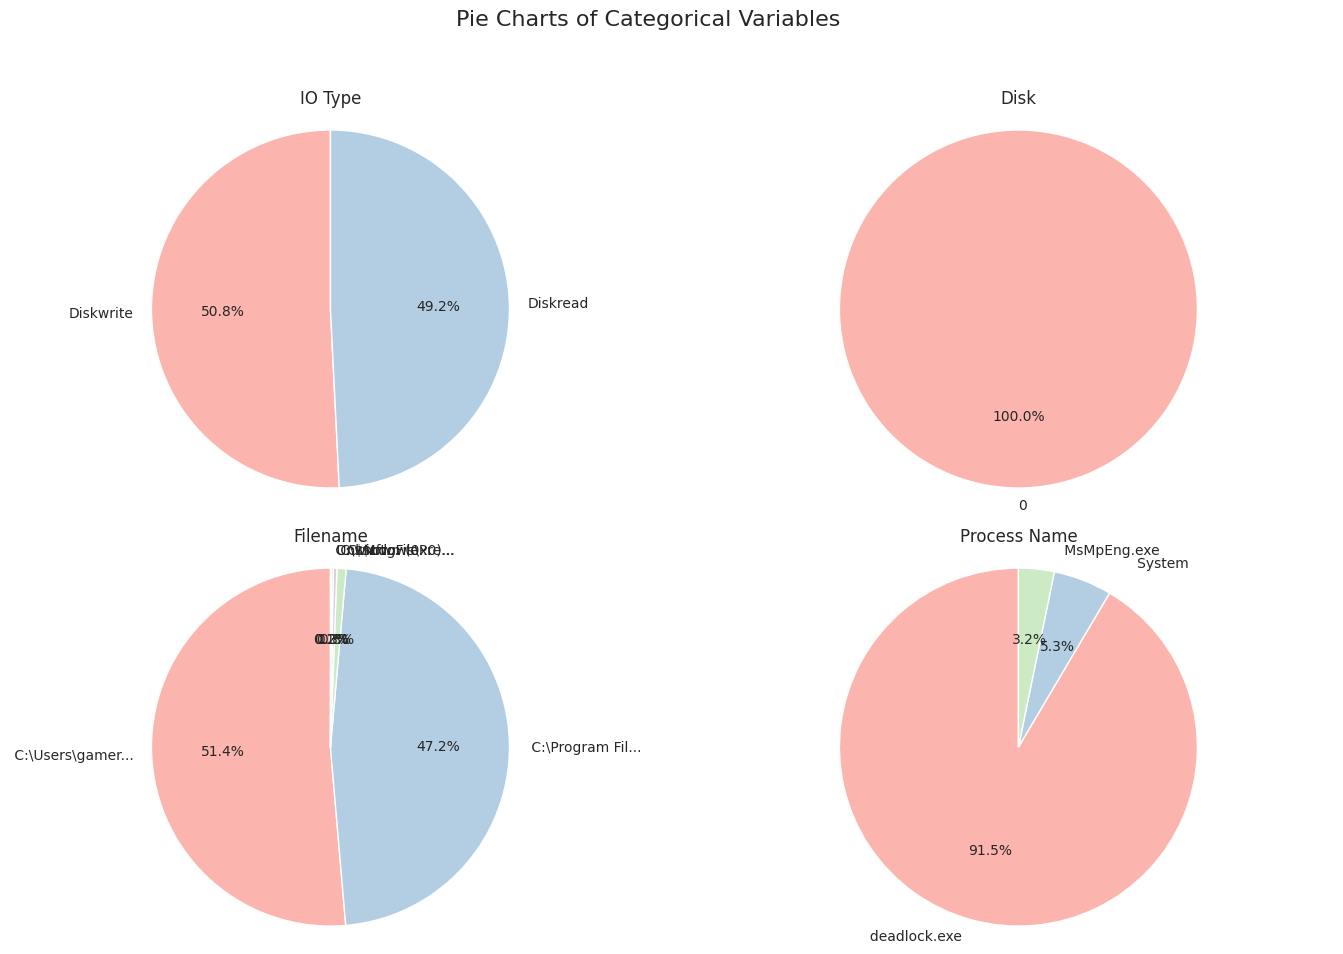


Performing univariate analysis for deadlock_60m_2025-05-03_combined.parquet...
Loaded DataFrame with 2107 rows and 16 columns.


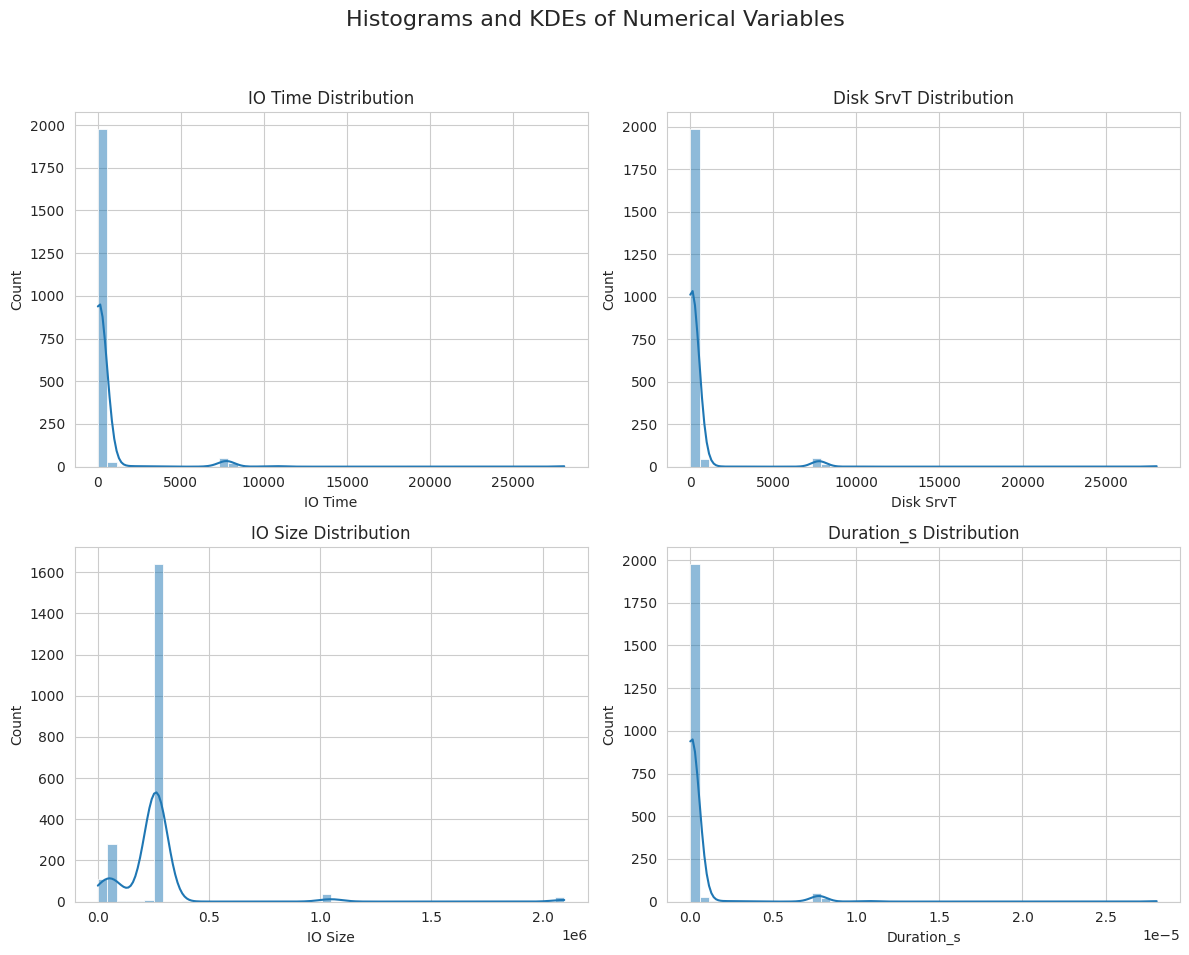

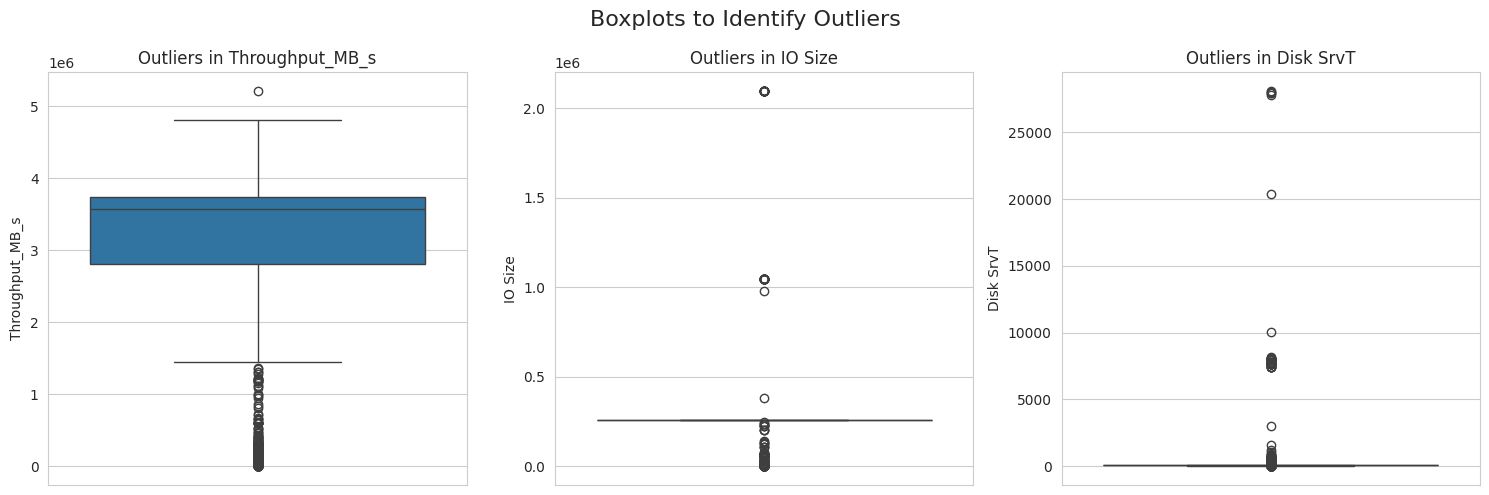

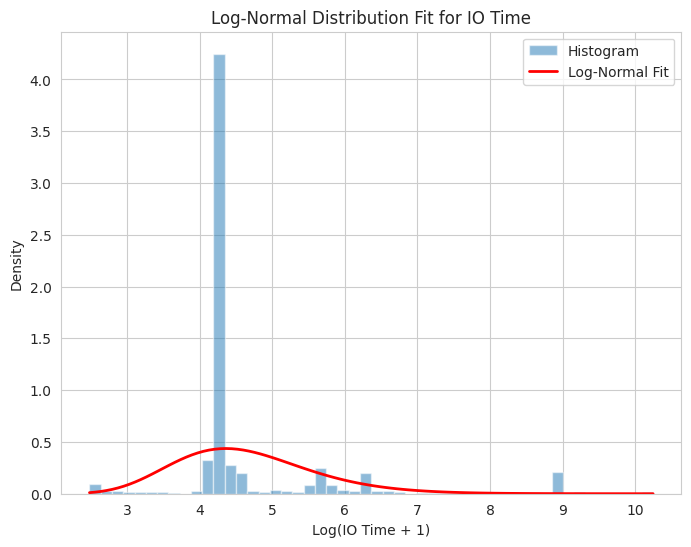

Log-Normal Fit Parameters for IO Time: (np.float64(0.2051739653843427), 0, np.float64(4.549271752174124))

Value Counts for IO Type:
IO Type
Diskwrite    1735
Diskread      372
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    2107
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\Temp\TmpE77.tmp     271
C:\Users\gamer\AppData\Local\Temp\Tmp336D.tmp    271
C:\Users\gamer\AppData\Local\Temp\TmpE9FC.tmp    271
C:\Users\gamer\AppData\Local\Temp\TmpBB2.tmp     159
C:\Users\gamer\AppData\Local\Temp\Tmp30E7.tmp    159
C:\Users\gamer\AppData\Local\Temp\TmpE747.tmp    159
C:\Users\gamer\AppData\Local\Temp\TmpE8B3.tmp     68
C:\Users\gamer\AppData\Local\Temp\Tmp3234.tmp     68
C:\Users\gamer\AppData\Local\Temp\TmpD2E.tmp      68
C:\Users\gamer\AppData\Local\Temp\TmpEC58.tmp     52
Name: count, dtype: int64

Value Counts for Process Name:
Process Name
deadlock.exe     1757
 MsMpEng.exe      279
      System       71
Name: count, dtype: int64


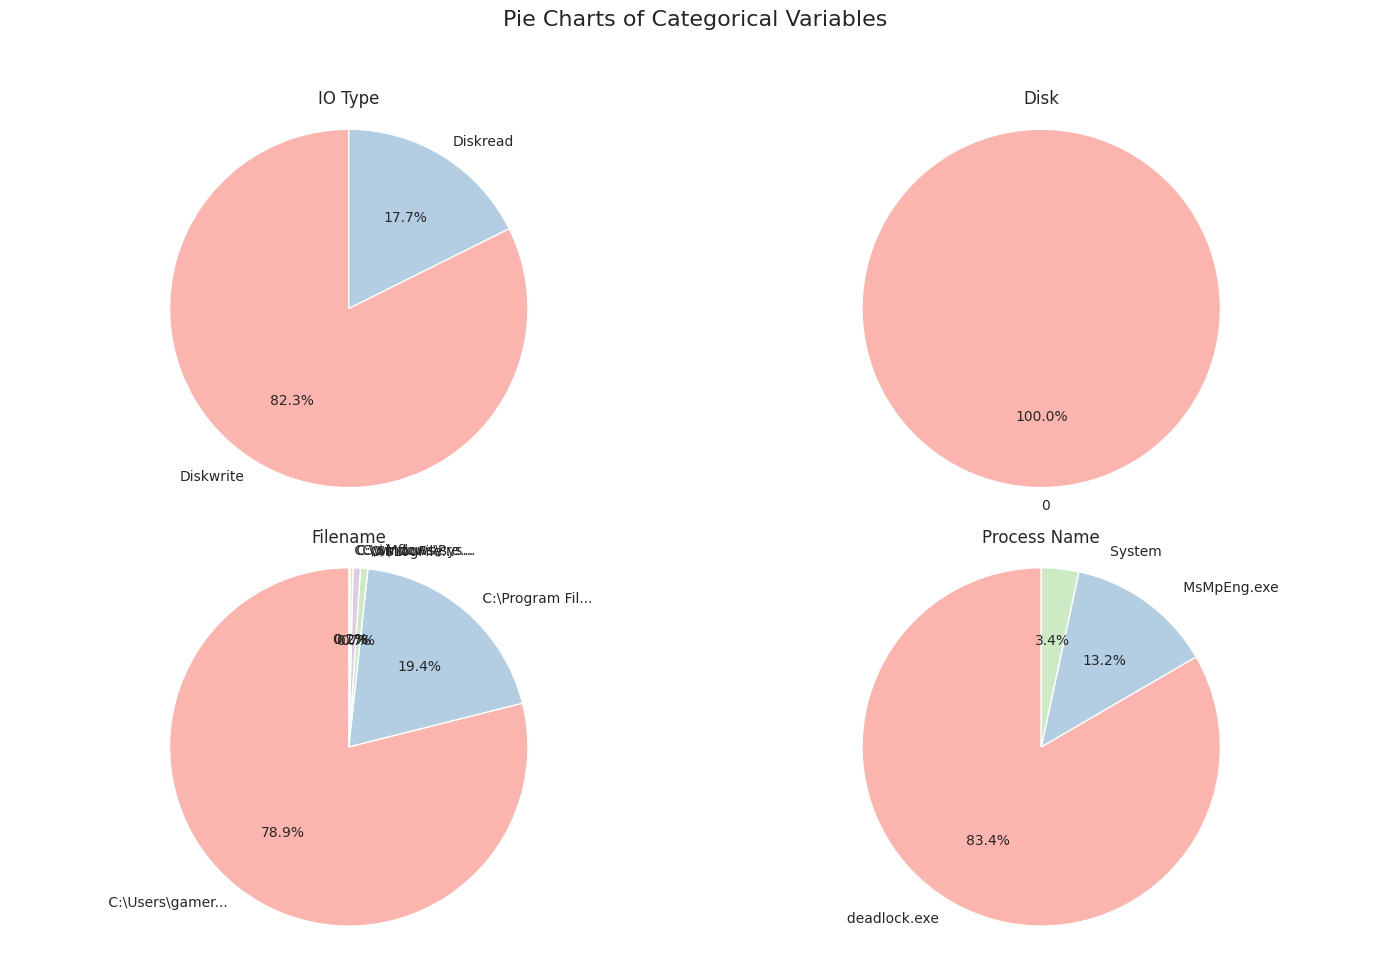


Performing univariate analysis for deadlock_60m_2025-05-04_combined.parquet...
Loaded DataFrame with 924 rows and 16 columns.


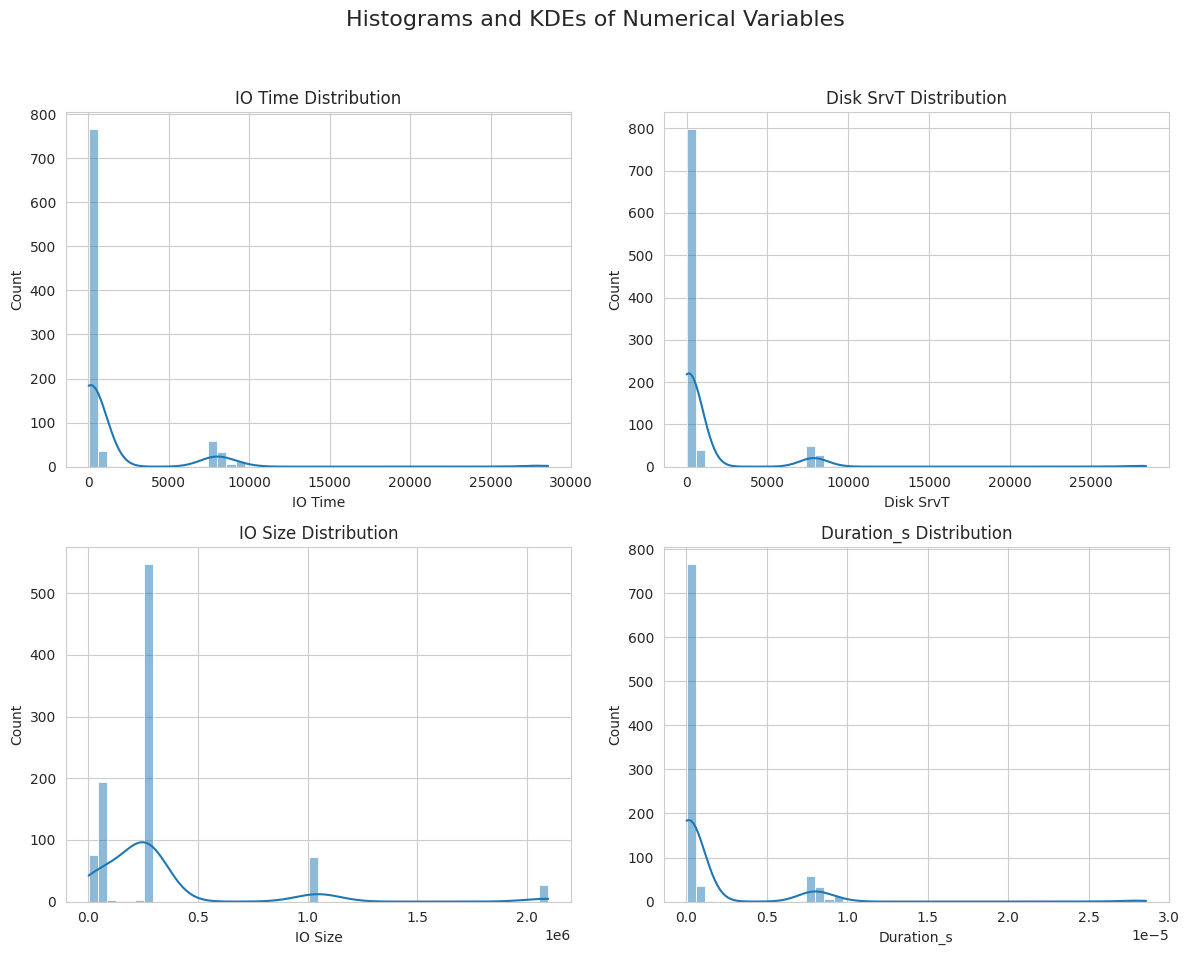

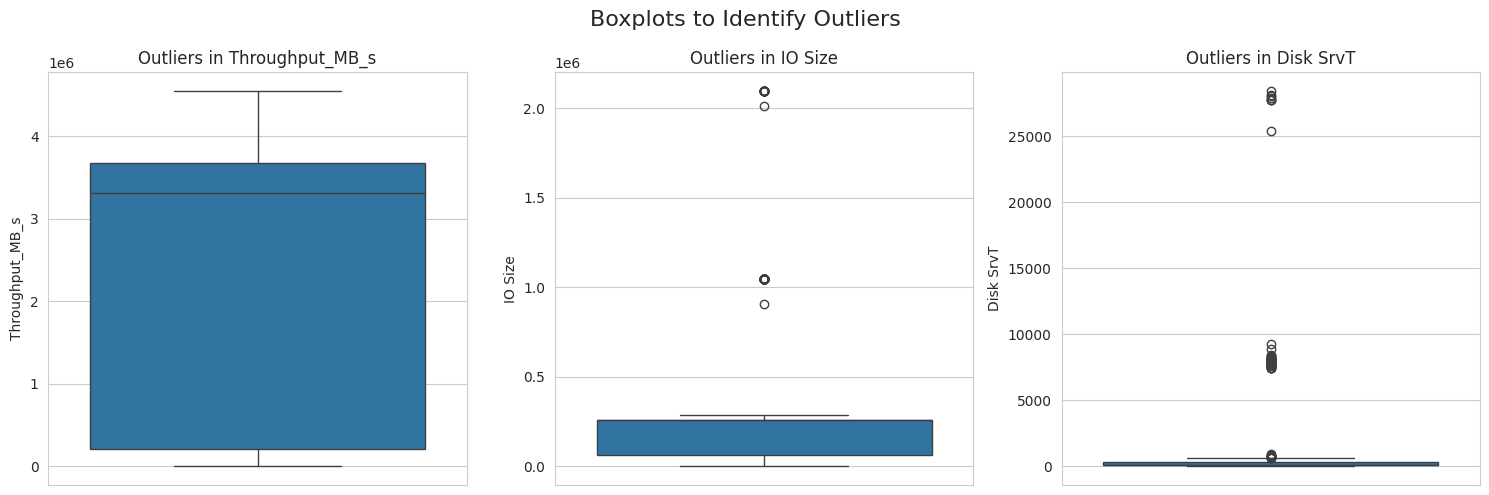

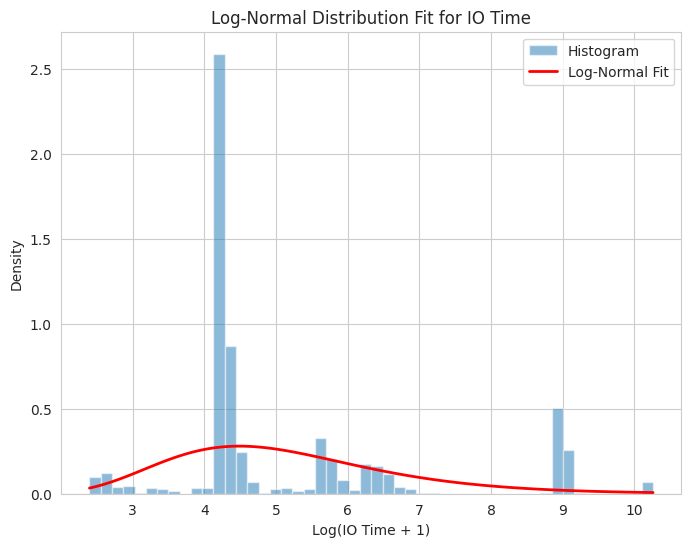

Log-Normal Fit Parameters for IO Time: (np.float64(0.3033050000212964), 0, np.float64(4.921572105741826))

Value Counts for IO Type:
IO Type
Diskwrite    613
Diskread     311
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    924
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\Temp\Tmp9B8F.tmp                                        271
C:\Users\gamer\AppData\Local\Temp\Tmp98BA.tmp                                        159
C:\Users\gamer\AppData\Local\Temp\Tmp9A36.tmp                                         68
C:\Users\gamer\AppData\Local\Temp\Tmp9E29.tmp                                         52
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_038.vpk     18
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\fa7ba91cd12b854d.nvph                     15
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_006.vpk     10
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel        

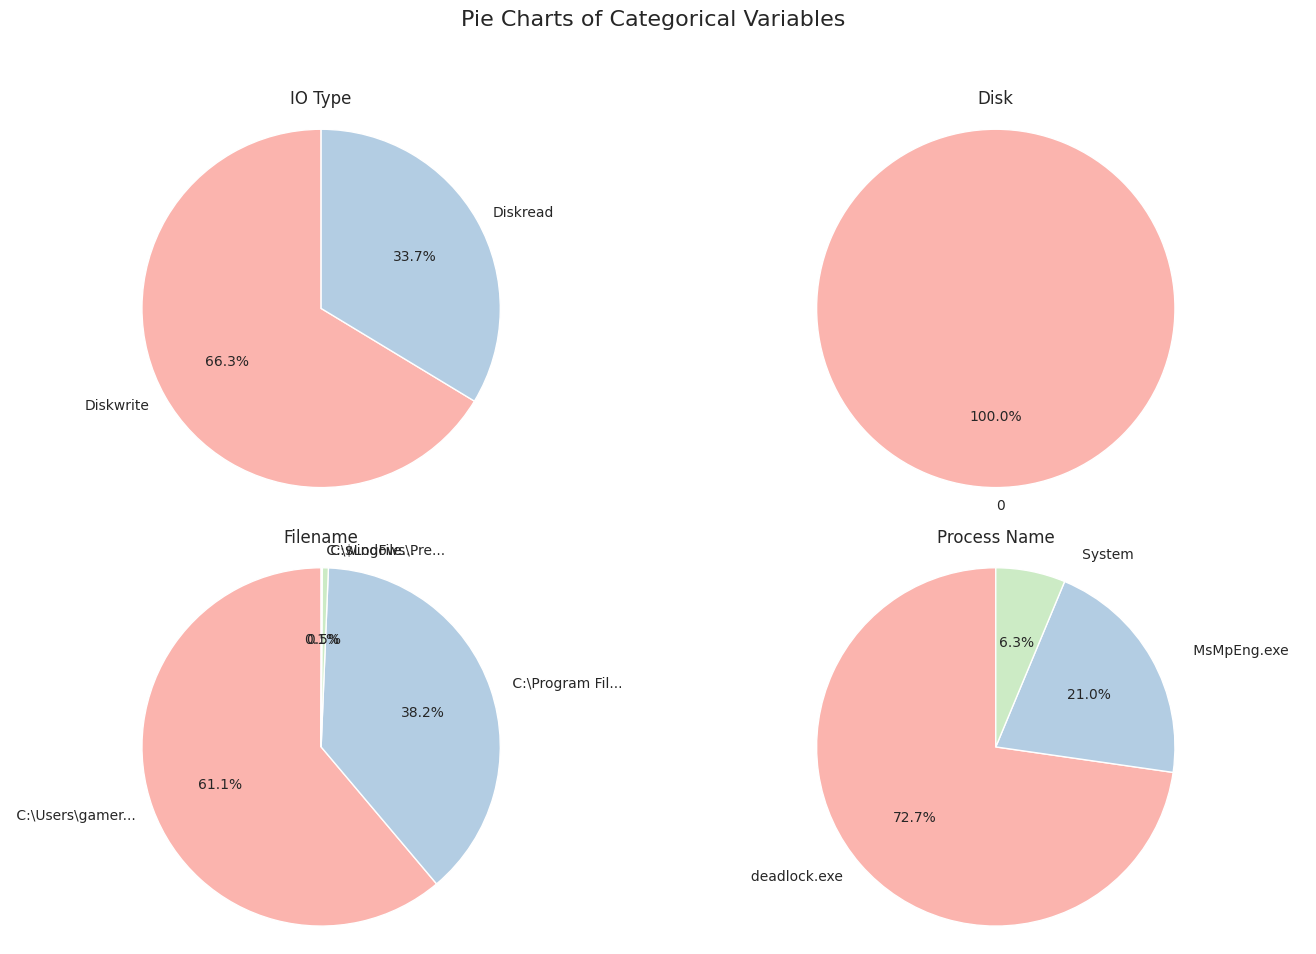


Performing univariate analysis for deadlock_60m_2025-05-05_combined.parquet...
Loaded DataFrame with 1711 rows and 16 columns.


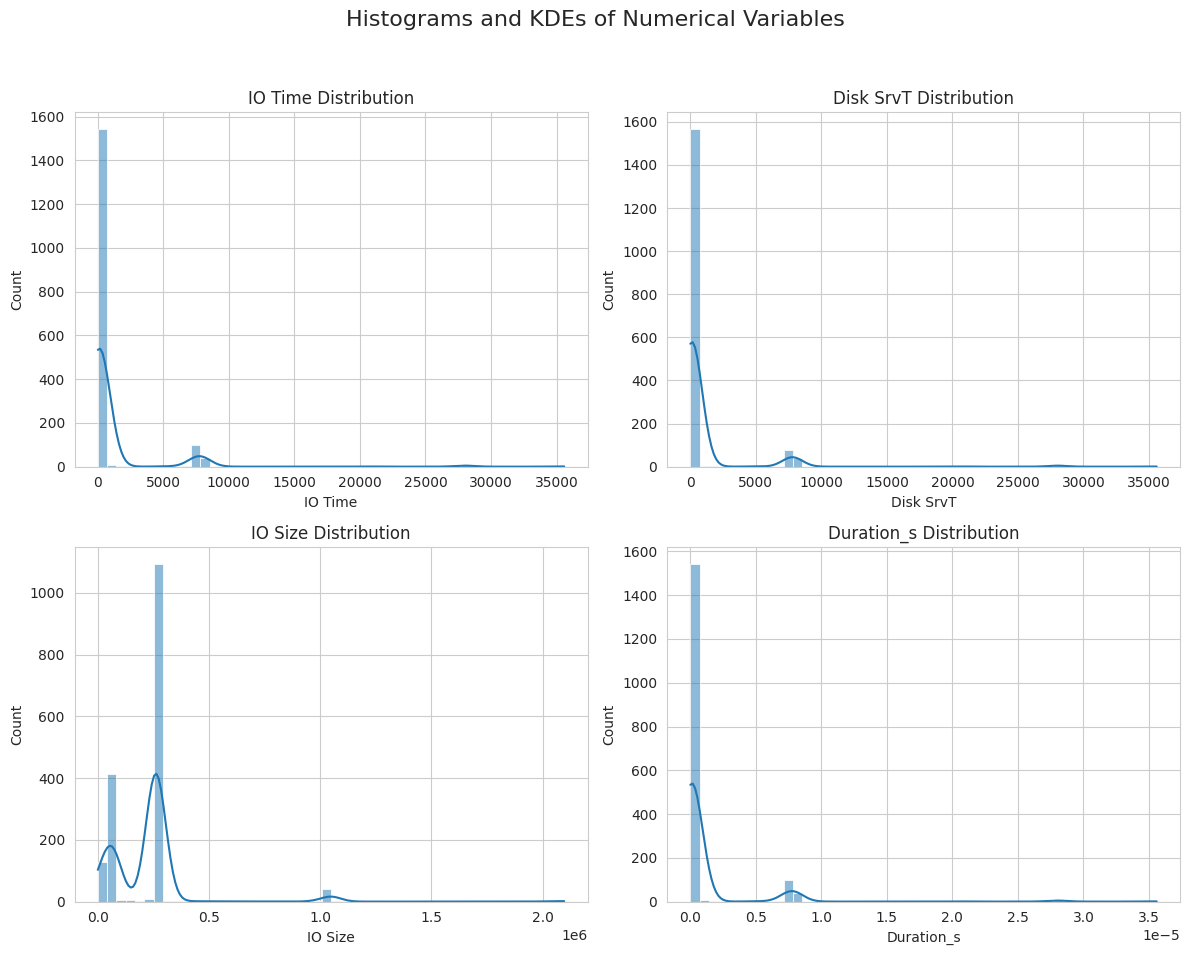

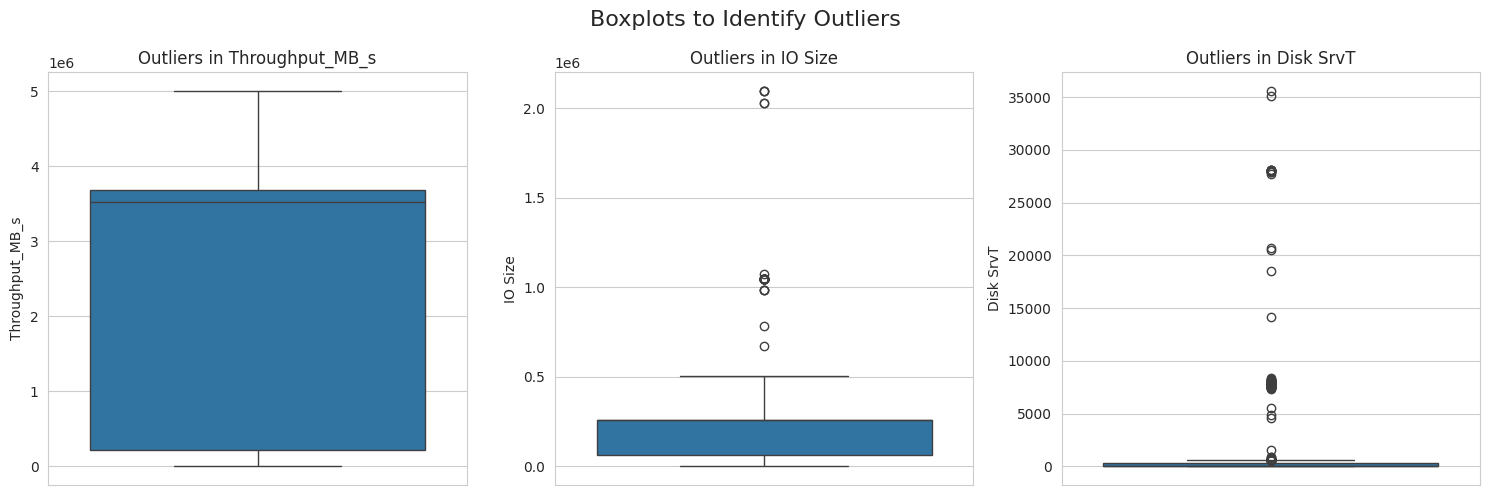

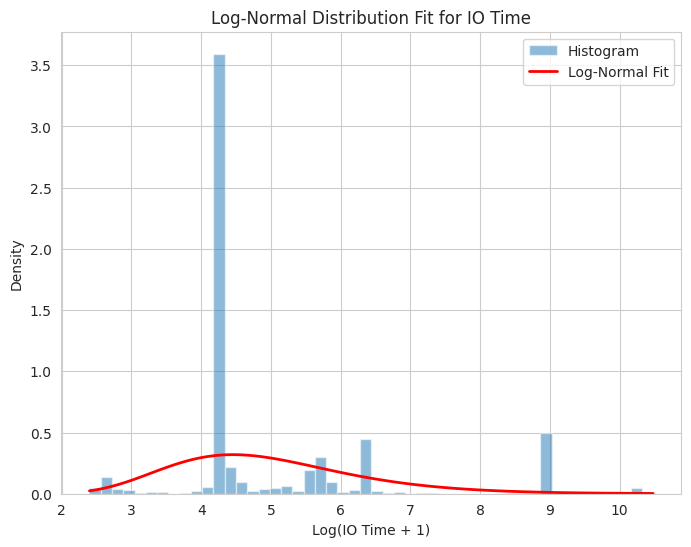

Log-Normal Fit Parameters for IO Time: (np.float64(0.27039808394106446), 0, np.float64(4.793102152608156))

Value Counts for IO Type:
IO Type
Diskwrite    1212
Diskread      499
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    1711
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\Temp\TmpD3AA.tmp                                        271
C:\Users\gamer\AppData\Local\Temp\Tmp9C85.tmp                                        271
C:\Users\gamer\AppData\Local\Temp\TmpD0D5.tmp                                        159
C:\Users\gamer\AppData\Local\Temp\Tmp99A0.tmp                                        159
C:\Users\gamer\AppData\Local\Temp\Tmp9B2C.tmp                                         68
C:\Users\gamer\AppData\Local\Temp\TmpD251.tmp                                         68
C:\Users\gamer\AppData\Local\Temp\TmpD654.tmp                                         52
C:\Users\gamer\AppData\Local\Temp\Tmp9F1F.tmp                          

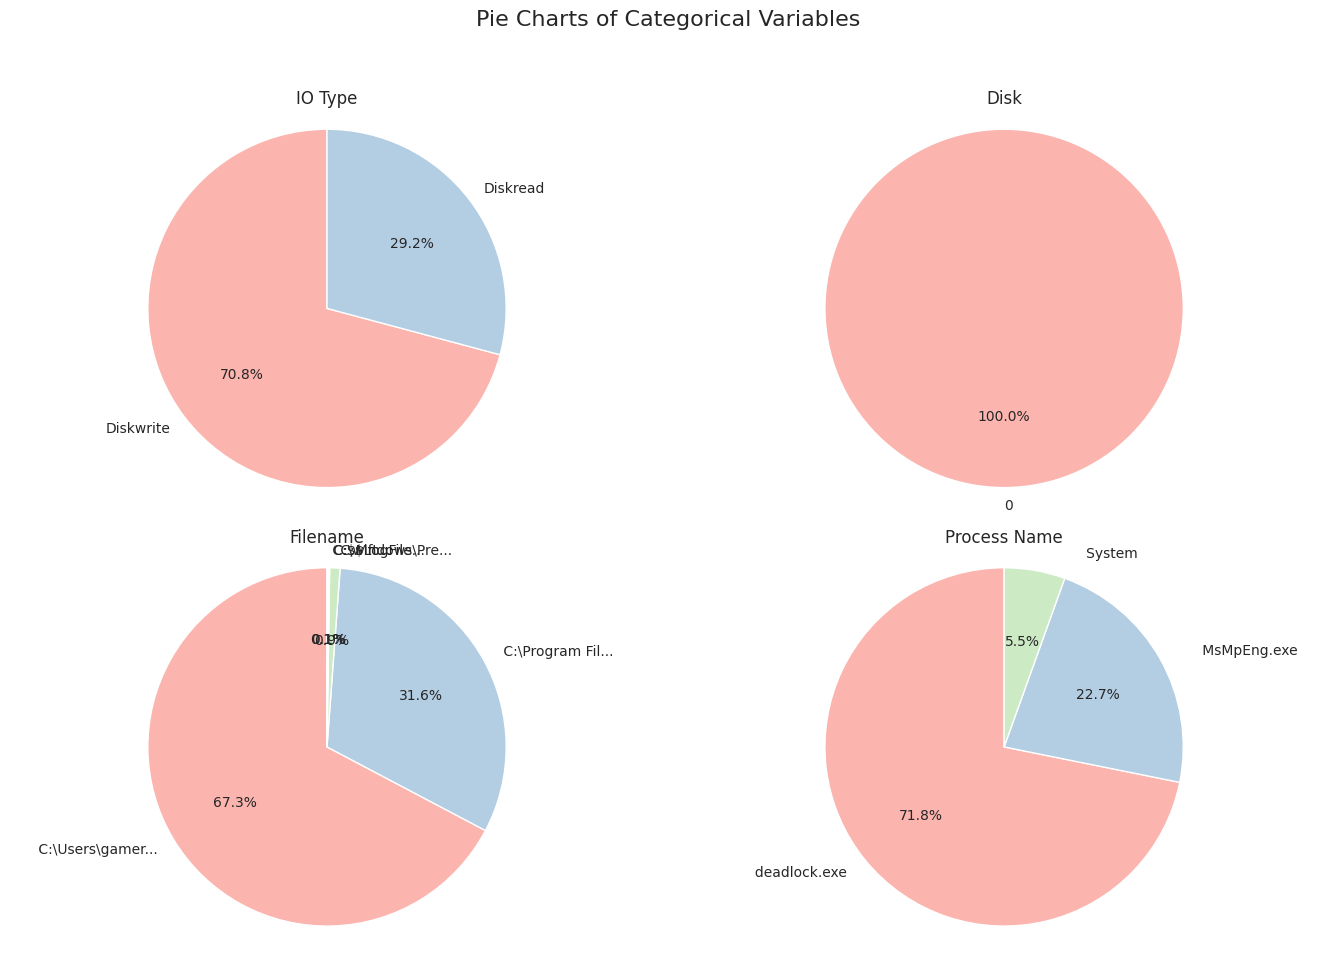


Performing univariate analysis for deadlock_60m_2025-05-06_combined.parquet...
Loaded DataFrame with 774 rows and 16 columns.


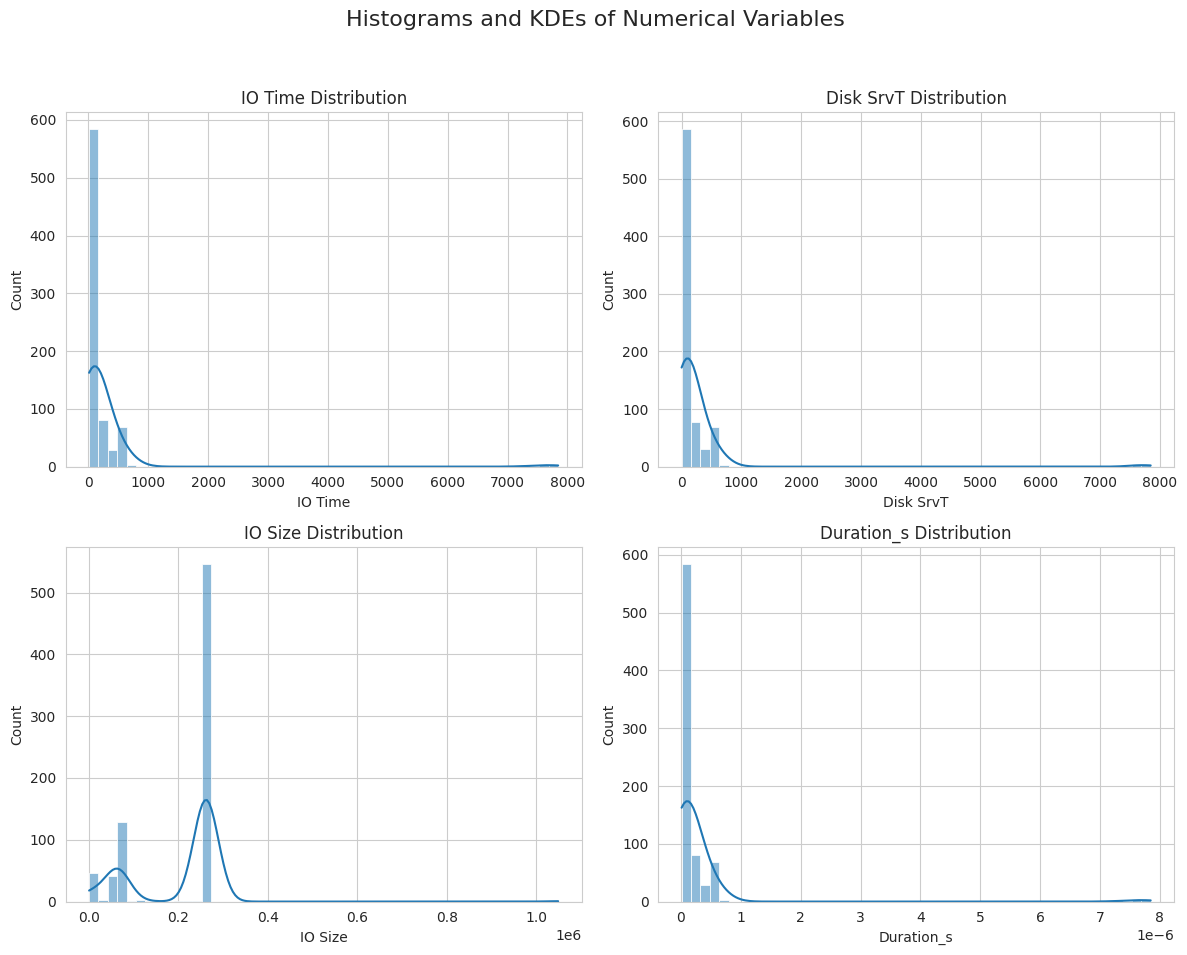

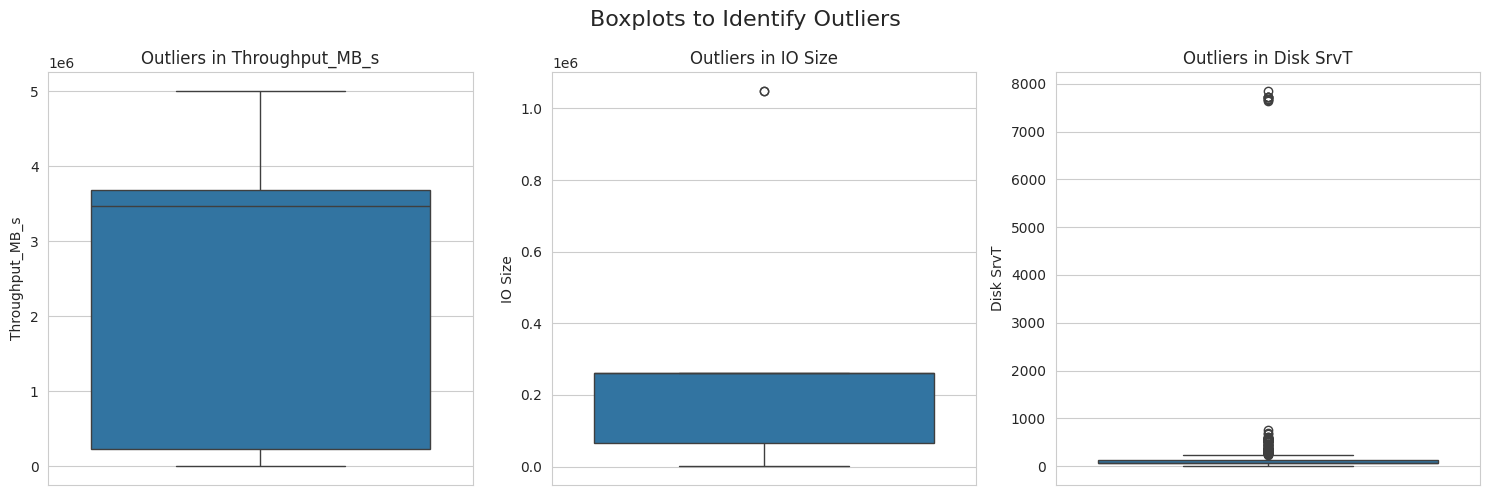

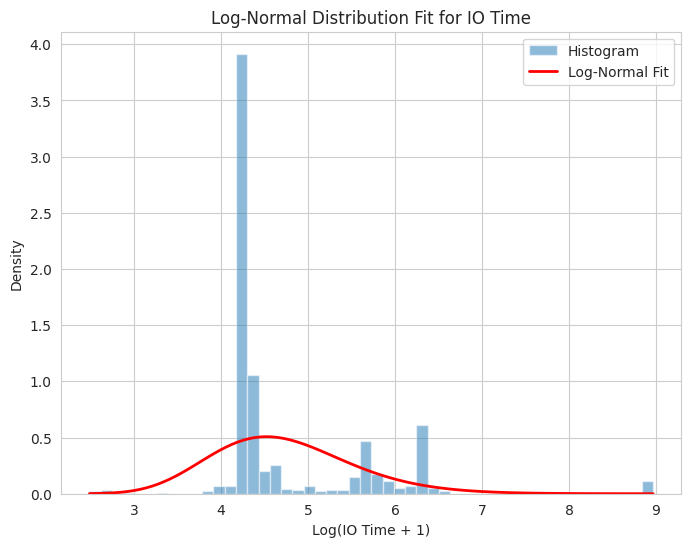

Log-Normal Fit Parameters for IO Time: (np.float64(0.17124483326071505), 0, np.float64(4.656386686185614))

Value Counts for IO Type:
IO Type
Diskwrite    571
Diskread     203
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    774
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\Temp\Tmp719A.tmp                                        271
C:\Users\gamer\AppData\Local\Temp\Tmp6ED5.tmp                                        159
C:\Users\gamer\AppData\Local\Temp\Tmp7051.tmp                                         68
C:\Users\gamer\AppData\Local\Temp\Tmp7444.tmp                                         52
C:\$Mft                                                                               21
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\citadel\pak01_006.vpk     10
C:\$LogFile                                                                            4
C:\Program Files (x86)\Steam\steamapps\common\Deadlock\game\core\Resource 

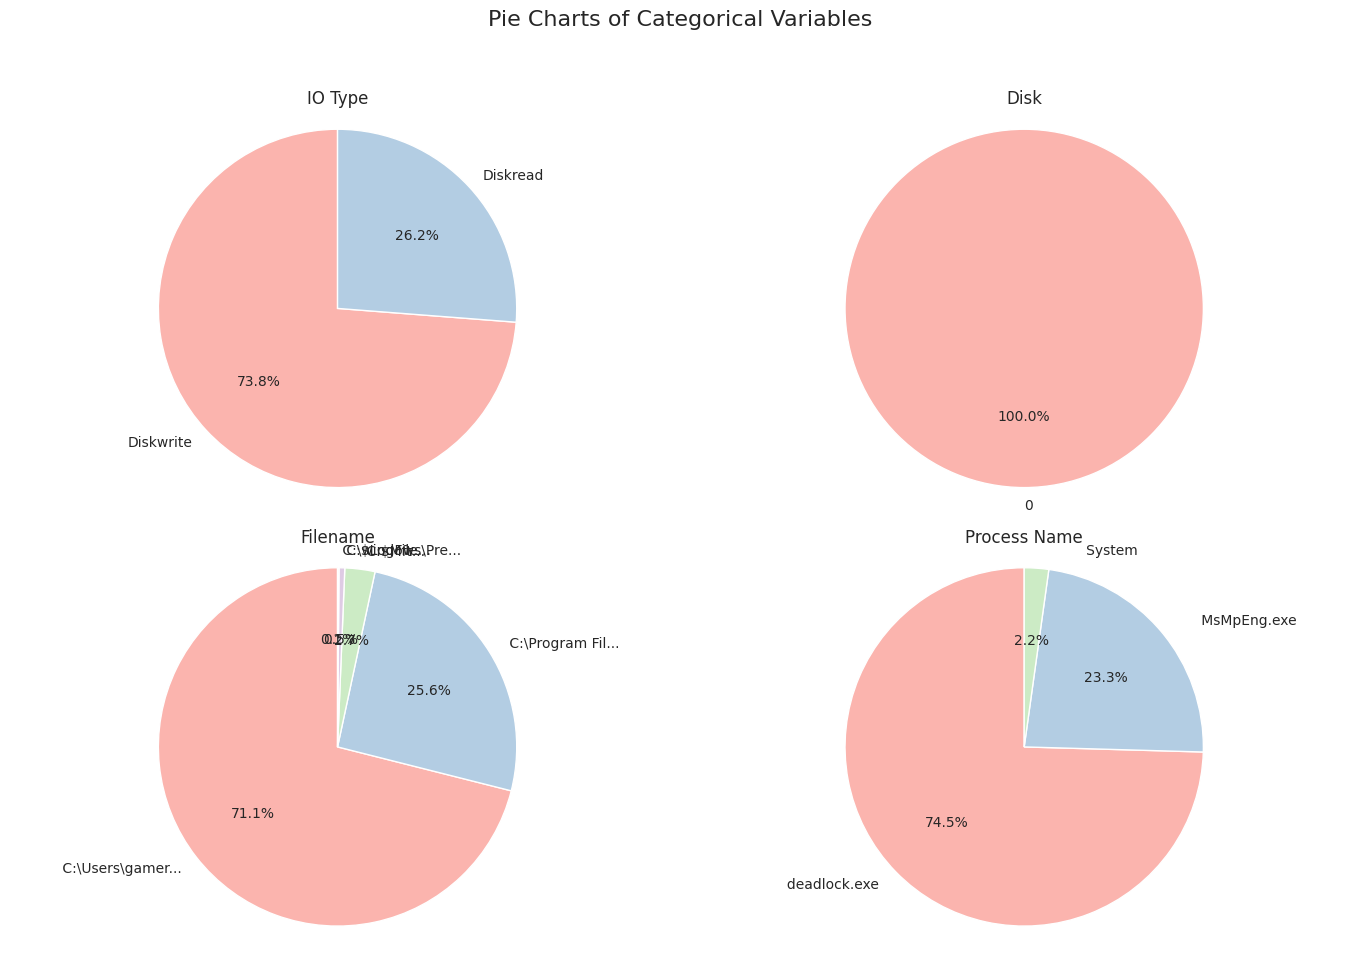


Performing univariate analysis for hogwarts_legacy_combined.parquet...
Loaded DataFrame with 520231 rows and 16 columns.


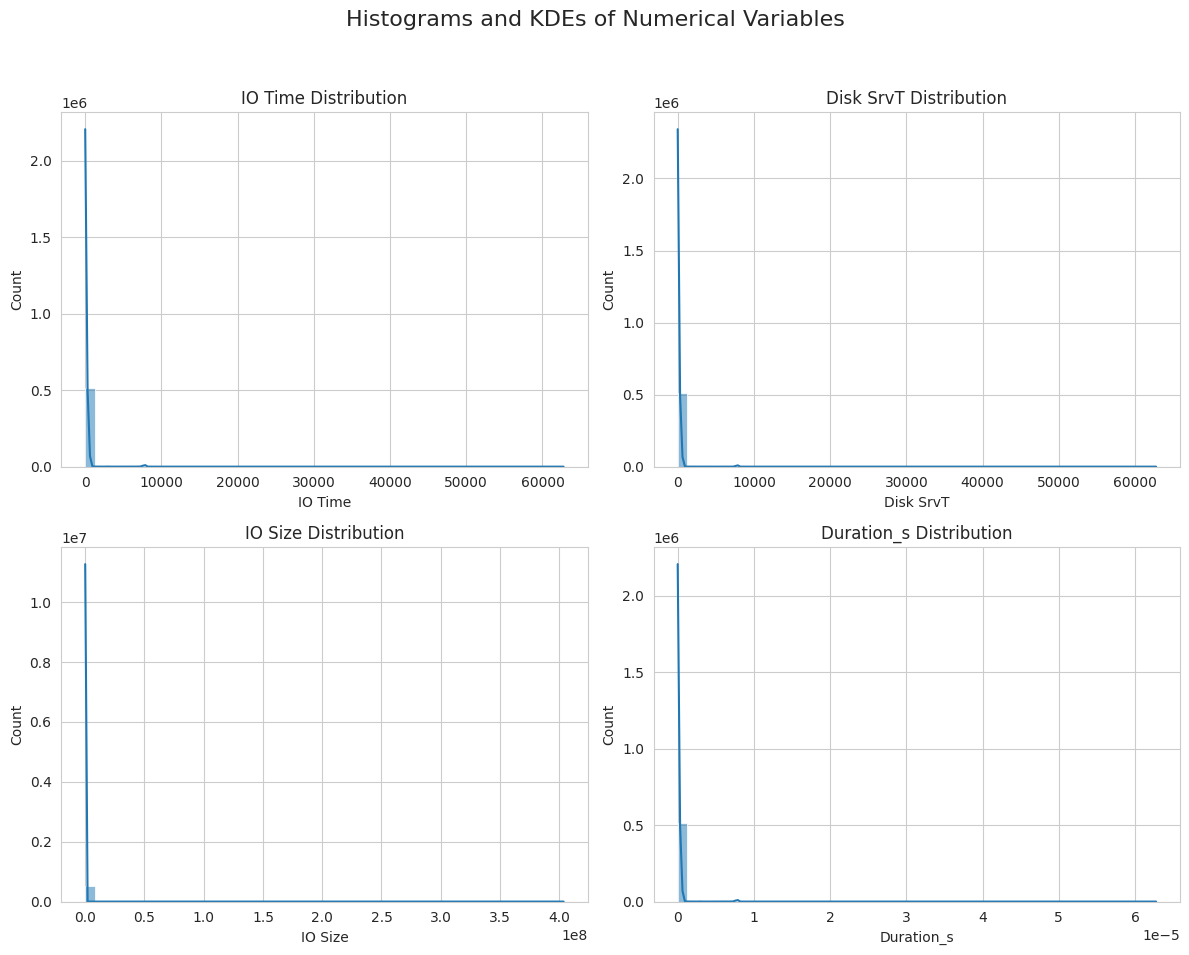

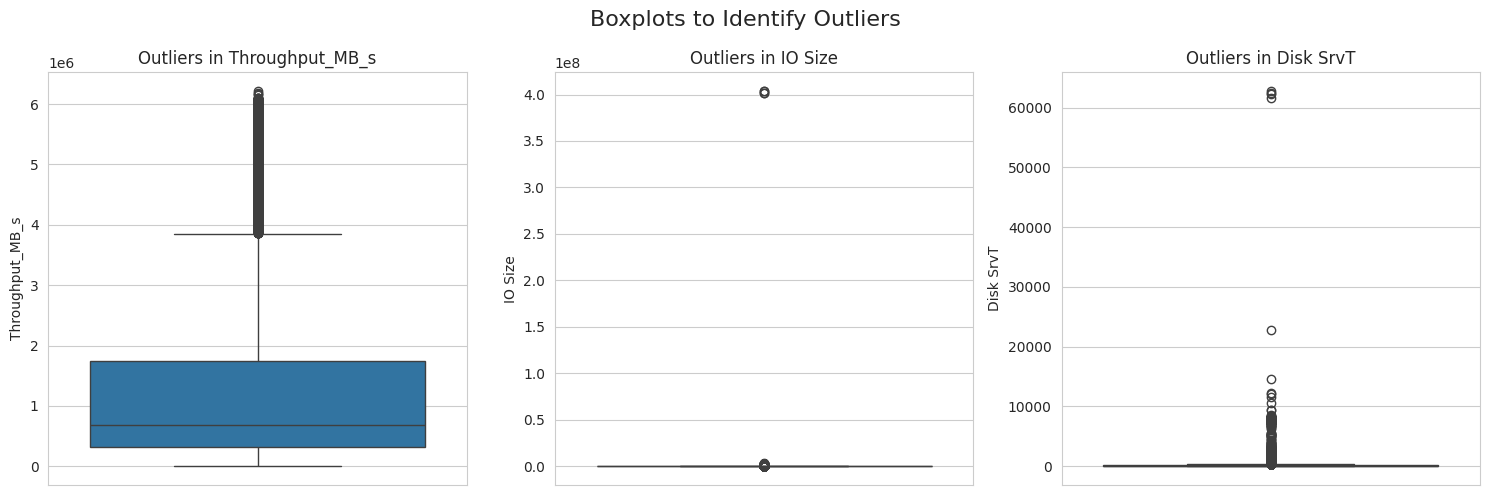

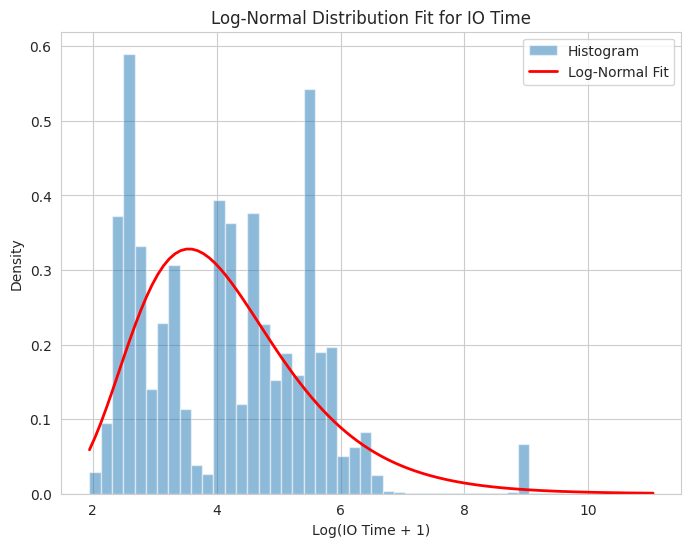

Log-Normal Fit Parameters for IO Time: (np.float64(0.3245814333926248), 0, np.float64(3.9458166684159304))

Value Counts for IO Type:
IO Type
Diskread     357008
Diskwrite    163223
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    520231
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\ProgramData\Hogwarts Legacy\D3DGraphics_V4318_D11266_S1393627176_R161.ushaderprecache                                      135553
C:\Program Files (x86)\Steam\steamapps\common\Hogwarts Legacy\Phoenix\Binaries\Win64\HogwartsLegacy.exe                        46952
C:\Program Files (x86)\Steam\steamapps\common\Hogwarts Legacy\Phoenix\Content\Paks\pakchunk10-WindowsNoEditor.ucas             41769
C:\Program Files (x86)\Steam\steamapps\common\Hogwarts Legacy\Phoenix\Content\Paks\pakchunk0-WindowsNoEditor.ucas              40415
C:\Users\gamer\AppData\Local\Nvidia\DXCache\0002a91cd114f78e.nvph                                                              28918
C:\Program Files (x86)\

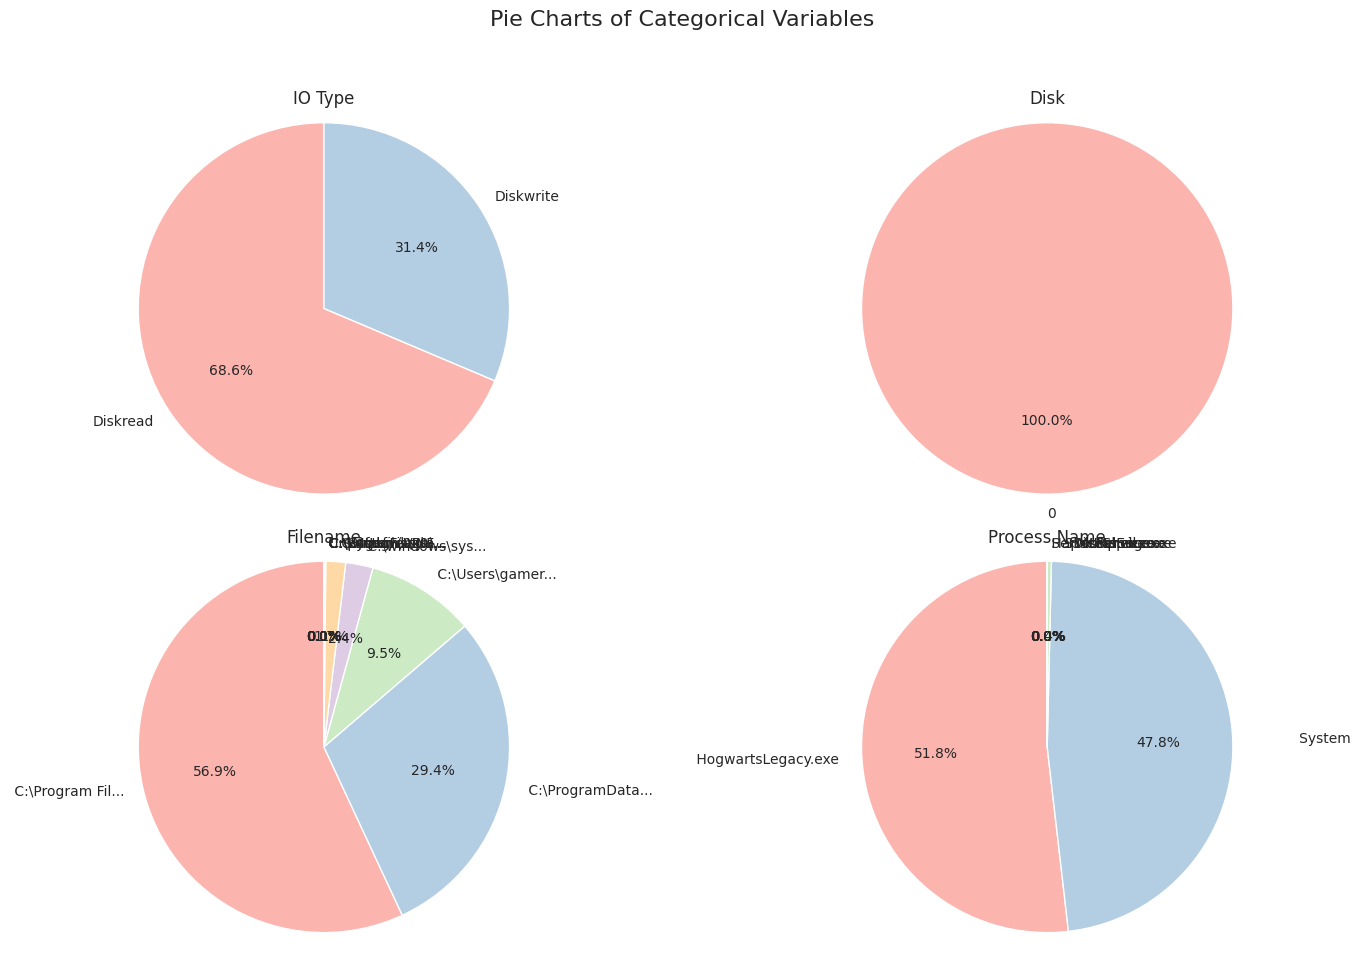


Performing univariate analysis for marvel_rivals_60m_2025-05-06_combined.parquet...
Loaded DataFrame with 71509 rows and 16 columns.


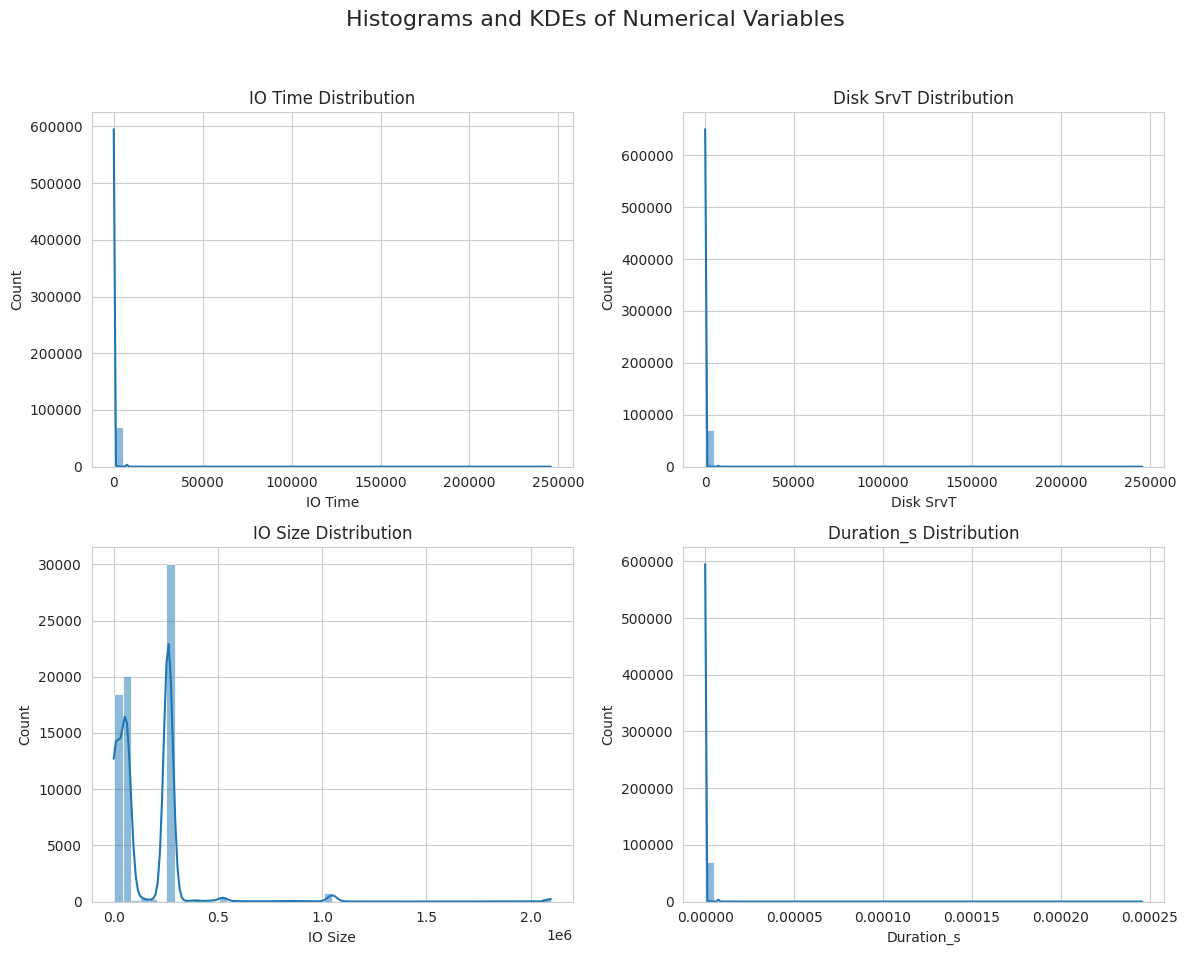

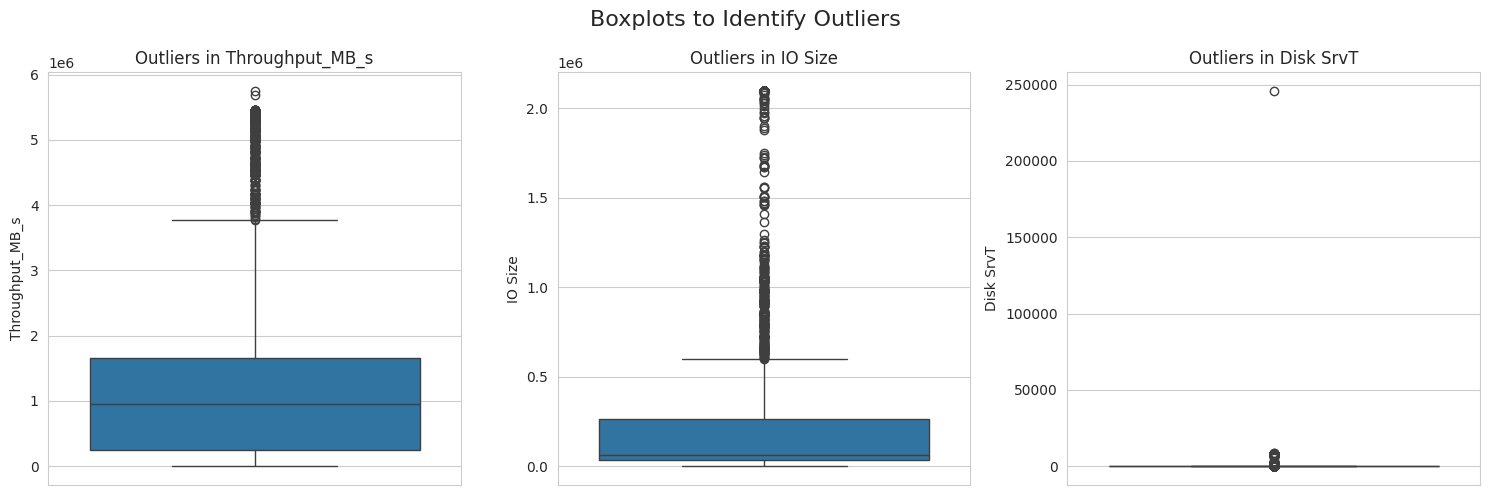

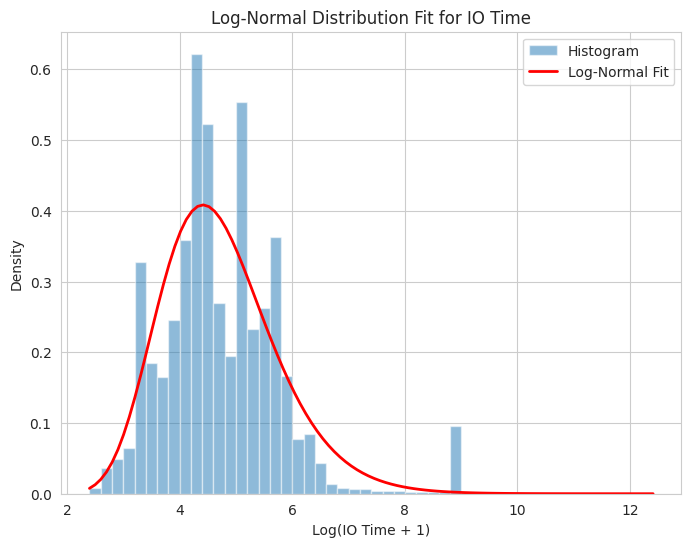

Log-Normal Fit Parameters for IO Time: (np.float64(0.21616833018547185), 0, np.float64(4.6264744583595965))

Value Counts for IO Type:
IO Type
Diskread     69369
Diskwrite     2140
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    71509
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Program Files (x86)\Steam\steamapps\common\MarvelRivals\MarvelGame\Marvel\Content\Paks\pakchunkEnv-Windows.ucas             9356
C:\Program Files (x86)\Steam\steamapps\common\MarvelRivals\MarvelGame\Marvel\Binaries\Win64\Marvel-Win64-Shipping.exe          6070
C:\Program Files (x86)\Steam\steamapps\common\MarvelRivals\MarvelGame\Marvel\Content\Paks\pakchunkCommon-Windows.ucas          5789
C:\Program Files (x86)\Steam\steamapps\common\MarvelRivals\MarvelGame\Marvel\Content\Paks\pakchunkShaderAsset-Windows.ucas     3995
C:\Program Files (x86)\Steam\steamapps\common\MarvelRivals\MarvelGame\Marvel\Content\Paks\pakchunkMovies-Windows.pak           3981
C:\Program Files (x86)\Steam\s

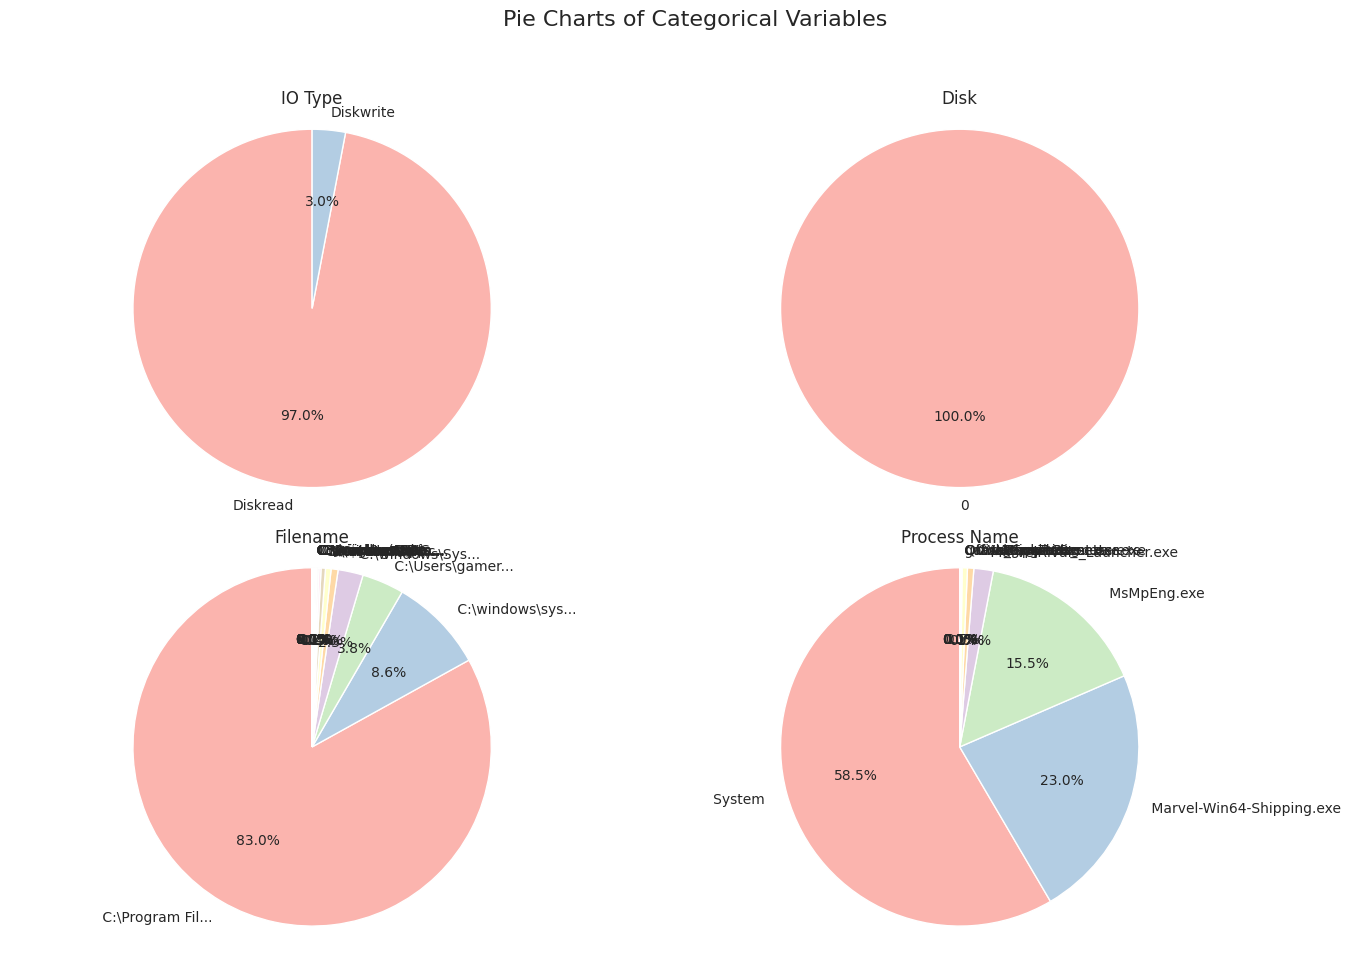


Performing univariate analysis for overwatch_60m_2025-04-28_combined.parquet...
Loaded DataFrame with 31401 rows and 16 columns.


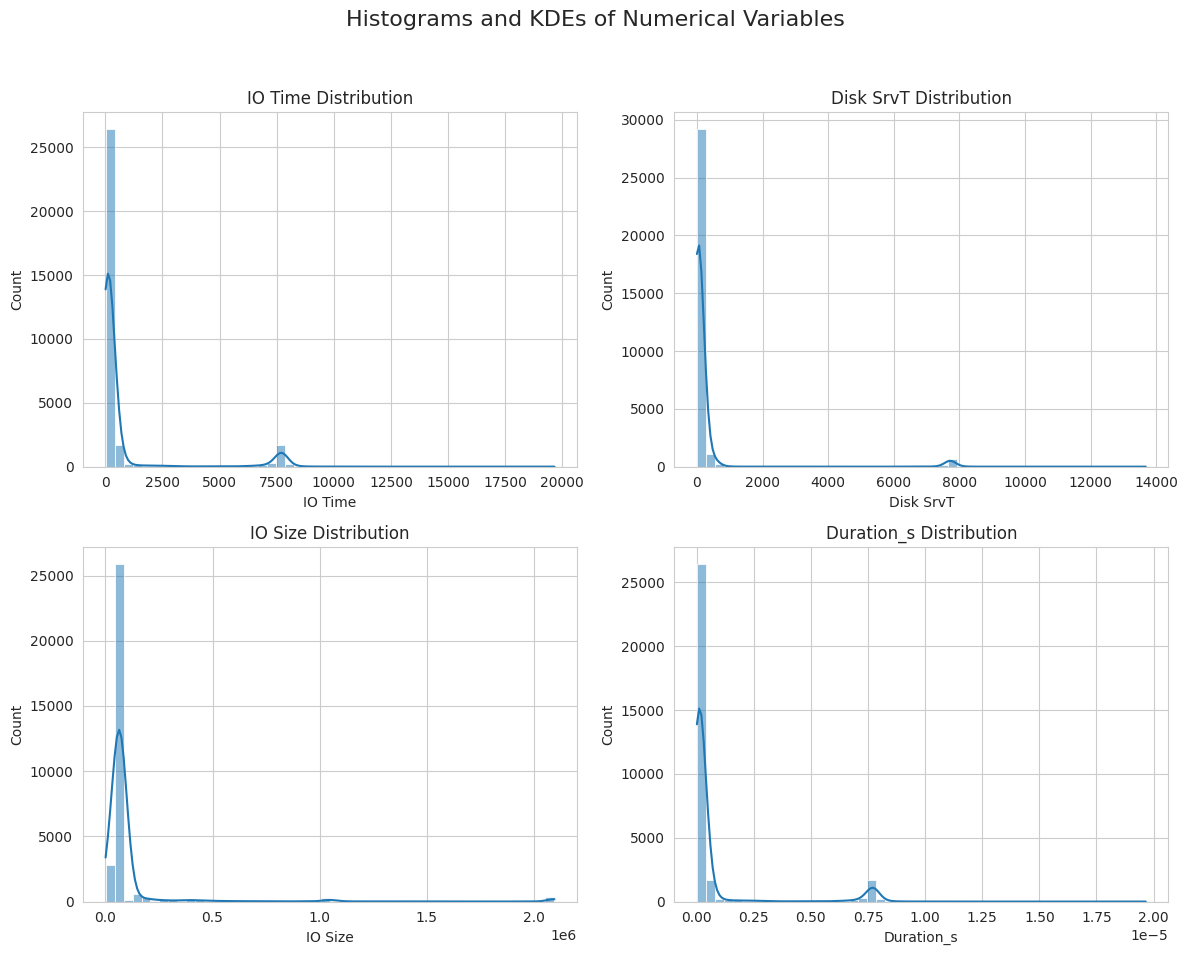

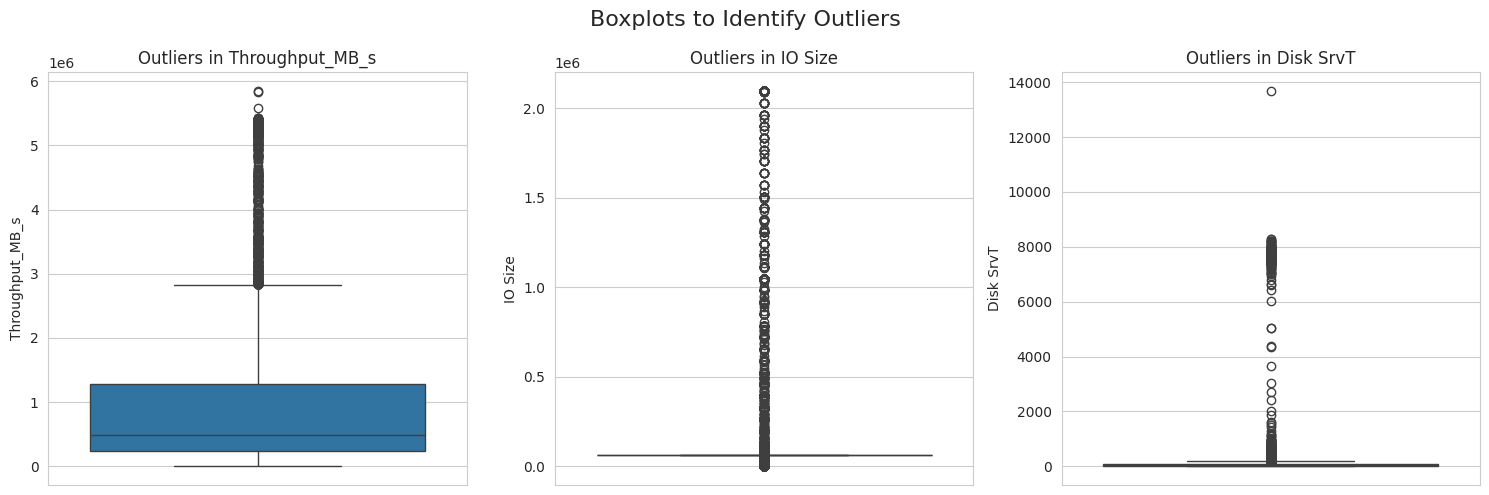

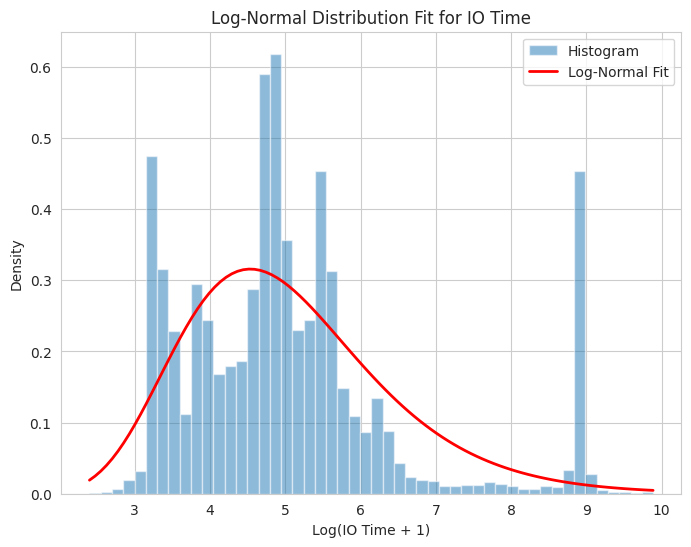

Log-Normal Fit Parameters for IO Time: (np.float64(0.2687830959724447), 0, np.float64(4.873714484287836))

Value Counts for IO Type:
IO Type
Diskread     31291
Diskwrite      110
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    31401
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\fa7ba91cefac14d8.nvph            3816
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\data\data.020.014    2850
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\data\data.020.002    2801
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\data\data.020.001    2471
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\data\data.032.008    2109
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\Overwatch.exe        1229
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\data\data.000.014    1129
C:\Program Files (x86)\Steam\steamapps\common\Overwatch\data\data.030.001    1042
C:\Program Files (x86)\Steam\steamap

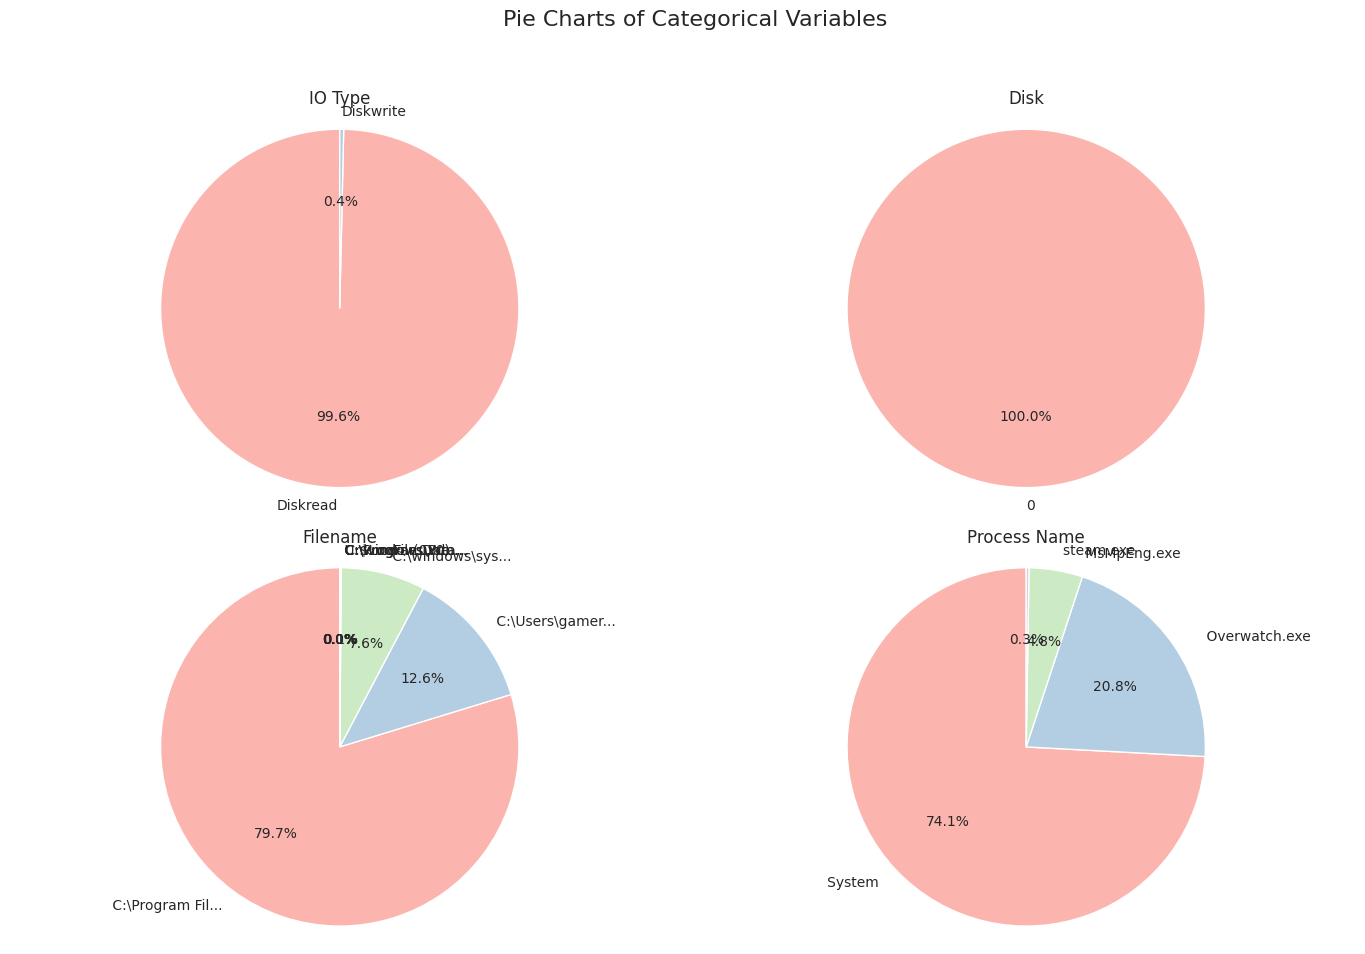


Performing univariate analysis for the_finals_30m_2025-05-01_combined.parquet...
Loaded DataFrame with 57702 rows and 16 columns.


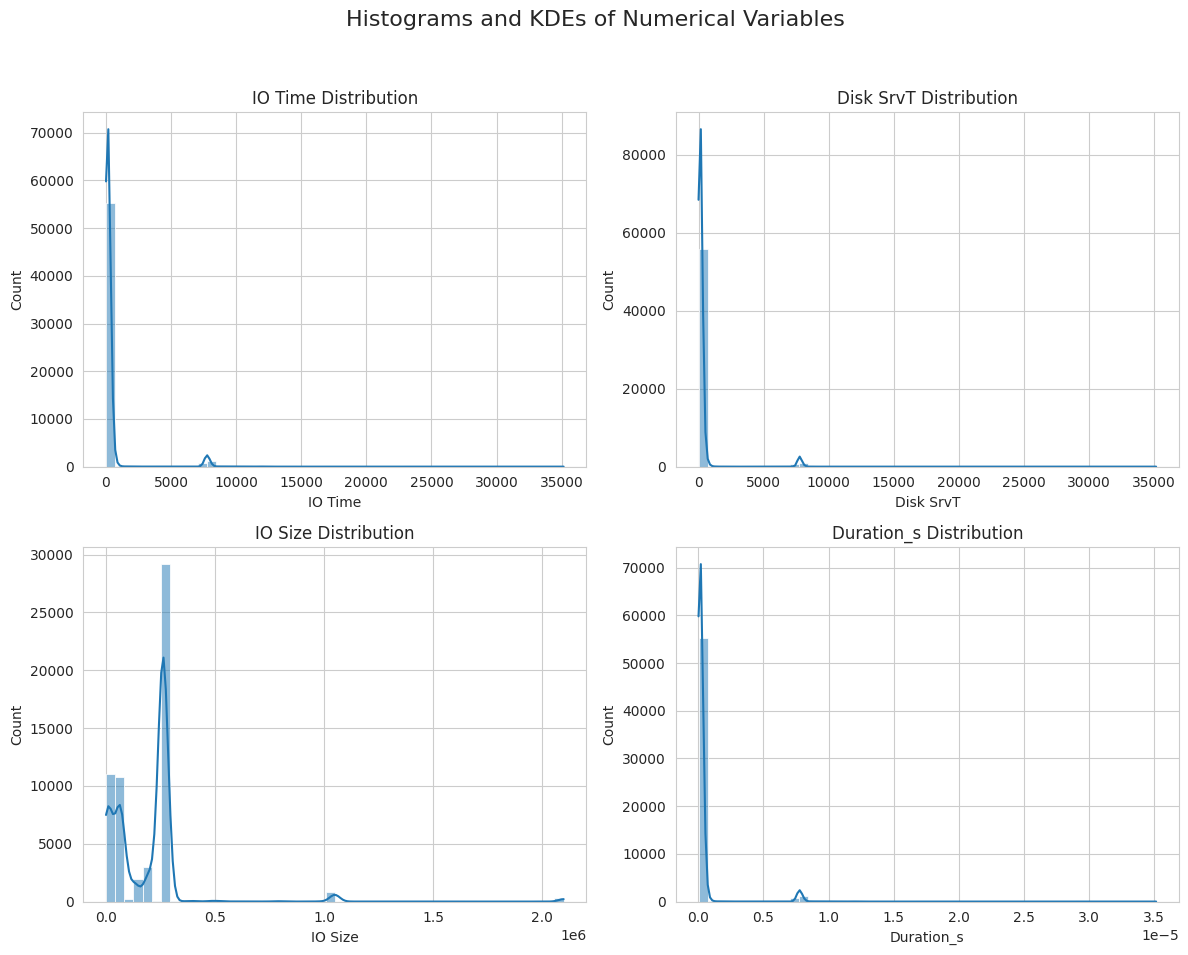

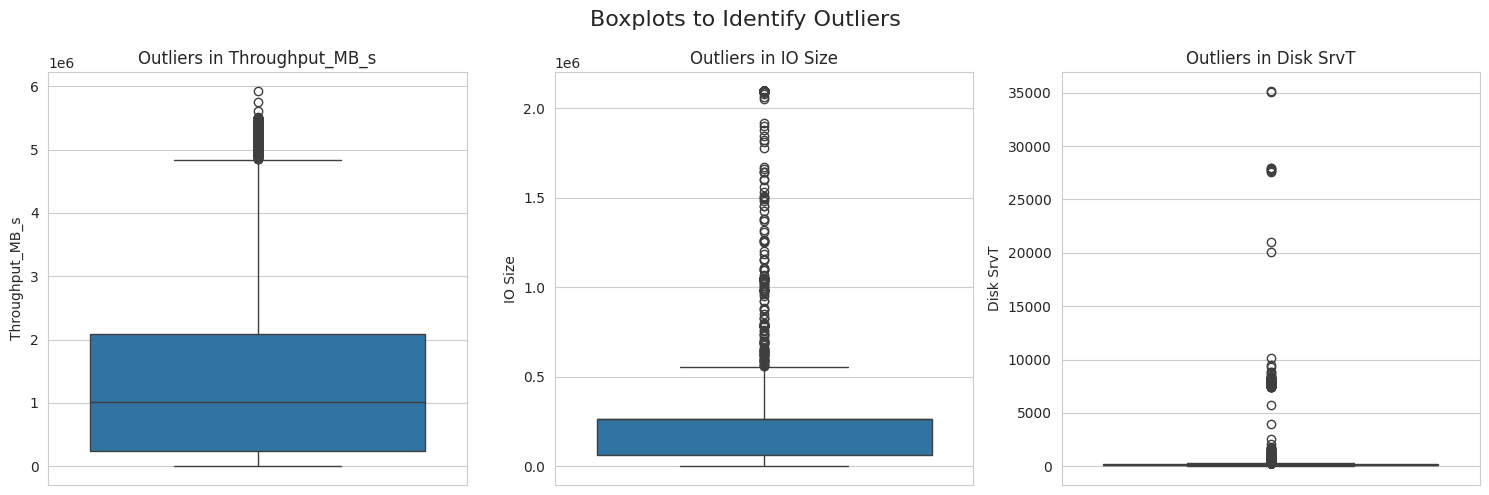

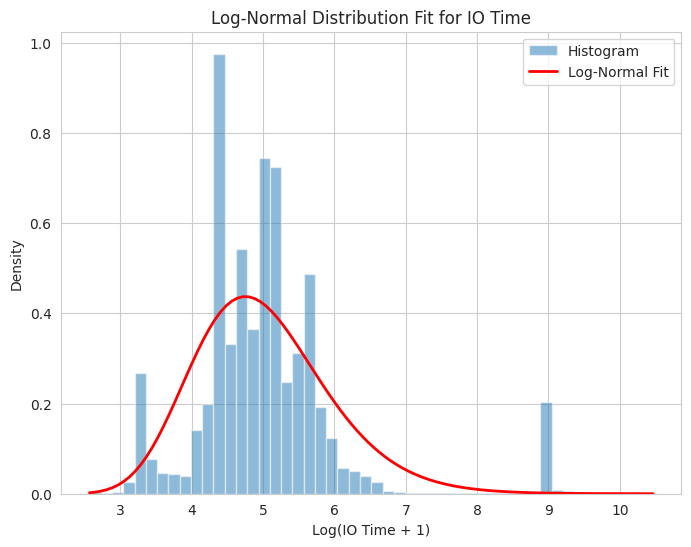

Log-Normal Fit Parameters for IO Time: (np.float64(0.18863668155380645), 0, np.float64(4.922996780859234))

Value Counts for IO Type:
IO Type
Diskread     57552
Diskwrite      150
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    57702
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Program Files (x86)\Steam\steamapps\common\The Finals\Discovery\Content\Paks\pakchunk0_s1-WindowsClient.ucas     4082
C:\Program Files (x86)\Steam\steamapps\common\The Finals\Discovery\Content\Paks\pakchunk0_s3-WindowsClient.ucas     3356
C:\$Mft                                                                                                             3175
C:\Program Files (x86)\Steam\steamapps\common\The Finals\Discovery\Content\Paks\pakchunk0_s8-WindowsClient.ucas     3049
C:\Program Files (x86)\Steam\steamapps\common\The Finals\Discovery\Content\Paks\pakchunk0_s6-WindowsClient.ucas     2994
C:\Program Files (x86)\Steam\steamapps\common\The Finals\Discovery\Content\Paks\pakchu

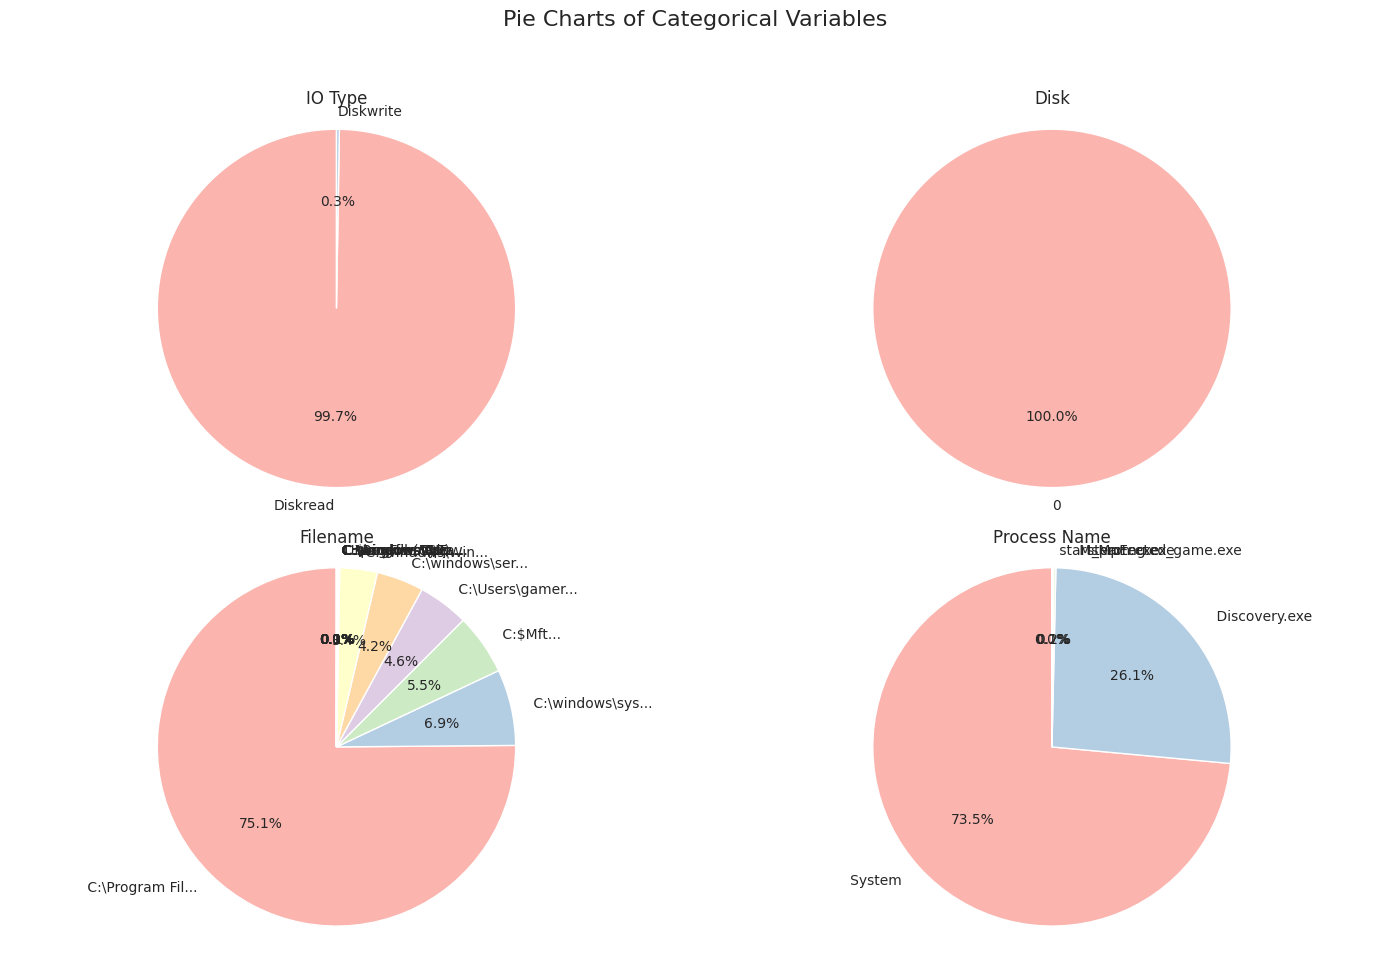


Performing univariate analysis for the_last_of_us_part_i.parquet...
Loaded DataFrame with 147824 rows and 16 columns.


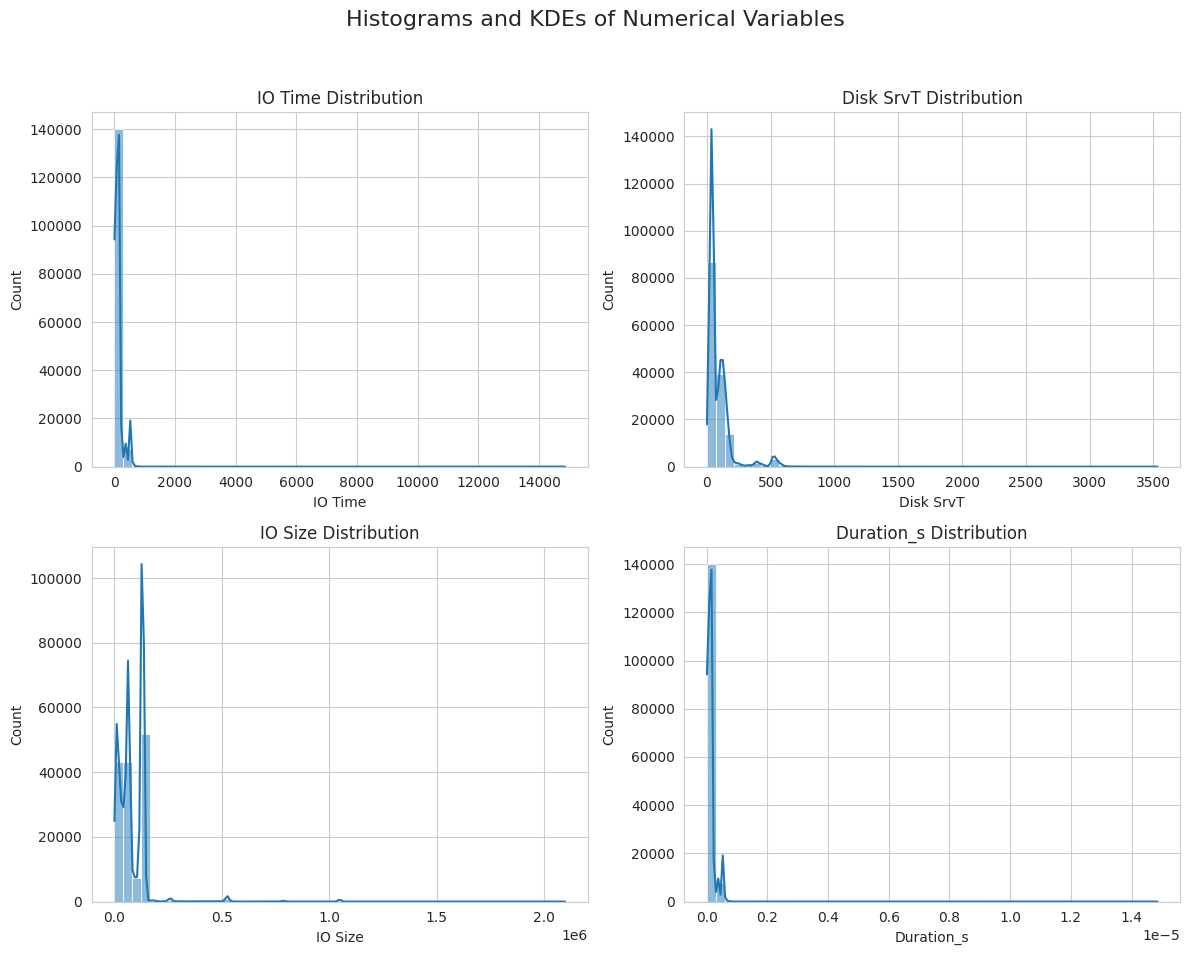

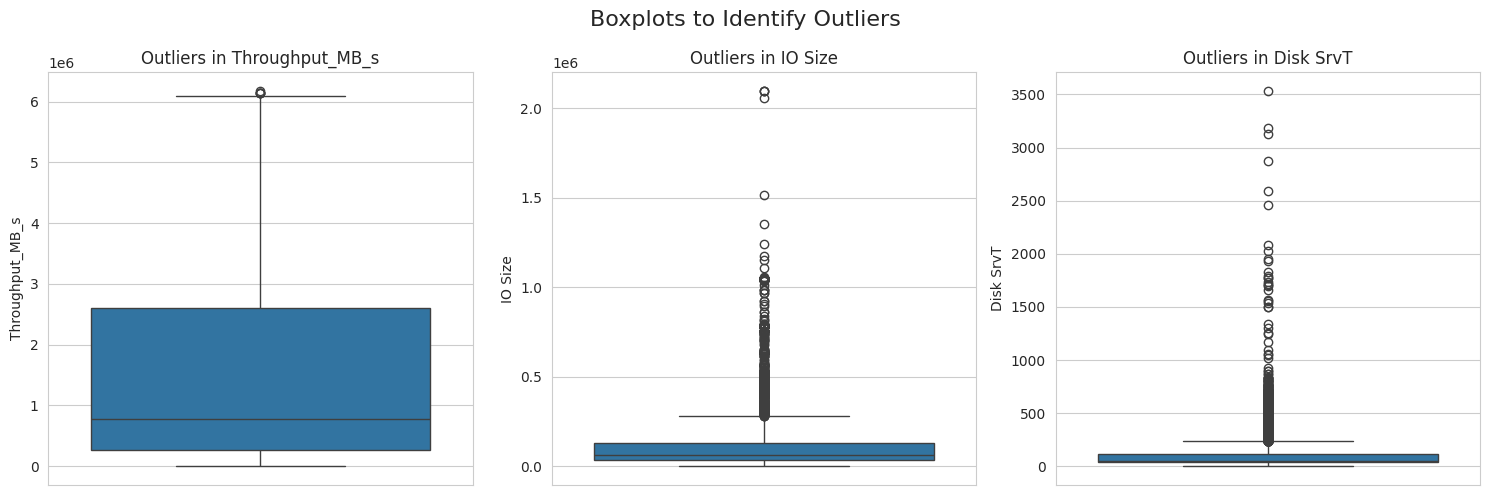

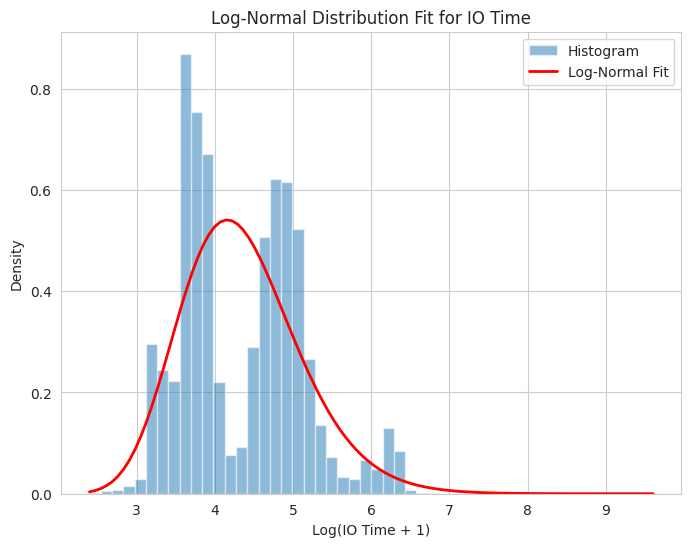

Log-Normal Fit Parameters for IO Time: (np.float64(0.17460078586701774), 0, np.float64(4.288823075036166))

Value Counts for IO Type:
IO Type
Diskread     144928
Diskwrite      2896
Name: count, dtype: int64

Value Counts for Disk:
Disk
0    147822
1         2
Name: count, dtype: int64

Value Counts for Filename:
Filename
C:\Program Files (x86)\Steam\steamapps\common\The Last of Us Part I\build\pc\main\world-military-city.psarc    45314
C:\Program Files (x86)\Steam\steamapps\common\The Last of Us Part I\build\pc\main\sp-common.psarc              35921
C:\Program Files (x86)\Steam\steamapps\common\The Last of Us Part I\build\pc\main\world-home.psarc             15830
C:\Users\gamer\AppData\Local\NVIDIA\DXCache\f629a91c9a6ce922.nvph                                               7613
C:\Program Files (x86)\Steam\steamapps\common\The Last of Us Part I\build\pc\main\common.psarc                  4486
C:\Program Files (x86)\Steam\steamapps\common\The Last of Us Part I\build\pc\main\world-out

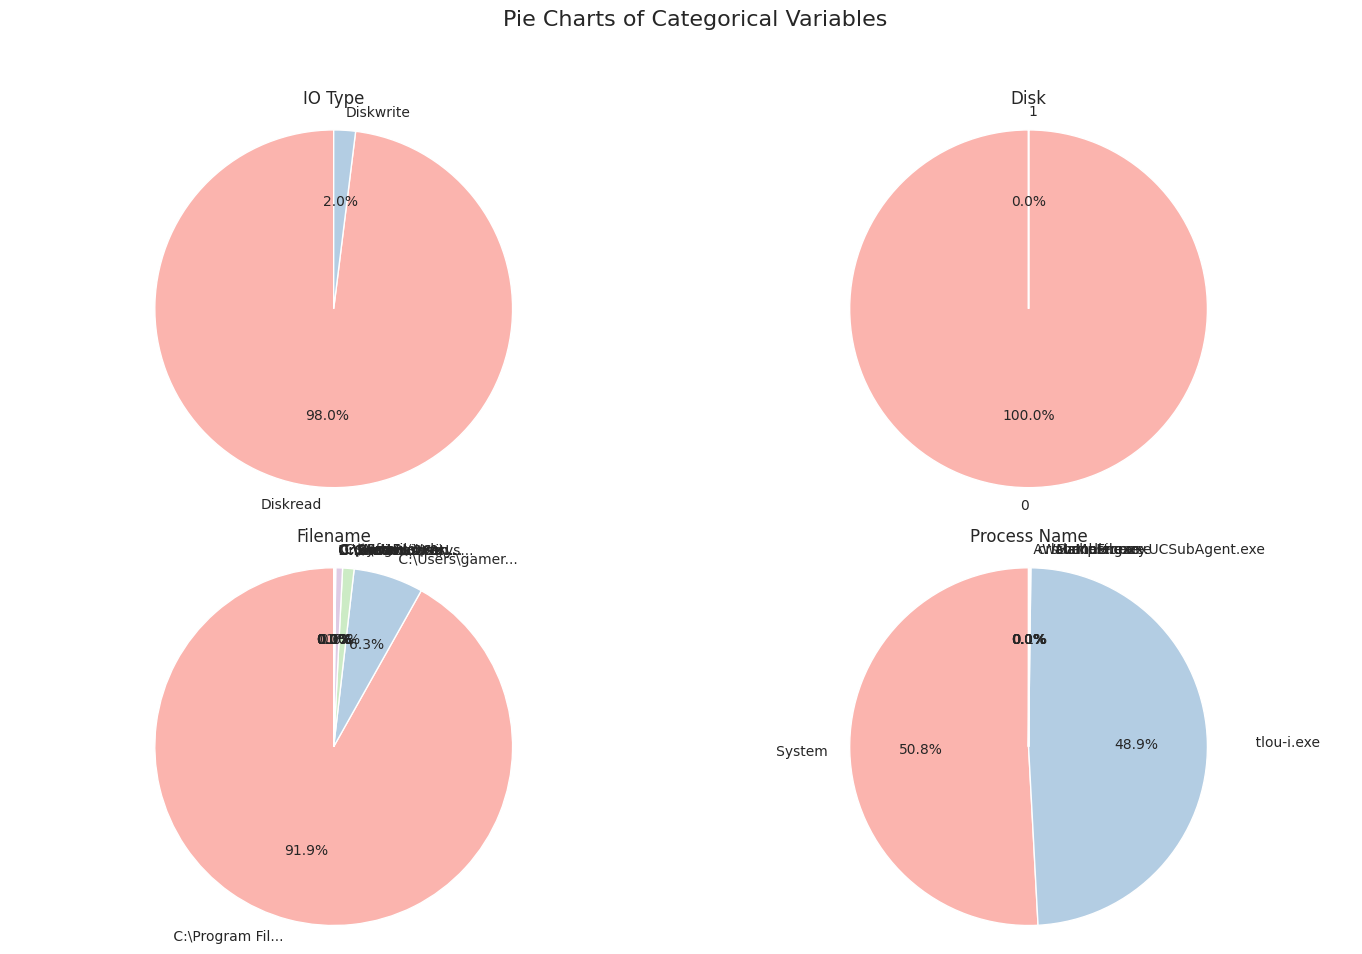

In [9]:
for file in files:
    print(f"\nPerforming univariate analysis for {file}...")
    df = pd.read_parquet(dataset_path + file)
    print(f"Loaded DataFrame with {len(df)} rows and {len(df.columns)} columns.")
    df = data_processiing(df)
    univariate_analysis(df)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

session_name = 'Cyberpunk 2077 Combined Data'
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'Key Metric Distributions for {session_name}', fontsize=16)

# KDE = kernel density estimate (probability density function curve plot over the histogram) 
sns.histplot(df['IO Time'], bins=50, kde=True, ax=axes[0, 0]) 
axes[0, 0].set_title('Distribution of IO Time (ns)')
axes[0, 0].set_xlabel('IO Time (ns)')

sns.histplot(df['Disk SrvT'], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Disk Service Time (ns)')
axes[0, 1].set_xlabel('Disk Service Time (s)')

sns.histplot(df['IO Size'] / 1024, bins=50, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of IO Size (KB)')
axes[0, 2].set_xlabel('IO Size (KB)')

sns.histplot(df['Duration_s'], bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of I/O Duration (ns)')
axes[1, 0].set_xlabel('I/O Duration (s)')

sns.histplot(df['Throughput_MB_s'], bins=50, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Throughput (MB/s)')
axes[1, 1].set_xlabel('Throughput (MB/s)')

sns.histplot(df['QD/C'], bins=30, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Current Queue Depth (QD/C)')
axes[1, 2].set_xlabel('Queue Depth')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

1. IO Time, Disk Service Time, IO Size, and 

In [ ]:
session_name = 'Cyberpunk 2077 Combined Data'

In [ ]:
g = sns.catplot(
    x='IO Type', y='IO Time', col='Disk',
    data=df, kind='box', col_wrap=3,
    hue='IO Type', legend=False,
    palette='pastel', height=4, aspect=1
)
g.fig.suptitle(f'IO Time per IO Type per Disk for {session_name}', y=1.05)
plt.show()


In [ ]:
# Avoid log(0) by filtering out zeros or adding a small constant
df_filtered = df[(df['IO Size'] > 0) & (df['Duration_s'] > 0) & (df['Disk SrvT'] > 0)]

sns.lmplot(
    data=df_filtered,
    x='IO Size',
    y='IO Time',
    hue='Disk',
    logx=True,
    scatter_kws={'alpha':0.5},
    height=6,
    aspect=1.2
)
plt.yscale('log')
plt.title('Log-Log Regression: IO Size vs Duration, Colored by Disk')
plt.xlabel('IO Size (log scale)')
plt.ylabel('IO Time (log scale)')
plt.tight_layout()
plt.show()


In [ ]:
# Top 10 Processes by IO Time
top_io_processes_mb = df.groupby('Process Name')['IO Size'].sum().nlargest(10).sort_values(ascending=False) / (1024*1024)
if not top_io_processes_mb.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(x=top_io_processes_mb.index, y=top_io_processes_mb.values, palette='magma')
    plt.title(f'Top 10 Processes by Total IO Size (MB) for {session_name}')
    plt.xlabel('Process Name')
    plt.ylabel('Total IO Size (MB)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for selected columns
numerical_cols = ['Duration_s', 'IO Time', 'IO Size', 'Disk SrvT', 'Throughput_MB_s']
corr_matrix = df[numerical_cols].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Metrics')
plt.show()


In [ ]:
if df['Disk'].nunique() > 1:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Disk', y='Disk SrvT', data=df, palette='coolwarm')
    plt.title(f'Disk Service Time by Disk ID for {session_name}')
    plt.xlabel('Disk ID')
    plt.ylabel('Disk Service Time (ns)')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Count how many times each Disk ID appears
disk_counts = df['Disk'].value_counts()
srv_time_per_disk = df.groupby('Disk')['Disk SrvT'].sum()

# Ensure both series have the same index order
disk_ids = sorted(set(disk_counts.index).union(srv_time_per_disk.index))

# Reindex and fill missing with 0 if needed
disk_counts = disk_counts.reindex(disk_ids, fill_value=0)
srv_time_per_disk = srv_time_per_disk.reindex(disk_ids, fill_value=0)

# Sample colors consistently based on disk index
cmap = plt.cm.coolwarm
colors = [cmap(i / len(disk_ids)) for i in range(len(disk_ids))]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pie chart for Disk ID count
axes[0].pie(disk_counts, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title(f'Disk ID Ratio for {session_name}')
axes[0].axis('equal')

# Plot pie chart for service time
axes[1].pie(srv_time_per_disk, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title(f'Disk Service Time Ratio for {session_name}')
axes[1].axis('equal')

# Create a shared legend
fig.legend(labels=[f'Disk {disk_id}' for disk_id in disk_ids],
           loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.show()


In [ ]:
categorical_cols = ['IO Type', 'Disk', 'Filename', 'Process Name']
        
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Pie Charts of Categorical Variables', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    plot_data = df.copy()

    # Truncate long filenames for display
    if col == 'Filename':
        plot_data['Filename'] = plot_data['Filename'].str.slice(0, 15) + '...'

    pie_data = plot_data[col].value_counts()
    axes[i].pie(
        pie_data, 
        labels=pie_data.index, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=sns.color_palette("Pastel1")
    )
    axes[i].set_title(f'{col}', fontsize=12)
    axes[i].axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from io import StringIO
import sys
import scipy.stats as stats

def perform_eda(df, session_name, output_dir):
    """
    Performs EDA on the given DataFrame and saves full outputs to a Markdown file.
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Redirect print statements to a StringIO buffer
    output_buffer = StringIO()
    sys.stdout = output_buffer

    try:
        print(f"\n## Starting EDA for {session_name}")

        ## --- Data Processing ---
        print("# Data Processing and Feature Engineering")
        print("Performing data processing and feature engineering...")

        # Clean and standardize IO Type
        df['IO Type'] = df['IO Type'].str.strip().str.lower().str.capitalize()

        # Convert hexadecimal columns to integers
        df['IO Size'] = df['IO Size'].apply(lambda x: int(x, 16))
        df['Byte Offset'] = df['Byte Offset'].apply(lambda x: int(x, 16))

        # Extract Process Name and PID
        df[['Process Name', 'PID']] = df['Process Name ( PID)'].str.extract(r'(.+)\s*\(\s*(\d+)\)')
        df['PID'] = pd.to_numeric(df['PID'], errors='coerce')

        ## --- Feature Engineering ---
        print("Performing feature engineering...")
        df['Duration_s'] = df['IO Time'] / 1_000_000_000  # Convert nanoseconds to seconds
        df['Throughput_MB_s'] = (df['IO Size'] / (1024 * 1024)) / (df['Duration_s'])
        df['Throughput_GB_s'] = (df['IO Size'] / (1024**3)) / df['Duration_s']
        df.loc[(df['Duration_s'] == 0) | (df['Throughput_MB_s'] == np.inf), 'Throughput_MB_s'] = 0
        df.loc[(df['Duration_s'] == 0) | (df['Throughput_GB_s'] == np.inf), 'Throughput_GB_s'] = 0

        # --- Initial Data Overview ---
        print("# Processed Data Overview")

        # Capture full df.info() output
        info_buffer = StringIO()
        df.info(buf=info_buffer)
        print("## Processed Data Info")
        print(info_buffer.getvalue().replace("\n", "\n   "))

        # Capture full df.describe() output as a Markdown table
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            desc_table = df.describe().to_markdown()
        print("## Processed Data Description")
        print(desc_table)

        cols = ['IO Time', 'Disk SrvT', 'IO Size', 'Byte Offset', 'Pri', 'QD/I', 'QD/C', 
                'IBCB', 'IBCA', 'IACB', 'Duration_s', 'Throughput_MB_s', 'Throughput_GB_s']
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            desc_selected_table = df[cols].describe().to_markdown()
        print("## Description of Selected Columns")
        print(desc_selected_table)

        # Missing Values
        print("Missing Values after Processing")
        print(df.isnull().sum().to_markdown())

        # Convert nanoseconds to seconds (global duration)
        total_duration_sec = (df['End Time'].max() - df['Start Time'].min()) / 1e9
        print(f"Total duration of the session: ")
        print("{total_duration_sec:.2f} seconds")

        # Group by disk and count IOs
        iops_per_disk = df.groupby('Disk').size() / total_duration_sec
        print("\nIOPS per disk:")
        print(iops_per_disk)

        # Group by process and count IOs
        iops_per_process = df.groupby('Process Name').size() / total_duration_sec
        iops_per_process = iops_per_process.sort_values(ascending=False)
        print("\nIOPS per process:")
        print(iops_per_process)

        # Group by IO type and count IOs
        iops_per_io_type = df.groupby('IO Type').size() / total_duration_sec
        print("\nIOPS per IO type:")
        print(iops_per_io_type)

        # Group by disk and calculate average throughput
        avg_mb_throughput_per_disk = df.groupby('Disk')['Throughput_MB_s'].mean()
        print("\nAverage throughput per disk (MB/s):")
        print(avg_mb_throughput_per_disk)
        
        # Group by process and calculate average throughput
        avg_mb_throughput_per_process = df.groupby('Process Name')['Throughput_MB_s'].mean()
        print("\nAverage throughput per process (MB/s):")
        print(avg_mb_throughput_per_process)

        # Group by IO type and calculate average throughput
        avg_mb_throughput_per_io_type = df.groupby('IO Type')['Throughput_MB_s'].mean()
        print("\nAverage throughput per IO type (MB/s):")
        print(avg_mb_throughput_per_io_type)

        # Disk utilization
        disk_util = df.groupby('Disk')['Disk SrvT'].sum() / df.groupby('Disk')['IO Time'].sum()
        print("\nDisk Utilization (Disk SrvT / IO Time):")
        print(disk_util)
        
        # Top 10 Per-File Access 	(Which files are most read/written)
        perfile_access = df.groupby('Filename').size().sort_values(ascending=False)
        print("\nPer-file access counts (top 10):")
        print(perfile_access.head(10))

        # --- Exploratory Visualizations ---
        print("# Generating Visualizations")
        
        # Key Metric Distributions
        num_cols = ['IO Time', 'Disk SrvT', 'IO Size', 'Duration_s', 'Throughput_MB_s']
        cat_cols = ['IO Type', 'Disk', 'Filename', 'Process Name']

        print("## Univariate Analysis")

        print("### Numerical Features Distribution")

        sns.set_style("whitegrid")

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(f'Key Metric Distributions for {session_name}', fontsize=16)

        sns.histplot(df['IO Time'], bins=50, kde=True, ax=axes[0, 0])
        axes[0, 0].set_title('Distribution of IO Time (ns)')
        axes[0, 0].set_xlabel('IO Time (ns)')

        sns.histplot(df['Disk SrvT'], bins=50, kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Distribution of Disk Service Time (ns)')
        axes[0, 1].set_xlabel('Disk Service Time (ns)')

        sns.histplot(df['IO Size'] / 1024, bins=50, kde=True, ax=axes[0, 2])
        axes[0, 2].set_title('Distribution of IO Size (KB)')
        axes[0, 2].set_xlabel('IO Size (KB)')

        sns.histplot(df['Duration_s'], bins=50, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Distribution of I/O Duration (s)')
        axes[1, 0].set_xlabel('I/O Duration (s)')

        sns.histplot(df['Throughput_MB_s'], bins=50, kde=True, ax=axes[1, 1])
        axes[1, 1].set_title('Distribution of Throughput (MB/s)')
        axes[1, 1].set_xlabel('Throughput (MB/s)')

        sns.histplot(df['QD/C'], bins=30, kde=True, ax=axes[1, 2])
        axes[1, 2].set_title('Distribution of Current Queue Depth (QD/C)')
        axes[1, 2].set_xlabel('Queue Depth')

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig(os.path.join(output_dir, 'key_metric_distributions.png'), dpi=300, bbox_inches='tight')
        plt.close()

        print("Log Transformations for skewed distributions")
        # Avoid log(0) by filtering out zeros or adding a small constant
        df = df[(df['IO Size'] > 0) & (df['IO Time'] > 0) & (df['Disk SrvT'] > 0)]

        # Boxplots for Outliers
        print("#### Boxplots to Identify Outliers")
        outlier_cols = ['Throughput_MB_s', 'IO Size', 'Disk SrvT']
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Boxplots to Identify Outliers', fontsize=16)
        for ax, col in zip(axes, outlier_cols):
            sns.boxplot(data=df, y=col, ax=ax)
            ax.set_title(f'Outliers in {col}')
            ax.set_ylabel(col)
        plt.tight_layout()
        plt.show()

        print("#### Log-Normal Distribution Fit for IO Time")
        io_time_log = np.log1p(df['IO Time'])  # log1p to handle zeros
        params = stats.lognorm.fit(io_time_log, floc=0)
        x = np.linspace(io_time_log.min(), io_time_log.max(), 100)
        pdf = stats.lognorm.pdf(x, *params)
        plt.figure(figsize=(8, 6))
        plt.hist(io_time_log, bins=50, density=True, alpha=0.5, label='Histogram')
        plt.plot(x, pdf, 'r-', lw=2, label='Log-Normal Fit')
        plt.title('Log-Normal Distribution Fit for IO Time')
        plt.xlabel('Log(IO Time + 1)')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
        print(f"Log-Normal Fit Parameters for IO Time: {params}")

        print("### Categorical Features Distribution")

        # Value Counts
        print("#### Value Counts for Categorical Features")
        categorical_cols = ['IO Type', 'Disk', 'Filename', 'Process Name']
        for col in categorical_cols:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())

        # Top 10 Processes by IO Size
        top_io_processes_mb = df.groupby('Process Name')['IO Size'].sum().nlargest(10).sort_values(ascending=False) / (1024*1024)
        if not top_io_processes_mb.empty:
            plt.figure(figsize=(12, 7))
            sns.barplot(x=top_io_processes_mb.index, y=top_io_processes_mb.values, palette='magma')
            plt.title(f'Top 10 Processes by Total IO Size (MB) for {session_name}')
            plt.xlabel('Process Name')
            plt.ylabel('Total IO Size (MB)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'top_10_processes_by_io_size.png'), dpi=300, bbox_inches='tight')
            plt.close()
        else:
            print("## No top processes by IO Size to display for {session_name}.")

        # Pie Charts for Categorical Variables in 2x2 subplot grid
        print("#### Pie Charts for Categorical Variables")
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Pie Charts of Categorical Variables', fontsize=16)
        axes = axes.flatten()

        for i, col in enumerate(categorical_cols):
            plot_data = df.copy()

            # Truncate long filenames for display
            if col == 'Filename':
                plot_data['Filename'] = plot_data['Filename'].str.slice(0, 15) + '...'

            pie_data = plot_data[col].value_counts()
            axes[i].pie(
                pie_data, 
                labels=pie_data.index, 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=sns.color_palette("Pastel1")
            )
            axes[i].set_title(f'{col}', fontsize=12)
            axes[i].axis('equal')  # Equal aspect ratio ensures the pie chart is circular

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print("### Bivariate Analysis")

        # Performance Metrics by IO Type
        print("#### Performance Metrics by IO Type")
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Performance Metrics by IO Type for {session_name}', fontsize=16)

        sns.boxplot(x='IO Type', y='IO Time', data=df, ax=axes[0], palette='pastel')
        axes[0].set_title('IO Time by IO Type')
        axes[0].set_ylabel('IO Time (ns)')

        sns.boxplot(x='IO Type', y='Disk SrvT', data=df, ax=axes[1], palette='pastel')
        axes[1].set_title('Disk Service Time by IO Type')
        axes[1].set_ylabel('Disk Service Time (ns)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig(os.path.join(output_dir, 'performance_metrics_by_io_type.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # Disk Service Time by Disk ID
        if df['Disk'].nunique() > 1:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Disk', y='Disk SrvT', data=df, palette='coolwarm')
            plt.title(f'Disk Service Time by Disk ID for {session_name}')
            plt.xlabel('Disk ID')
            plt.ylabel('Disk Service Time (ns)')
            plt.savefig(os.path.join(output_dir, 'disk_service_time_by_disk_id.png'), dpi=300, bbox_inches='tight')
            plt.close()
        else:
            print(f"## Only one Disk ID found in {session_name}. Skipping Disk Service Time plot.")

        # IO Time per IO Type per Disk
        g = sns.catplot(
            x='IO Type', y='IO Time', col='Disk',
            data=df, kind='box', col_wrap=3,
            hue='IO Type', legend=False,
            palette='pastel', height=4, aspect=1
        )
        g.fig.suptitle(f'IO Time per IO Type per Disk for {session_name}', y=1.05)
        plt.show()


        # IO Size vs. Duration Log-Log Regression
        print("#### IO Size vs. IO Time Log-Log Regression")
        
        sns.lmplot(
            data=df,
            x='IO Size',
            y='IO Time',
            hue='Disk',
            logx=True,
            scatter_kws={'alpha':0.5},
            height=6,
            aspect=1.2
        )
        plt.yscale('log')
        plt.title('Log-Log Regression: IO Size vs Duration, Colored by Disk')
        plt.xlabel('IO Size (log scale)')
        plt.ylabel('IO Time (log scale)')
        plt.tight_layout()
        plt.show()


        # Disk ID Ratio
        print("#### Disk ID Ratio and Service Time Ratio")
        disk_counts = df['Disk'].value_counts()
        srv_time_per_disk = df.groupby('Disk')['Disk SrvT'].sum()
        disk_ids = sorted(set(disk_counts.index).union(srv_time_per_disk.index))
        disk_counts = disk_counts.reindex(disk_ids, fill_value=0)
        srv_time_per_disk = srv_time_per_disk.reindex(disk_ids, fill_value=0)

        cmap = plt.cm.coolwarm
        colors = [cmap(i / len(disk_ids)) for i in range(len(disk_ids))]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].pie(disk_counts, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
        axes[0].set_title(f'Disk ID Ratio for {session_name}')
        axes[0].axis('equal')

        axes[1].pie(srv_time_per_disk, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
        axes[1].set_title(f'Disk Service Time Ratio for {session_name}')
        axes[1].axis('equal')

        fig.legend(labels=[f'Disk {disk_id}' for disk_id in disk_ids],
                   loc='center right', bbox_to_anchor=(1.1, 0.5))
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'disk_id_ratio.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # Correlation heatmap for selected columns
        numerical_cols = ['Duration_s', 'IO Time', 'IO Size', 'Disk SrvT', 'Throughput_MB_s']
        corr_matrix = df[numerical_cols].corr(numeric_only=True)

        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Key Metrics')
        plt.show()

        print(f"## EDA for {session_name} Completed")
        print(f"All outputs have been saved to {output_dir}")

    finally:
        # Restore stdout
        sys.stdout = sys.__stdout__
        # Write full output to Markdown file
        with open(os.path.join(output_dir, 'eda_output.md'), 'w', encoding='utf-8') as f:
            content = output_buffer.getvalue()
            # Replace section markers with Markdown headers and ensure full tables
            content = content.replace("## Starting EDA", "# Starting EDA")
            content = content.replace("## Data Processing", "# Data Processing")
            content = content.replace("## Processed Data Overview", "# Processed Data Overview")
            content = content.replace("## Generating Visualizations", "# Generating Visualizations")
            f.write(content)
        output_buffer.close()

df = pd.read_parquet('/mnt/shared/datasets/game-traces/processed_data/cyberpunk_2077_combined.parquet')       
perform_eda(df, session_name='Cyberpunk 2077 Combined Data', output_dir='/home/appliedai/jessica/gaming_tryouts/eda_outputs')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

def perform_eda(df, session_name, output_dir):
    """
    Performs EDA on the given DataFrame, saves outputs directly to a Markdown file,
    and saves images to an images subfolder with links in the Markdown.
    """
    # Create output directory and images subfolder
    os.makedirs(output_dir, exist_ok=True)
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(images_dir, exist_ok=True)
    
    # Open Markdown file for writing
    markdown_file = os.path.join(output_dir, 'eda_output.md')
    
    with open(markdown_file, 'w', encoding='utf-8') as f:
        f.write(f"# Starting EDA for {session_name}\n\n")

        # --- Data Processing ---
        f.write("# Data Processing and Feature Engineering\n")
        f.write("Performing data processing and feature engineering...\n\n")

        # Clean and standardize IO Type
        df['IO Type'] = df['IO Type'].str.strip().str.lower().str.capitalize()

        # Convert hexadecimal columns to integers
        df['IO Size'] = df['IO Size'].apply(lambda x: int(x, 16))
        df['Byte Offset'] = df['Byte Offset'].apply(lambda x: int(x, 16))

        # Extract Process Name and PID
        df[['Process Name', 'PID']] = df['Process Name ( PID)'].str.extract(r'(.+)\s*\(\s*(\d+)\)')
        df['PID'] = pd.to_numeric(df['PID'], errors='coerce')

        # --- Feature Engineering ---
        f.write("Performing feature engineering...\n")
        df['Duration_s'] = df['IO Time'] / 1_000_000_000  # Convert nanoseconds to seconds
        df['Throughput_MB_s'] = (df['IO Size'] / (1024 * 1024)) / (df['Duration_s'])
        df['Throughput_GB_s'] = (df['IO Size'] / (1024**3)) / df['Duration_s']
        df.loc[(df['Duration_s'] == 0) | (df['Throughput_MB_s'] == np.inf), 'Throughput_MB_s'] = 0
        df.loc[(df['Duration_s'] == 0) | (df['Throughput_GB_s'] == np.inf), 'Throughput_GB_s'] = 0

        # --- Initial Data Overview ---
        f.write("# Processed Data Overview\n\n")

        # Capture df.info() output
        from io import StringIO
        info_buffer = StringIO()
        df.info(buf=info_buffer)
        f.write("## Processed Data Info\n")
        f.write(info_buffer.getvalue().replace("\n", "\n   ") + "\n\n")
        info_buffer.close()

        # Capture df.describe() output as a Markdown table
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            desc_table = df.describe().to_markdown()
        f.write("## Processed Data Description\n")
        f.write(desc_table + "\n\n")

        cols = ['IO Time', 'Disk SrvT', 'IO Size', 'Byte Offset', 'Pri', 'QD/I', 'QD/C', 
                'IBCB', 'IBCA', 'IACB', 'Duration_s', 'Throughput_MB_s', 'Throughput_GB_s']
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
            desc_selected_table = df[cols].describe().to_markdown()
        f.write("## Description of Selected Columns\n")
        f.write(desc_selected_table + "\n\n")

        # Missing Values
        f.write("## Missing Values after Processing\n")
        f.write(df.isnull().sum().to_markdown() + "\n\n")

        # Convert nanoseconds to seconds (global duration)
        total_duration_sec = (df['End Time'].max() - df['Start Time'].min()) / 1e9
        f.write(f"Total duration of the session: {total_duration_sec:.2f} seconds\n\n")

        # Group by disk and count IOs
        iops_per_disk = df.groupby('Disk').size() / total_duration_sec
        f.write("## IOPS per disk\n")
        f.write(iops_per_disk.to_markdown() + "\n\n")

        # Group by process and count IOs
        iops_per_process = df.groupby('Process Name').size() / total_duration_sec
        iops_per_process = iops_per_process.sort_values(ascending=False)
        f.write("## IOPS per process\n")
        f.write(iops_per_process.to_markdown() + "\n\n")

        # Group by IO type and count IOs
        iops_per_io_type = df.groupby('IO Type').size() / total_duration_sec
        f.write("## IOPS per IO type\n")
        f.write(iops_per_io_type.to_markdown() + "\n\n")

        # Group by disk and calculate average throughput
        avg_mb_throughput_per_disk = df.groupby('Disk')['Throughput_MB_s'].mean()
        f.write("## Average throughput per disk (MB/s)\n")
        f.write(avg_mb_throughput_per_disk.to_markdown() + "\n\n")
        
        # Group by process and calculate average throughput
        avg_mb_throughput_per_process = df.groupby('Process Name')['Throughput_MB_s'].mean()
        f.write("## Average throughput per process (MB/s)\n")
        f.write(avg_mb_throughput_per_process.to_markdown() + "\n\n")

        # Group by IO type and calculate average throughput
        avg_mb_throughput_per_io_type = df.groupby('IO Type')['Throughput_MB_s'].mean()
        f.write("## Average throughput per IO type (MB/s)\n")
        f.write(avg_mb_throughput_per_io_type.to_markdown() + "\n\n")

        # Disk utilization
        disk_util = df.groupby('Disk')['Disk SrvT'].sum() / df.groupby('Disk')['IO Time'].sum()
        f.write("## Disk Utilization (Disk SrvT / IO Time)\n")
        f.write(disk_util.to_markdown() + "\n\n")
        
        # Top 10 Per-File Access
        perfile_access = df.groupby('Filename').size().sort_values(ascending=False)
        f.write("## Per-file access counts (top 10)\n")
        f.write(perfile_access.head(10).to_markdown() + "\n\n")

        # --- Exploratory Visualizations ---
        f.write("# Generating Visualizations\n\n")
        
        # Key Metric Distributions
        num_cols = ['IO Time', 'Disk SrvT', 'IO Size', 'Duration_s', 'Throughput_MB_s']
        cat_cols = ['IO Type', 'Disk', 'Filename', 'Process Name']

        f.write("## Univariate Analysis\n\n")
        f.write("### Numerical Features Distribution\n\n")
        sns.set_style("whitegrid")

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(f'Key Metric Distributions for {session_name}', fontsize=16)

        sns.histplot(df['IO Time'], bins=50, kde=True, ax=axes[0, 0])
        axes[0, 0].set_title('Distribution of IO Time (ns)')
        axes[0, 0].set_xlabel('IO Time (ns)')

        sns.histplot(df['Disk SrvT'], bins=50, kde=True, ax=axes[0, 1])
        axes[0, 1].set_title('Distribution of Disk Service Time (ns)')
        axes[0, 1].set_xlabel('Disk Service Time (ns)')

        sns.histplot(df['IO Size'] / 1024, bins=50, kde=True, ax=axes[0, 2])
        axes[0, 2].set_title('Distribution of IO Size (KB)')
        axes[0, 2].set_xlabel('IO Size (KB)')

        sns.histplot(df['Duration_s'], bins=50, kde=True, ax=axes[1, 0])
        axes[1, 0].set_title('Distribution of I/O Duration (s)')
        axes[1, 0].set_xlabel('I/O Duration (s)')

        sns.histplot(df['Throughput_MB_s'], bins=50, kde=True, ax=axes[1, 1])
        axes[1, 1].set_title('Distribution of Throughput (MB/s)')
        axes[1, 1].set_xlabel('Throughput (MB/s)')

        sns.histplot(df['QD/C'], bins=30, kde=True, ax=axes[1, 2])
        axes[1, 2].set_title('Distribution of Current Queue Depth (QD/C)')
        axes[1, 2].set_xlabel('Queue Depth')

        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        image_path = os.path.join(images_dir, 'key_metric_distributions.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Key Metric Distributions](images/key_metric_distributions.png)\n\n")

        f.write("#### Log Transformations for skewed distributions\n")
        df = df[(df['IO Size'] > 0) & (df['IO Time'] > 0) & (df['Disk SrvT'] > 0)]

        f.write("#### Boxplots to Identify Outliers\n")
        outlier_cols = ['Throughput_MB_s', 'IO Size', 'Disk SrvT']
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle('Boxplots to Identify Outliers', fontsize=16)
        for ax, col in zip(axes, outlier_cols):
            sns.boxplot(data=df, y=col, ax=ax)
            ax.set_title(f'Outliers in {col}')
            ax.set_ylabel(col)
        plt.tight_layout()
        image_path = os.path.join(images_dir, 'boxplots_outliers.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Boxplots to Identify Outliers](images/boxplots_outliers.png)\n\n")

        f.write("#### Log-Normal Distribution Fit for IO Time\n")
        io_time_log = np.log1p(df['IO Time'])
        params = stats.lognorm.fit(io_time_log, floc=0)
        x = np.linspace(io_time_log.min(), io_time_log.max(), 100)
        pdf = stats.lognorm.pdf(x, *params)
        plt.figure(figsize=(8, 6))
        plt.hist(io_time_log, bins=50, density=True, alpha=0.5, label='Histogram')
        plt.plot(x, pdf, 'r-', lw=2, label='Log-Normal Fit')
        plt.title('Log-Normal Distribution Fit for IO Time')
        plt.xlabel('Log(IO Time + 1)')
        plt.ylabel('Density')
        plt.legend()
        image_path = os.path.join(images_dir, 'lognormal_io_time.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Log-Normal Distribution Fit for IO Time](images/lognormal_io_time.png)\n")
        f.write(f"Log-Normal Fit Parameters for IO Time: {params}\n\n")

        f.write("### Categorical Features Distribution\n\n")
        f.write("#### Value Counts for Categorical Features\n\n")
        categorical_cols = ['IO Type', 'Disk', 'Filename', 'Process Name']
        for col in categorical_cols:
            f.write(f"Value Counts for {col}:\n")
            f.write(df[col].value_counts().to_markdown() + "\n\n")

        # Top 10 Processes by IO Size
        top_io_processes_mb = df.groupby('Process Name')['IO Size'].sum().nlargest(10).sort_values(ascending=False) / (1024*1024)
        if not top_io_processes_mb.empty:
            plt.figure(figsize=(12, 7))
            sns.barplot(x=top_io_processes_mb.index, y=top_io_processes_mb.values, palette='magma')
            plt.title(f'Top 10 Processes by Total IO Size (MB) for {session_name}')
            plt.xlabel('Process Name')
            plt.ylabel('Total IO Size (MB)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            image_path = os.path.join(images_dir, 'top_10_processes_by_io_size.png')
            plt.savefig(image_path, dpi=300, bbox_inches='tight')
            plt.close()
            f.write(f"![Top 10 Processes by IO Size](images\top_10_processes_by_io_size.png)\n\n")
        else:
            f.write(f"## No top processes by IO Size to display for {session_name}.\n\n")

        # Pie Charts for Categorical Variables
        f.write("#### Pie Charts for Categorical Variables\n")
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Pie Charts of Categorical Variables', fontsize=16)
        axes = axes.flatten()
        for i, col in enumerate(categorical_cols):
            plot_data = df.copy()
            if col == 'Filename':
                plot_data['Filename'] = plot_data['Filename'].str.slice(0, 15) + '...'
            pie_data = plot_data[col].value_counts()
            axes[i].pie(
                pie_data, 
                labels=pie_data.index, 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=sns.color_palette("Pastel1")
            )
            axes[i].set_title(f'{col}', fontsize=12)
            axes[i].axis('equal')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        image_path = os.path.join(images_dir, 'categorical_pie_charts.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Pie Charts of Categorical Variables](images\categorical_pie_charts.png)\n\n")

        f.write("### Bivariate Analysis\n\n")
        f.write("#### Performance Metrics by IO Type\n")
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(f'Performance Metrics by IO Type for {session_name}', fontsize=16)
        sns.boxplot(x='IO Type', y='IO Time', data=df, ax=axes[0], palette='pastel')
        axes[0].set_title('IO Time by IO Type')
        axes[0].set_ylabel('IO Time (ns)')
        sns.boxplot(x='IO Type', y='Disk SrvT', data=df, ax=axes[1], palette='pastel')
        axes[1].set_title('Disk Service Time by IO Type')
        axes[1].set_ylabel('Disk Service Time (ns)')
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        image_path = os.path.join(images_dir, 'performance_metrics_by_io_type.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Performance Metrics by IO Type](images\performance_metrics_by_io_type.png)\n\n")

        # Disk Service Time by Disk ID
        if df['Disk'].nunique() > 1:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='Disk', y='Disk SrvT', data=df, palette='coolwarm')
            plt.title(f'Disk Service Time by Disk ID for {session_name}')
            plt.xlabel('Disk ID')
            plt.ylabel('Disk Service Time (ns)')
            image_path = os.path.join(images_dir, 'disk_service_time_by_disk_id.png')
            plt.savefig(image_path, dpi=300, bbox_inches='tight')
            plt.close()
            f.write(f"![Disk Service Time by Disk ID](images\disk_service_time_by_disk_id.png)\n\n")
        else:
            f.write(f"## Only one Disk ID found in {session_name}. Skipping Disk Service Time plot.\n\n")

        # IO Time per IO Type per Disk
        g = sns.catplot(
            x='IO Type', y='IO Time', col='Disk',
            data=df, kind='box', col_wrap=3,
            hue='IO Type', legend=False,
            palette='pastel', height=4, aspect=1
        )
        g.fig.suptitle(f'IO Time per IO Type per Disk for {session_name}', y=1.05)
        image_path = os.path.join(images_dir, 'io_time_per_io_type_per_disk.png')
        g.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![IO Time per IO Type per Disk](images\io_time_per_io_type_per_disk.png)\n\n")

        # IO Size vs. Duration Log-Log Regression
        f.write("#### IO Size vs. IO Time Log-Log Regression\n")
        g = sns.lmplot(
            data=df,
            x='IO Size',
            y='IO Time',
            hue='Disk',
            logx=True,
            scatter_kws={'alpha':0.5},
            height=6,
            aspect=1.2
        )
        plt.yscale('log')
        plt.title('Log-Log Regression: IO Size vs Duration, Colored by Disk')
        plt.xlabel('IO Size (log scale)')
        plt.ylabel('IO Time (log scale)')
        plt.tight_layout()
        image_path = os.path.join(images_dir, 'io_size_vs_duration_loglog.png')
        g.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![IO Size vs. IO Time Log-Log Regression](images\io_size_vs_duration_loglog.png)\n\n")

        # Disk ID Ratio and Service Time Ratio
        f.write("#### Disk ID Ratio and Service Time Ratio\n")
        disk_counts = df['Disk'].value_counts()
        srv_time_per_disk = df.groupby('Disk')['Disk SrvT'].sum()
        disk_ids = sorted(set(disk_counts.index).union(srv_time_per_disk.index))
        disk_counts = disk_counts.reindex(disk_ids, fill_value=0)
        srv_time_per_disk = srv_time_per_disk.reindex(disk_ids, fill_value=0)

        cmap = plt.cm.coolwarm
        colors = [cmap(i / len(disk_ids)) for i in range(len(disk_ids))]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].pie(disk_counts, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
        axes[0].set_title(f'Disk ID Ratio for {session_name}')
        axes[0].axis('equal')
        axes[1].pie(srv_time_per_disk, labels=None, autopct='%1.1f%%', startangle=90, colors=colors)
        axes[1].set_title(f'Disk Service Time Ratio for {session_name}')
        axes[1].axis('equal')
        fig.legend(labels=[f'Disk {disk_id}' for disk_id in disk_ids],
                   loc='center right', bbox_to_anchor=(1.1, 0.5))
        plt.tight_layout()
        image_path = os.path.join(images_dir, 'disk_id_ratio.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Disk ID Ratio and Service Time Ratio](images/disk_id_ratio.png)\n\n")

        # Correlation heatmap
        numerical_cols = ['Duration_s', 'IO Time', 'IO Size', 'Disk SrvT', 'Throughput_MB_s']
        corr_matrix = df[numerical_cols].corr(numeric_only=True)
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap of Key Metrics')
        image_path = os.path.join(images_dir, 'correlation_heatmap.png')
        plt.savefig(image_path, dpi=300, bbox_inches='tight')
        plt.close()
        f.write(f"![Correlation Heatmap of Key Metrics](images/correlation_heatmap.png)\n\n")

        f.write(f"# EDA for {session_name} Completed\n")
        f.write(f"All outputs have been saved to {output_dir}\n")

# Example usage
if __name__ == "__main__":
    df = pd.read_parquet('/mnt/shared/datasets/game-traces/processed_data/cyberpunk_2077_combined.parquet')
    perform_eda(df, session_name='Cyberpunk 2077 Combined Data', output_dir='/home/appliedai/jessica/gaming_tryouts/eda_outputs')

In [ ]:
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# === IOPS per Disk and IO Type ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# IOPS per Disk
iops_per_disk = df.groupby('Disk').size() / total_duration_sec
axes[0].bar(iops_per_disk.index.astype(str), iops_per_disk.values, color='skyblue')
axes[0].set_title('IOPS per Disk')
axes[0].set_xlabel('Disk')
axes[0].set_ylabel('IOPS')

# IOPS per IO Type
iops_per_io_type = df.groupby('IO Type').size() / total_duration_sec
axes[1].bar(iops_per_io_type.index, iops_per_io_type.values, color='salmon')
axes[1].set_title('IOPS per IO Type')
axes[1].set_xlabel('IO Type')
axes[1].set_ylabel('IOPS')

plt.tight_layout()
plt.show()

# === Average Throughput per Disk and IO Type ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Avg Throughput per Disk
avg_mb_throughput_per_disk = df.groupby('Disk')['Throughput_MB_s'].mean()
axes[0].bar(avg_mb_throughput_per_disk.index.astype(str), avg_mb_throughput_per_disk.values, color='mediumseagreen')
axes[0].set_title('Avg Throughput per Disk (MB/s)')
axes[0].set_xlabel('Disk')
axes[0].set_ylabel('MB/s')

# Avg Throughput per IO Type
avg_mb_throughput_per_io_type = df.groupby('IO Type')['Throughput_MB_s'].mean()
axes[1].bar(avg_mb_throughput_per_io_type.index, avg_mb_throughput_per_io_type.values, color='orchid')
axes[1].set_title('Avg Throughput per IO Type (MB/s)')
axes[1].set_xlabel('IO Type')
axes[1].set_ylabel('MB/s')

plt.tight_layout()
plt.show()



| #  | Column                | Data Type | Description                                                                                                  |
| -- | --------------------- | --------- | ------------------------------------------------------------------------------------------------------------ |
| 0  | `IO Type`             | object    | Type of I/O operation: either `"DiskRead"` or `"DiskWrite"`                                                  |
| 1  | `Start Time`          | int64     | Start timestamp of the I/O request in **nanoseconds** *(can be ignored for most analysis)*                   |
| 2  | `End Time`            | int64     | End timestamp of the I/O request in **nanoseconds** *(can be ignored for most analysis)*                     |
| 3  | `IO Time`             | int64     | Total execution time of the I/O operation in **nanoseconds**                                                 |
| 4  | `Disk SrvT`           | int64     | Time spent specifically on disk service (service latency), in **nanoseconds**                                |
| 5  | `IO Size`             | int64     | Size of the I/O request in **bytes**                                                                         |
| 6  | `Byte Offset`         | int64     | Offset in the file where the I/O operation begins                                                            |
| 7  | `Pri`                 | int64     | I/O priority value (always `3` in this dataset — not useful)                                                 |
| 8  | `QD/I`                | int64     | Queue Depth (Initial): Number of I/O operations in the queue when this I/O was submitted                     |
| 9  | `QD/C`                | int64     | Queue Depth (Current): Number of I/Os in the queue at the time of execution                                  |
| 10 | `IBCB`                | int64     | Initial Bytes Completed Before: Number of bytes completed prior to this operation (for partial I/O tracking) |
| 11 | `IBCA`                | int64     | Initial Bytes Count Allocated: Total bytes requested in this I/O operation                                   |
| 12 | `IACB`                | int64     | Initial Allocated Control Buffer size — buffer size or control structure for the operation                   |
| 13 | `Process Name ( PID)` | object    | Combined process name and process ID (e.g., `Cyberpunk2077.exe (25104)`)                                     |
| 14 | `Disk`                | int64     | Disk ID (e.g., 0, 1, or 2) that handled the I/O                                                              |
| 15 | `Filename`            | object    | File path or name involved in the I/O operation                                                              |
| 16 | `Process Name`        | object    | Name of the process performing the I/O (e.g., `Cyberpunk2077.exe`)                                           |
| 17 | `PID`                 | int64     | Process ID associated with the I/O                                                                           |
| 18 | `Duration_s`          | float64   | I/O duration converted into **seconds** (from `IO Time`)                                                     |
| 19 | `Throughput_MB_s`     | float64   | Throughput in **Megabytes per second**, calculated as `(IO Size / IO Time)`                                  |
| 20 | `Throughput_GB_s`     | float64   | Throughput in **Gigabytes per second**, calculated as `(IO Size / IO Time)`                                  |
